<a href="https://colab.research.google.com/github/wobiero/Madagascar-CEA/blob/main/Copy_of_mada_mccm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Economic Analysis CHV Madagascar

**Key items:**
- Estimate costs for treating case of uncomplicated malaria by CHVs
- Estimate budget impact of the expanded CHV program
- Estimate economic impact of expanded CHV program
- Breakeven analysis for potential CHV compensation
- Cost effectiveness affordability curves (CEAFC)
- Cost effectiveness risk aversion curves (CERAC)

**Substitution of point of care effects**
- Increased workload for non-compensated CHVs - increased churn
- Early treatment for uncomplicated malaria - reduced progression to severe disease and mortality
- Reduced workload at health facilities - both for severe and uncomplicated malaria
- Reduced workload and potential increase in quality of care for those who access clinics/hospitals. Paradoxical increase in attendance for patients living close to health facilities.


**Issues in estimating substitution effects of the new program**
- Length of average malaria episode -- Assume this is a function of distance from facility and sub-optimal care
- Sub-optimal care represents either misdiagnosis or improper dosing
- Estimation of loss of income at home for informal care
- Estimation of transport costs
- Estimation of alternative care before coming to facilities
- Estimated value of future earnings from premature deaths avoided
- Family time costs measured using an opportunity cost approach
- Proportion of facility cases as malaria
- Proportion of facility cases that will shift to CHV care as a function of distance and acceptability of CHVs
- Proportion of home cases that will shift to CHV care as a function of distance
- Cost of care from informal sector or private clinics
- Potential change in severe malaria cases
- Malaria mortality changes
- Reduction in malaria probability due to expanded treatment
- RDT positivity rate for CHVs versus RDT positivity rate for formal healthcare workers (for estimating differential usage) -- get values for Mada
- Rate treated with RDT for clinical diagnosis versus rate treated following positive RDT
- Total time spent at facility
- Time motion studies for IPTI  12.4 (1.6 - 28.9min): https://pubmed.ncbi.nlm.nih.gov/18823639/
- Are there differential complication rates between the two study arms


In [ ]:
# Import libraries for the analyses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as ticker
import re

import scipy.stats as stats
from scipy.stats import gamma, invgamma, beta, norm, skellam
from scipy.linalg import cholesky
from scipy.stats import bootstrap
from scipy.optimize import minimize

from dataclasses import dataclass
import warnings
from google.colab import files
warnings.filterwarnings('ignore')

## Useful functions for the analyses
- To draw random numbers and to calculate various parameters

In [ ]:
# Change the settings for Matplotlib to get Stata style graphs
plt.style.use("default")
plt.rc("font", family="Liberation Sans Narrow")
# Extend the ticks into the plot area
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3

# Extend the gridlines across the entire plot
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linewidth'] = 0.5

In [ ]:
# Create a formatter function to add a '$' sign as a prefix
# This formatter function will be used for Matplotlib figures
def dollar_formatter(x, pos):
    return f'${x:,.0f}'  # Adjust the format as needed

In [ ]:
# Create a function for drawing a 95% CI ellipse around simulated values
# This function has been lifted from the Matplotlib website
def ci_ellipse(x, y, edgecolor="k"):
    """
    Draws a 95% confidence ellipse on the current matplotlib plot based on the
    given x and y data.
    Source: Matplotlib website
    Args:
        x (array-like): The x-coordinate data.
        y (array-like): The y-coordinate data.

    Returns:
        matplotlib.patches.Ellipse: The Ellipse object representing the 95% confidence ellipse.
    """
    # Calculate the mean and covariance matrix
    mean = np.array([np.mean(x), np.mean(y)])
    cov = np.cov(x, y)

    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov)

    # Calculate the angle of rotation of the ellipse
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])

    # Calculate the width and height of the ellipse
    width = 2 * np.sqrt(eigenvalues[0]) * np.sqrt(5.991)  # 95% confidence level
    height = 2 * np.sqrt(eigenvalues[1]) * np.sqrt(5.991)  # 95% confidence level

    # Create and add the ellipse to the plot
    ellipse = Ellipse(xy=mean, width=width, height=height,
                      angle=np.rad2deg(angle), edgecolor=edgecolor, fc='None', lw=1)
    plt.gca().add_patch(ellipse)

    return ellipse

<u>**Cost Data** </u>

- Cost data cannot be negative.
- Therefore normal distribution is inappropriate (-$\infty$ to +$\infty$).
- Beta is also inappropriate since it has a maximum value of 1.
- Healthcare costs typically cluster around the mode with a few extreme values (long-tailed).
- Ideal distributions - LogNormal and Gamma. Will use Gamma here.

<u> Gamma Distribution</u>

The shape parameter for the gamma distribution or $\alpha$ is given by:
$$\alpha = \left(\frac{\hat{\mu}}{\hat\sigma}\right)^{2}$$

The scale parameter of the gamma distribution or $\beta$ is given by:
$$\beta = \frac{\hat{\sigma}^{2}}{\hat{\mu}}$$

In [ ]:
# We will use gamma distributions primarily for costs
# We will make adjustments to calculate alphas and betas from mean and sd
# Make a function to make this non-repetitive

def gamma_stats(mean, std_dev, size=1000):
    """
    Generate mean and 95% confidence interval for a gamma distribution based on given mean and standard deviation parameters.

    Parameters:
        mean (float): Mean of the distribution.
        std_dev (float): Standard deviation of the distribution.
        size (int): Number of samples to generate (default is 1000).

    Returns:
        tuple: Tuple containing mean and 95% confidence interval.
    """
    # Calculate shape (alpha) and scale (beta) parameters
    alpha = (mean / std_dev) ** 2
    beta = (std_dev ** 2) / mean

    # Generate gamma distribution
    simulated_data = np.random.gamma(alpha, beta, size=size)

    # Calculate mean and 95% confidence interval
    mean_value = np.mean(simulated_data)
    confidence_interval = np.percentile(simulated_data, [2.5, 97.5])

    return mean_value, confidence_interval, simulated_data, alpha, beta


In [ ]:
def log_normal(mean_los, std_dev_los, num_samples=1000):
    """
    Simulate lognormal distributions like hospital admissions length of stay (LOS) .

    Parameters:
    mean_los (float): The mean .
    std_dev_los (float): The standard deviation.
    num_samples (int, optional): The number of samples to generate. Default is 1,000.

    Returns:
    numpy.ndarray: An array of simulated length of stay values.
    """
    # Calculate the parameters of the lognormal distribution
    mu = np.log(mean_los) - 0.5 * np.log(1 + (std_dev_los / mean_los)**2)
    sigma = np.sqrt(np.log(1 + (std_dev_los / mean_los)**2))

    # Generate random samples from the lognormal distribution
    los_samples = np.random.lognormal(mu, sigma, num_samples)

    return los_samples

In [ ]:
def log_normal_2(mean_los, std_dev_los, num_samples=1000):
    """
    Simulate lognormal distributions like hospital admissions length of stay (LOS) .

    Parameters:
    mean_los (float): The mean .
    std_dev_los (float): The standard deviation.
    num_samples (int, optional): The number of samples to generate. Default is 1,000.

    Returns:
    numpy.ndarray: An array of simulated length of stay values.
    """
    # Calculate the parameters of the lognormal distribution
    mu = np.log(mean_los) - 0.5 * np.log(1 + (std_dev_los / mean_los)**2)
    sigma = np.sqrt(np.log(1 + (std_dev_los / mean_los)**2))

    # Generate random samples from the lognormal distribution
    los_samples = np.random.lognormal(mu, sigma, num_samples)

    return los_samples, mu, sigma

<u> Beta Distribution</u>

Formulas for Beta Distribution

If you have population values: use success(or failures) as $\alpha$ and the remaining population values as $\beta$. For example, in a study where 10 patients survive and 90 die, then $\alpha$ = 10 and $\beta$ = 90.

If these values are not available, then calculate $\alpha$ and $\beta$ using the mean and the variance.

$$\hat{mu} = \frac{\alpha}{\alpha + \beta}$$

$$\hat{\sigma}^{2} = \frac{\alpha\beta}{(\alpha + \beta)^{2}(\alpha + \beta + 1)} $$

$$\alpha + \beta = \frac{\hat{\mu}(1-\hat{\mu})}{\hat{\sigma}^{2}} - 1 $$

$$\alpha = \hat{\mu}(\alpha + \beta)$$

$$\beta = (\alpha + \beta) - \alpha$$

$\beta$ is only useful for binomial probabilities -- for multinomial probabilities (for example transition from healthy to sick or dead), consider others like Dirichlet. While it has a minimum of zero, it has a maximum of 1. It is therefore not useful for modeling costs.

In [ ]:

def beta_stats(mean, std_dev, num_samples=1000):
    """
    Generates random numbers from a beta distribution with a given mean and standard deviation.

    Parameters:
        mean (float): The desired mean of the beta distribution.
        std_dev (float): The desired standard deviation of the beta distribution.
        num_samples (int, optional): Number of random samples to generate. Default is 10000.

    Returns:
        numpy.ndarray: An array containing random samples from the beta distribution.
    """
    # Calculate shape parameters alpha and beta using mean and standard deviation
    alpha = ((1 - mean) / std_dev ** 2 - 1 / mean) * mean ** 2
    beta = alpha * (1 / mean - 1)

    # Generate random numbers from beta distribution
    samples = np.random.beta(alpha, beta, num_samples)
    return samples



In [ ]:
def beta_stats_2(mean, std_dev, num_samples=1000):
    """
    Generates random numbers from a beta distribution with a given mean and standard deviation.

    Parameters:
        mean (float): The desired mean of the beta distribution.
        std_dev (float): The desired standard deviation of the beta distribution.
        num_samples (int, optional): Number of random samples to generate. Default is 10000.

    Returns:
        numpy.ndarray: An array containing random samples from the beta distribution.
    """
    # Calculate shape parameters alpha and beta using mean and standard deviation
    alpha = ((1 - mean) / std_dev ** 2 - 1 / mean) * mean ** 2
    beta = alpha * (1 / mean - 1)

    # Generate random numbers from beta distribution
    samples = np.random.beta(alpha, beta, num_samples)
    return samples, alpha, beta

### Economic values to be used in the analysis
- Main source World Bank

In [ ]:
#Key constants for the analyses
exchange_rate = 3905.54 # To USD as at January 2023
discount_rate = .03
median_age = 20.3
inequality_quintile = .057
ppp_ce_threshold = 133 # International dollars
lower_ppp_ce_threshold = 26 # International dollars
upper_ppp_ce_threshold = 690 # International dollars
hourly_wage_ppp = .75 ## Purchasing power parity
hourly_wage_nominal = .19
gdp_ppp = 1601 #International dollars
gdp_per_capita = 516.59
gdp_deflator_2010 = 126.679
gdp_deflator_2022 = 281.067
deflator = gdp_deflator_2022/ gdp_deflator_2010
work_week = 40 # 40 hours
inflation_official = 6.0 # Inflation rate percentage

In [ ]:
#Demographic pyramid for drug dosage adjustment
# Dose 5-24mg/kg artemether
# 29-144mg/kg lumefantrine
# Assume 6-14 year olds
population_6_14 = 94_998
population_14_plus = 186_347
study_pop = population_6_14 + population_14_plus


###Number of simulations
- Will use 1,000 simulations for computational efficiency
- Potential citation [Zhang & Cui, 2023](https://www.mdpi.com/2075-1680/12/5/481#:~:text=For%20example%2C%20if%20an%20estimation,500%20for%20Monte%20Carlo%20simulations.)

In [ ]:
# Number of Monte Carlo simulations
n_simulations = 1000

In [ ]:
# Additional parameters
wastage_rate = 1.05 # Based on data from the field (5%)
# The wastage rate may need to be adjusted to reflect expiry
opd_costs_2010 = 0.67 # From WHO CHOICE (Without labs and drugs) per visit
ipd_costs_2010 = 2.93 # From WHO CHOICE (without labs/drugs) per day
opd_costs_2022 = opd_costs_2010 * deflator
ipd_costs_2022 = ipd_costs_2010 * deflator
cases_per_thousand = 32.04 # Malaria Atlas Project (Andres to confirm)
# Andres says this is too low
infection_prevalence = 2.75 # Per 100 children Malaria Atlas Project
mortality_rate = 9.62 # Per 100,000 Malaria Atlas Project

In [ ]:
ipd_costs_2022

6.5008905185547725

Handrub use assumption:
- Less and less influence of volume on hand coverage and bactericidal efficacy in handwashing. [Kampf et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3851816/#:~:text=Some%20manufacturers%20recommend%20using%201.1,current%20efficacy%20standards%20is%20unknown)

In [ ]:
# RDT Consumable Costs
# Discuss with team if face masks and alcohol handrub are used
rdt = 1.05 * (1.1)# Per kit - PSM Assumes 10% wastage for RDTs
gloves = 0.119 * 2 * wastage_rate # Breakdown rate of 5% given in spreadsheet
lancet = 0.03995 # 200 @ $7.99 -- Assume no waste
alcohol_swabs = 0.055 * 2 * wastage_rate # Assume two per patient $5.50 for 100
safety_box = 0.0384 * 2 # We assume that a safety box is used for 50 patients. Hard to carry around.
hand_rub = 0.0262 # $2.62 for a 500 ml bottle. Assume two pump dispenser push or 2.4ml. Assume two uses per client
face_mask = 0.06 * wastage_rate #Assume current patterns. No N95. Regular surgical

In [ ]:
total_rdt = rdt + gloves + lancet + alcohol_swabs + safety_box + hand_rub + face_mask
print(f"""The estimated total costs for RDT consumables is ${total_rdt:,.2f}.
These costs do not include waste disposal costs of ~ 15%. Adjustment done below
We assume transport costs are already included in the costs.""")
total_rdt *= 1.15
print(f"Adjusted total consumable costs is ${total_rdt:,.2f}")

The estimated total costs for RDT consumables is $1.73.
These costs do not include waste disposal costs of ~ 15%. Adjustment done below
We assume transport costs are already included in the costs.
Adjusted total consumable costs is $1.99


In [ ]:
# Clinician Equipment
# CHVs do not have access to BP machines under the base case
bp_machine = 40.00
thermometer = 3.65
stethoscope = 4.60
weigh_scale = 5.98
chv_equipment = .06
opd_equipment = .09

Cases seen, tested, and taking RDTs
- Adjusted on 04/16/24 with latest data from Andres

In [ ]:
# number_of_chws = 502 # From study
# consultations = 462_440 # From Study (3 years)
# fever_cases = 422_271 # From Study (3 years)
# pos_rdt = 242_682 # From Study (3 years)
# act_mal = 228_304 # From Study (3 years)

# The values below are for one year. Remove the division below
fever_cases = 387_624
consultations = fever_cases * 462_440/422_271
pos_rdt = 375_678 # Number of RDTs done (mislabeled as pos)
act_mal = 257_889

# Based on DID results, there were an incremental 121,889 ACTs administered
# Table 3 from Andres
# Will adjust code below accordingly and model for uncertainty
inc_act = 121_889
inc_consult = consultations * inc_act/act_mal
inc_fever = fever_cases * inc_act/act_mal # Incremental fever cases seen
inc_rdt = pos_rdt * inc_act/act_mal

In [ ]:
inc_fever/624

293.6011586081907

## Training costs
- Adjusted to reflect the increased number of CHVs
- These will affect all costs

In [ ]:
# Costs are in Ar. Will adjust below to USD
number_of_chws = 624
adj_factor = 624/502 # This is used for training costs
trainer_per_diem = 5_690_000
trainer_salary = 7_884_356 # Government or donors pay for the trainers wages, which should be included .
# These can be omitted if training is done by consultants and captured as such
chw_per_diem = 50_200_000
facility_incharge_per_diem = 1_500_000
refreshments = 333_000
hall_rental = 950_000
transport = 3_556_681.8
printing = 805_000

# Calculate total initial training cost
total_initial_training = (trainer_per_diem + chw_per_diem +
                          facility_incharge_per_diem +
                          refreshments + hall_rental + transport +
                          printing)/exchange_rate

total_initial_training *= adj_factor
# Assume standard deviation is 20% of the values
std_deviation = 0.2 * total_initial_training

# Run gamma simulation and return values
g_values = gamma_stats(total_initial_training, std_deviation)
mean_init = g_values[0]
print(f"Mean initial training costs: ${g_values[0]:,.2f}")
print(f"95% Confidence Interval: $[{g_values[1][0]:,.2f}, {g_values[1][1]:,.2f}]")
print("The CI are for national projection purposes. Will use actual mean for the analysis.")


Mean initial training costs: $19,769.37
95% Confidence Interval: $[12,614.61, 28,178.96]
The CI are for national projection purposes. Will use actual mean for the analysis.


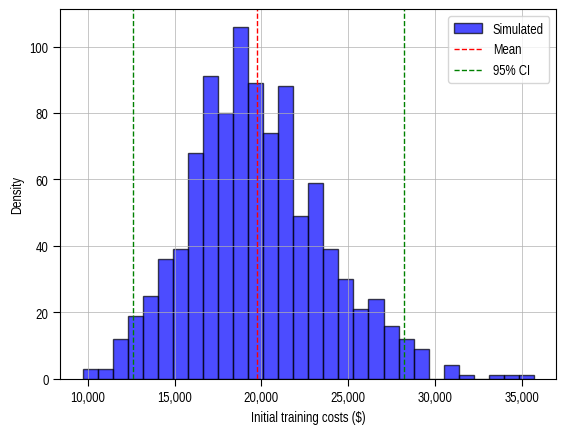

In [ ]:
# Verify if simulations work
plt.hist(g_values[2], bins=30, alpha=.7, color="b", ec="k", label="Simulated")
plt.axvline(x=np.mean(g_values[2]), color="r", linestyle="--", lw=1, label="Mean")
plt.axvline(x=g_values[1][0], color="g", linestyle="--", lw=1, label="95% CI")
plt.axvline(x=g_values[1][1], color="g", linestyle="--", lw=1)
plt.ylabel("Density")
plt.xlabel("Initial training costs ($)")
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.legend();

**Refresher training**
- These were much higher than the initial training costs in the spreadsheet
- Might be an error
- Will peg them at 80% initial training costs but conduct sensitivity analyses around startup costs

In [ ]:
per_diem_chv = 50_200_000
per_diem_trainer = 6_144_000
facility_incharge_per_diem = 1_500_000
refreshments = 3_625_000
hall_hire = 2_160_000
transport = 5_497_800
printing = 805_000
ref_adjustment = .8
tot_refresher = (per_diem_chv + per_diem_trainer +
                 facility_incharge_per_diem + refreshments +
                 hall_rental + printing + transport)/exchange_rate

refresher_sd = .2 * tot_refresher
ref_values = gamma_stats(tot_refresher, refresher_sd)
mean_ref = ref_values[0]
print(f"Mean refresher training costs: ${mean_ref:,.2f}")
print(f"95% Confidence Interval: $[{ref_values[1][0]:,.2f}, {ref_values[1][1]:,.2f}]")
print("The CI are for national projection purposes. Will use actual mean for the analysis.")

if mean_ref > g_values[0]:
  mean_ref *= ref_adjustment
  print(f"We will use a mean refresher value of ${mean_ref:,.2f}")


Mean refresher training costs: $17,540.07
95% Confidence Interval: $[11,165.70, 25,051.12]
The CI are for national projection purposes. Will use actual mean for the analysis.


**Community sensitization costs**
- These are one-off costs
- Initial costs based on 15 health facilities
- Will be scaled to reflect 30 facilities

In [ ]:
# Community sensitization costs for ICCM
# Assumes 4 days of sensitization for 15 facilities
# Assumes both intervention and control sides will be covered
sensitization = 4_873_600 * 2/ exchange_rate
sensitization *= adj_factor
print(f"Community sensitization costs were ${sensitization:,.2f}")
sensitization_per_chw = sensitization/number_of_chws
print(f"Average sensitization costs per CHW were ${sensitization_per_chw:,.2f}")


Community sensitization costs were $3,102.27
Average sensitization costs per CHW were $4.97


In [ ]:
# Planning meetings (one off costs)
strategic_planning_national = 12_517_420 # (4 days for 40 participants)
district_share_national = strategic_planning_national/40
strategic_planning_district = 17_064_800 + district_share_national # (5 days for 30 participants
strategic_planning_chv = strategic_planning_district/number_of_chws
print(f"District planning costs: ${strategic_planning_district/exchange_rate:,.2f}")
print(f"CHV share of strategic planning costs per CHV ${strategic_planning_chv/exchange_rate:,.2f}")
print("=========================================================================")
print("The CHV share will be split across all patients seen")
print("We will not annualize planning costs.")

District planning costs: $4,449.51
CHV share of strategic planning costs per CHV $7.13
The CHV share will be split across all patients seen
We will not annualize planning costs.


In [ ]:
# Assume landcruiser is 60K and motorcycles 5K each
purchase_price = 70000
lifespan = 6  # in years
annuitization_rate = 0.03  # 3%

# Calculate the present value of the future cost
def calculate_present_value(future_cost, rate, years):
    return future_cost / (1 + rate) ** years

present_value = calculate_present_value(purchase_price, annuitization_rate, lifespan)
print(f"Present value of the future cost: ${present_value:.2f}")

# Calculate the annuity factor
def calculate_annuity_factor(rate, years):
    numerator = rate * (1 + rate) ** years
    denominator = (1 + rate) ** years - 1
    return numerator / denominator

annuity_factor = calculate_annuity_factor(annuitization_rate, lifespan)
print(f"Annuity factor: {annuity_factor:.4f}")

# Calculate the annualized cost
annualized_cost = present_value * annuity_factor
print(f"Annual cost for the vehicles: ${annualized_cost:.2f}")

Present value of the future cost: $58623.90
Annuity factor: 0.1846
Annual cost for the vehicles: $10821.83


In [ ]:
rollout_costs = (strategic_planning_district/exchange_rate + sensitization
                 + mean_init + mean_ref)
supervision_national = 4_127.45 # USD
supervision_district = 3_057.37 # USD
annualized_cost = annualized_cost # USD per year (one vehicle ($60K) and two motorbikes ($5K each))
startup = rollout_costs + supervision_district + supervision_national + annualized_cost
print(f"The estimated program startup costs for Farangana in Y1: ${startup:,.2f}")

The estimated program startup costs for Farangana in Y1: $62,867.87


In [ ]:
(mean_init + mean_ref)/startup

0.5934580510106701

**Inpatient cost estimates**

- Use WHO CHOICE Estimates
- Already adjusted using a deflator
- Assume all patients treated with artesunate for three days followed by AL
- Assume all patients have a full hemogram (full blood counts)
- Assume half the patients also have microscopy
- Assume all patients get three IV infusions (Dextrose, Ringers) but only one giving set used
- Assume nurses take vital signs three times per shift across the entire admission period (for consumable estimates)
- We assume no additional feeding is done e.g., no nasogastric tubes
- Assume nurses administer artesunate at separate times from vitals (3 doses)
- Assume 30% of patients require additional doses of artesunate
- Assume personnel costs are subsumed in the WHO IP costs
- We assume that half the patients get FeSO4 for three months after discharge
- Blood transfusion unit costs [Mafirakureva, 2015](https://pubmed.ncbi.nlm.nih.gov/26598799/)

###Dosing table for drug costs AL


|Weight| Formulation | Tabs | Price |
|:------|-----------|-------|------:|
|15-25kg|  20/120mg| 6| 0.41|
|25-35kg|  20/120mg| 12| 0.82|
|35+kg| 40/240mg| 12| 1.78|

###Dosing table for drug costs AQ
|Weight |Formulation | Tabs |Price |
|:------|------------|------|------:|
|9-18kg|50/135mg| 3|0.2 |
|18-36|100/270mg|3|0.3|
|36+kg|100/270mg| 6|0.53|

###IM artesunate(0, 12, 24)
|Weight|Formulation|Vials|Price|
|:----|------------|-----|-----:|
|15-25kg|  45-60mg| 6| 4.5|
|25-35kg|  60-84mg| 12| 9.0|
|35+kg| 40/240mg| 12| 9.0|

- After the course of IM artesunate, patient takes regular course of AL or AQ
- We use population values from the study to weight the drug costs
- Treatment guidelines [WHO](https://iris.who.int/bitstream/handle/10665/162441/9789241549127_eng.pdf?sequence=1)




In [ ]:
ip_consumables = hand_rub + gloves + face_mask
ip_consumables *= 12
#AL weighted costs
art_lume = ((.41 * population_6_14/(study_pop*2)) +
         (.82 * population_6_14/(study_pop*2)) +
         (1.78 * population_14_plus/(study_pop)))
#AQ weighted costs
aq_wt = ((.2 * population_6_14/(study_pop*2)) +
         (.3 * population_6_14/(study_pop*2)) +
         (.53 * population_14_plus/(study_pop)))

# IM artesunate (we assume severity is taken care of by proportions)
iv_artesunate = ((4.5 * population_6_14/(study_pop*2)) +
         (9.0 * population_6_14/(study_pop*2)) +
         (9.0 * population_14_plus/(study_pop)))
# Adjust artesunate for those potentially requiring more doses
iv_artesunate *= 1.3
pcm = .10

iv_giving_set = 1.0 # Assume used during entire stay
iv_fluids = .85 * 3 # Assume either 5% Dextrose or Ringers Lactate
iv_cannula = .15 # With injection vent 16/18/20/22
feso4 = 1.2 * .5 # Only half the patients get iron tablets
paracetamol = .1 # Assume 10 tablets of generic paracetamol/ibuprofen
# Blood transfusion costs
bld_trans = 120 # Based on https://pubmed.ncbi.nlm.nih.gov/26598799/
# Assume only 5% of patients get a transfusion and adjust
bld_trans *= .32 * .05
tot_ip_consumables = (ip_consumables + iv_artesunate +
                      iv_giving_set + iv_fluids + iv_cannula +
                      feso4 + art_lume + paracetamol + bld_trans)
print(f"We estimate the treatment-related consumable costs for an admitted case at: ${tot_ip_consumables:,.2f}")
print("We will conduct sensitivity analyses around this value")

We estimate the treatment-related consumable costs for an admitted case at: $22.49
We will conduct sensitivity analyses around this value


In [ ]:
# laboratory test
hemogram = 3.00 # Full blood counts
rbs = .7 # Random blood sugar
microscopy = 1.5 # Additional checks
rft = 4.00 # Renal function tests
lft = 4.00 # Liver function tests
total_ip_lab = total_rdt + hemogram + lft + rft + rbs + microscopy
print(f"We assume that total lab costs for severe malaria are: ${total_ip_lab:,.2f}")

We assume that total lab costs for severe malaria are: $15.19


In [ ]:
# Generate sum of lab and consumables
ipd_cons_lab = tot_ip_consumables + total_ip_lab
print(f"We estimate total IP consumable costs at: ${ipd_cons_lab:,.2f}")

We estimate total IP consumable costs at: $37.67


In [ ]:
# Years lived with disability
# Number of incident cases
# Average duration of a case
# Disability weight
# Wastage is a parameter that can be adjusted to include stockouts.
# Change service utilization to reflect what the study found. For example, RDT can increase to 100% if home-based services given.
# Alternatively use mean values from the study
adherence = .808 # Adjust accordingly
wastage = .15 # Adjust accordingly
utilization = 1 # Can adjust service utilization instead and maintain efficacy levels as constant (unless multiplicative)
mal_in_fever = .3481 # proportion of malaria in cases with fever [Consult and change accordingly]
efficacy_no_prog = .748
efficacy_prog = .9195
proportion_severe = .082 # Proportion of malaria cases that are severe
cfr = 1.371e-02
protection = (100 - wastage) * utilization * adherence
cases_averted_no_prog = protection * mal_in_fever * efficacy_no_prog * proportion_severe
cases_averted_prog = protection * mal_in_fever * efficacy_prog * proportion_severe
deaths_averted_no_prog = protection * cfr * efficacy_no_prog * mal_in_fever
deaths_averted_prog = protection * cfr * efficacy_prog * mal_in_fever

In [ ]:
deaths_averted_prog - deaths_averted_no_prog

0.06603360878520415

In [ ]:
# Estimate discounted future life years saved for each death averted
life_expectancy = 65.3 # Life expectancy at birth
avg_age_death = 2.5 # assume average age of death
discounted_future_years = np.sum([1/(1 + discount_rate)**t for t in list(range(int(life_expectancy - avg_age_death)))])
print(f"The average discounted years lived per death averted is: {discounted_future_years:,.2f} years")
print("This value will be used in estimating economic benefits of each death averted")

The average discounted years lived per death averted is: 28.84 years
This value will be used in estimating economic benefits of each death averted


**Value of statistical life**
This will be used to estimate the mortality prevention benefits.

**Estimation of economic value of donated time**
- The average consultation time is a function of whether RDT tests are offered or not
- Unlike in health facilities where activities are done in parallel, for CHVs we assume that activities are done serially.
- That is, a CHV's consultation time per patient will be much longer as they have to wait at the home until an RDT is run.
- The CHVs may offer other services like health promotion at this time, but these will not be valued.
- As such, CHV time should be seen as an over-estimate.
- We will conduct sensitivity analyses around this value.


**CHV Non-Clinical Time Costs**
- Assume 1 visit monthly to health facility for meetings, supplies, reports
- Monthly meeting plus travel pegged at 6 hours
- Assume 1 hour per week on reports, notes, drug reconciliations
- Assume no home visits
- Andres to confirm plausibility of these assumptions
- Senior author: [Improving geographical accessibility modeling for operational use by local health actors](https://link.springer.com/article/10.1186/s12942-020-00220-6)
- Senior author: [Geographic barriers to care persist at the community healthcare level: Evidence from rural Madagascar.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10022327/)


In [ ]:
def chv_clinical_time(consult_time, consultations_per_year, rdt_adjustment, hourly_wage_nominal):
  tot_time = (consult_time/60) * consultations_per_year * rdt_adjustment
  avg_cost = tot_time * hourly_wage_nominal
  return tot_time, avg_cost

consult_time = 45.7 # This includes clerking, running RDT, dispensing, health promotion
consultations_per_year = consultations/(number_of_chws)
rdt_adjustment = .8 # Proportion of all reviews that get RDT

facility_travel = 6 * 12 # Assume CHV will travel to health facility once a month
report_time = 8 * 12 # Assume time for reports, drug reconciliations
tot_extra_time = facility_travel + report_time

non_clin_time_cost = hourly_wage_nominal * tot_extra_time

clinical_time, clin_time_cost = chv_clinical_time(consult_time,
                                                  consultations_per_year,
                                                  rdt_adjustment, hourly_wage_nominal)
clin_time_cost += non_clin_time_cost
donated_time = gamma_stats(clin_time_cost, clin_time_cost * .2)
average_cost = donated_time[0]
average_cost_ppp = donated_time[0] * hourly_wage_ppp/hourly_wage_nominal
lower_bound = donated_time[1][0]
upper_bound = donated_time[1][1]
lower_bound_ppp = donated_time[1][0] * hourly_wage_ppp/hourly_wage_nominal
upper_bound_ppp = donated_time[1][1] * hourly_wage_ppp/hourly_wage_nominal
print(f"Estimated Average Incremental Economic Cost of CHV time per year: ${average_cost:,.2f}. Nominal")
print(f"95% CI: $[{lower_bound:,.2f}, {upper_bound:,.2f}]")
print("=========================================================================")
print(f"Estimated Average Incremental Economic Cost of CHV time per year: ${average_cost_ppp:,.2f}. PPP")
print(f"95% CI: $[{lower_bound_ppp:,.2f}, {upper_bound_ppp:,.2f}]")
print("=========================================================================")
print("These costs do not cover travel to home, facility, or reporting time or other diseases managed.")
print("=========================================================================")

Estimated Average Incremental Economic Cost of CHV time per year: $110.76. Nominal
95% CI: $[71.16, 159.07]
Estimated Average Incremental Economic Cost of CHV time per year: $437.23. PPP
95% CI: $[280.90, 627.91]
These costs do not cover travel to home, facility, or reporting time or other diseases managed.


In [ ]:
donated_time[1][1]

159.07015143375054

In [ ]:
mean_time = np.mean(donated_time[2])
lower_time = np.quantile(donated_time[2], .025)
upper_time = np.quantile(donated_time[2], .975)
print(f"The estimated donated time by CHWs is {mean_time:,.1f} [{lower_time:,.1f}, {upper_time:,.1f}] hours per year")
print("This is time spent treating over-5s with fever")

The estimated donated time by CHWs is 110.8 [71.2, 159.1] hours per year
This is time spent treating over-5s with fever


In [ ]:
def bootstrap_ci(data,axis):
  return np.mean(data, axis=axis)
res = bootstrap((donated_time[2],) , bootstrap_ci, confidence_level=.95,
                n_resamples=10_000, method="percentile")
ci_lower, ci_upper = res.confidence_interval
ci_lower

109.38759198590274

### Mortality costs estimates

- Use value of statistical life and crosscheck with NPV to see if estimates make sense


In [ ]:
# Mortality benefits
# Verify with team if there are any mortality benefits
def calculate_npv(mean_age_of_death, life_expectancy, discount_rate, gdp_per_capita):
    years_of_life_lost = life_expectancy - mean_age_of_death
    npv = 0

    for year in range(1, years_of_life_lost + 1):
        discounted_value = gdp_ppp / ((1 + discount_rate) ** year)
        npv += discounted_value

    return npv

# Given parameters
median_age_of_death = round(19.3)
life_expectancy = round(67.8)
discount_rate = 0.03  # 3%
mean_age_work = 15
# Calculate NPV -- this assumes that the mean age of economic productivity is 15
# Some economists use 12 years

result_1 = calculate_npv(median_age_of_death, life_expectancy, discount_rate, gdp_ppp)
result_2 = calculate_npv(median_age_of_death, (mean_age_work - median_age_of_death), discount_rate, gdp_ppp)
print("================================================================")
print(f"Net Present Value of a life lost in Madagascar: ${result_1 - result_2:.2f}")
print("================================================================")

Net Present Value of a life lost in Madagascar: $40828.15


**Estimating mortality averted benefits using VSL**
- Approach used outlined in this paper
- Income elasticities and global values of a statistical life. [Viscusi & Masterman 2017](https://www.cambridge.org/core/journals/journal-of-benefit-cost-analysis/article/income-elasticities-and-global-values-of-a-statistical-life/5AE299883F668DCC265C41A377E1E063)

Formula:

$$ VSL_{M} = VSL_{US} * \left(\frac{GDP.PPP_{M}}{GDP.PPP_{US}}\right)^{\epsilon} $$

Where: $\epsilon$ = income elasticity

While the paper above uses an eta of 1.0, we follow [Robinson et al. 2019](https://www.cambridge.org/core/journals/journal-of-benefit-cost-analysis/article/valuing-mortality-risk-reductions-in-global-benefitcost-analysis/71252D2A48B3F2402DF209550C1945FA) and use an $\epsilon$ of 1.4

Will conduct sensitivity analyses around this value because it has a great impact on the results.

In [ ]:
# Use US values as baseline
us_gdp_pc = 76_329.58 # World Bank 2022
gdp_ratio = gdp_per_capita/us_gdp_pc
eta = 1.4 # Income elasticity (will conduct sensitivity analyses around this value)
life_expectancy = 67.8
median_age = 19.3
rem_life = int(life_expectancy - median_age)
us_vsl = 11_377_977 # USDA values 2022
mada_vsl = us_vsl * (gdp_ppp/us_gdp_pc) ** eta

# Robinson et al recommend using 20 times GNI if VSL lower than GNI per capita
if mada_vsl > gdp_ppp * 20:
  pass
else:
  mada_vsl = gdp_ppp * 20
print("================================================================")
print(f"The estimated VSL for Madagascar is: ${mada_vsl:,.2f}")
print("================================================================")
# Estimate VSL per year Madagascar
vsl_year_mada = mada_vsl/np.sum([(1+discount_rate) ** -t for t in range(rem_life)])
print(f"Annualized VSL Madagascar: ${vsl_year_mada:,.2f}")
print("================================================================")
print("Note the values from the VSL approach are $10K greater than NPV.")
print("We will use the more conservative VSL figures.")

The estimated VSL for Madagascar is: $50,867.79
Annualized VSL Madagascar: $1,954.60
Note the values from the VSL approach are $10K greater than NPV.
We will use the more conservative VSL figures.


In [ ]:
life_expectancy

67.8

In [ ]:
#Funeral costs -- use placeholder value (to update)
funeral_cost = 1_500

Note:
Impact of the program can be estimated by multiplying DALYs by VSL per year

## Estimate patient level time costs with and without program
- Estimate number of sick days averted
- This is from progression to severe disease as well as days sick untreated
- Adjust each year VSL by economic growth rate (values from IMF)


## National level estimates from World Malaria Report 2022

| Indicator | Mean | Lower| Upper |
|:----------|------|-------|------:|
|Cases | 3559518| 2269000| 4940000|
|Deaths| 9111| 3510 |17000 |
|Progression | .02 |.01 |.03|

- Progression refers to uncomplicated cases that become severe.
- The CHV expansion reduces this progression

**Other assumptions**

IRR values. Zambia study.

|Indicator | Mean | Range | Source |
|:---------|------|-------|-------:|
|*Admission reduction | .81| [.75, .87], p.002|[Ashton](https://pubmed.ncbi.nlm.nih.gov/36927440/)|
|*Deaths reduction | .77| [.66, .91], p<.001|[Ashton](https://pubmed.ncbi.nlm.nih.gov/36927440/)|
|Admission reduction | .84| [.78, .90], p<.001 |[Ashton](https://pubmed.ncbi.nlm.nih.gov/36927440/)|
|Deaths reduction | .78| [.68, .89], p<.001|[Ashton](https://pubmed.ncbi.nlm.nih.gov/36927440/)|

Starred (*) refer to under-5

##Probabilistic sensitivity analyses

- Will use the functions defined above for key parameters
- Values will be used to produce CEA, CEAC, CEA reimbursement plots


In [ ]:
# To verify numbers with Andres
# Will use these proportions to adjust the Madagascar values
malaria_cases_mean = 3_559_518
malaria_cases_lower = 2_269_000
malaria_cases_upper = 4_940_000
uncomplicated_severe_lower = .01 # World Malaria report
uncomplicated_severe_mean = .02 # Uncomplicated cases that become severe
uncomplicated_severe_upper = .03
severe_hospitalized = .65 # 50-80% of severe cases
reduction_admission_chv = .16 # IRR .84[.78-.90, p<.001] https://pubmed.ncbi.nlm.nih.gov/36927440/
reduction_mortality_chv = .22 # IRR .78[.68-.89, p<.001] https://pubmed.ncbi.nlm.nih.gov/36927440/
malaria_deaths_mean = 9_111
malaria_deaths_lower = 3_510
malaria_deaths_upper = 17_000
# Source -- World Malaria Report 2023
deaths_averted_chv = .19  # Under 5 data https://pubmed.ncbi.nlm.nih.gov/36927440/
lower_range_mal = malaria_cases_lower/malaria_cases_mean
upper_range_mal = malaria_cases_upper/malaria_cases_mean
lower_range_death = malaria_deaths_lower/malaria_deaths_mean
upper_range_death = malaria_deaths_upper/malaria_deaths_mean
# Generate standard deviations of key parameters
# These will be used in the PSA
sd_cases = ((malaria_cases_upper - malaria_cases_lower)/3.92)/malaria_cases_mean
# sd_cases will be used as a factor for getting sds

dead_sd = ((malaria_deaths_upper - malaria_deaths_lower)/3.92)/malaria_deaths_mean
severe_sd = ((uncomplicated_severe_upper - uncomplicated_severe_lower)/3.92)/uncomplicated_severe_mean
deaths_prop = malaria_deaths_mean / malaria_cases_mean
hosp_sd = (.8 - .5)/(3.92 * .65) # See above
hosp_sd

0.11773940345368919

In [ ]:
deaths_prop

0.0025596162177013854

In [ ]:
# Length of stay -- convert to mean and sd
# Most papers report this as median and IQR 7 [4,10]
# S.P. Hozo, B. Djulbegovic, and I. Hozo 2005 for details
# "Estimating the Mean and Variance from the Median, Range, and the Size of a Sample," BMC Medical Research Methodology 2005, 5:13
mean_los = (4 + (2 * 7) + 10)/ 4
sd_los = np.sqrt(((4 - (2*7) + 10)/4 + (10-4)**2)/12)

## Parameters/Assumptions

Source: Global Burden of Disease 2019

|Indicator | Mean | Range |
|:---------|------|-------:|
|Uncomplicated malaria|.051 |(.032-.074)|
|Severe malaria DW |.133 | (.088-.19)|
|Severe malaria anemia DW|.178|(.122-.247)|
|Cerebral malaria DW|.471| |
|Cerebral malaria and anemia DW| .620| |
|Severe anemia risk | .322| (.043, .77)|
|Cerebral malaria risk| .002| (.001 - .003)|
|Neurological deficits risk| .032| (.020-.050)|
|Risk death SMA | .097| |
|Risk death cerebral malaria| .192| |
|Risk death neurological| .19| |

In [ ]:
@dataclass
class SimulationInputs:
  n_iterations: int = 10_000

  chv_consults: float = consultations
  chv_consults_sd: float = chv_consults * sd_cases

  chv_fever: float = fever_cases
  chv_fever_sd: float = chv_fever * sd_cases

  u_mal: float = pos_rdt
  u_mal_sd: float = u_mal * sd_cases

  # opd_averted: float = u_mal * .55 * .6 # Estimate >5 visits to OPD averted
  # opd_averted_sd: float = opd_averted * .19

  # never_opd: float = u_mal * .55 * .6 # Estimate >5 visits who never go to OPD
  # never_opd_sd: float = never_opd * .19

  # change_opd: float = u_mal * .55 * .4 * .5 # Estimate >5 visits who stop OPD (half OPD attendees)
  # change_opd_sd: float = change_opd * .19

  opd_averted: float = inc_consult # Estimate >5 visits to OPD averted
  opd_averted_sd: float = opd_averted * .19

  never_opd: float = inc_consult * .45 # Assume 45% will never go to OPD for malaria
  never_opd_sd: float = never_opd * .19

  change_opd: float = inc_consult *.55 # Assume the rest are changed
  change_opd_sd: float = change_opd * .19

  chv_act: float = inc_act
  chv_act_sd: float = chv_act * sd_cases

  severe_mal: float = opd_averted * proportion_severe
  severe_mal_sd: float = severe_mal * severe_sd

  adm_rate: float = severe_hospitalized
  adm_rate_sd: float = hosp_sd

  admissions: float = adm_rate * severe_mal
  admissions_sd: float = admissions * adm_rate_sd

  reduction_admission_chv: float = reduction_admission_chv
  reduction_admission_chv_sd: float = (.22 - .10)/(3.92 * .16)

  admissions_averted: float = reduction_admission_chv * admissions
  admissions_averted_sd: float = admissions * reduction_admission_chv_sd

  deaths: float = inc_rdt * deaths_prop
  deaths_sd: float = deaths * dead_sd

  reduction_mortality_chv: float = reduction_mortality_chv
  reduction_mortality_chv_sd: float = (.32 - .11)/(3.92 * .22)

  deaths_averted:float = deaths * reduction_mortality_chv
  deaths_averted_sd: float = deaths_averted * reduction_mortality_chv_sd

  length_of_stay: float = mean_los *1.5 # Adjust for complications like CM
  los_sd: float = sd_los * 1.2

  ip_per_diem: float = ipd_costs_2022
  ip_per_diem_sd: float = ip_per_diem * .15

  ipd_cons_lab: float = ipd_cons_lab
  ipd_cons_lab_sd: float = ipd_cons_lab * .10

  dw_um: float = .1
  dw_um_sd: float = dw_um * .19

  duration_um: float = 5.1 # Duration uncomplicated malaria
  duration_um_sd: float = duration_um * .19

  duration_sm: float = 8.75 # Duration severe
  duration_sm_comp: float = 11.0 # Duration complications

  duration_sm_overall: float = duration_sm + duration_sm_comp
  duration_sm_overall_sd: float = duration_sm_overall * .19

  dw_sm: float = .471
  dw_sm_sd: float = (.550 - .411)/(3.92 * .471)

  admission_cost: float = ip_per_diem + ipd_cons_lab
  admission_cost_sd: float = ip_per_diem_sd + (ipd_cons_lab * .19)

  startup: float = startup
  startup_sd: float = startup * .11

sim_data = SimulationInputs()

In [ ]:
#sim_data.admissions_averted
inc_rdt

177560.94964112467

In [ ]:
def model_simulation_inputs(sim_data):
  """
  Pick random values from different distributions
  """
  hospital_stay = log_normal(sim_data.length_of_stay, sim_data.los_sd)[0]
  admission_cost =  gamma_stats(sim_data.admission_cost, sim_data.admission_cost_sd)[2][0]
  ip_per_diem = gamma_stats(sim_data.ip_per_diem, sim_data.ip_per_diem_sd)[2][0]
  ipd_cons_lab = gamma_stats(sim_data.ipd_cons_lab, sim_data.ipd_cons_lab_sd)[2][0]
  deaths_averted = log_normal(sim_data.deaths_averted, sim_data.deaths_averted_sd)[0]
  admissions_averted = log_normal(sim_data.admissions_averted, sim_data.admissions_averted_sd)[0]
  duration_um = log_normal(sim_data.duration_um, sim_data.duration_um_sd)[0]
  duration_sm_overall = log_normal(sim_data.duration_sm_overall, sim_data.duration_sm_overall_sd)[0]
  dw_sm = beta_stats(sim_data.dw_sm, sim_data.dw_sm_sd)[0]
  dw_um = beta_stats(sim_data.dw_um, sim_data.dw_um_sd)[0]
  opd_averted = log_normal(sim_data.opd_averted, sim_data.opd_averted_sd)[0]
  never_opd = log_normal(sim_data.never_opd, sim_data.never_opd_sd)[0]
  change_opd = log_normal(sim_data.change_opd, sim_data.change_opd_sd)[0]
  startup = gamma_stats(sim_data.startup, sim_data.startup_sd)[2][0]
  return (
      hospital_stay, admission_cost,ip_per_diem ,ipd_cons_lab, deaths_averted,
      admissions_averted,
      duration_um, duration_sm_overall, dw_sm, dw_um, opd_averted,
      never_opd, change_opd, startup
  )

In [ ]:
x = gamma_stats(183207, 45801.75)

In [ ]:
x[3]

16.0

In [ ]:
x[4]

11450.4375

In [ ]:
#Calculate alphas and betas for the beta parameters given 95% CI and mean

# Given confidence interval and mean
ci_lower = 0.15
ci_upper = 0.34
mean = 0.26

# Define the objective function to minimize
def objective(params):
    alpha, beta_param = params
    ci_calculated_lower = beta.ppf(0.025, alpha, beta_param)
    ci_calculated_upper = beta.ppf(0.975, alpha, beta_param)
    mean_calculated = alpha / (alpha + beta_param)
    return (ci_calculated_lower - ci_lower)**2 + (ci_calculated_upper - ci_upper)**2 + (mean_calculated - mean)**2

# Initial guesses for alpha and beta
initial_guess = [1, 1]

# Minimize the objective function
result = minimize(objective, initial_guess, bounds=((0.01, None), (0.01, None)))
alpha_estimated, beta_estimated = result.x

alpha_estimated, beta_estimated


(19.453362230405748, 59.5590507459292)

In [ ]:
sim = model_simulation_inputs(sim_data)
sim

(10.416116469909348,
 41.5941260839688,
 6.504990128510565,
 37.60502251349914,
 97.50721492162464,
 366.9279555121552,
 4.644919540124123,
 18.123859314703996,
 0.5814035131855041,
 0.08463278214356221,
 160781.32839087004,
 112553.34257798843,
 159475.21627161925,
 57185.376145653005)

In [ ]:
def model_single_run(sim_data):
  (
      hospital_stay, admission_cost, ip_per_diem, ipd_cons_lab, deaths_averted,
      admissions_averted,
      duration_um, duration_sm_overall, dw_sm, dw_um, opd_averted,
      never_opd, change_opd, startup
  ) = model_simulation_inputs(sim_data)

  return (
      hospital_stay, admission_cost, ip_per_diem, ipd_cons_lab, deaths_averted,
      admissions_averted,
      duration_um, duration_sm_overall, dw_sm, dw_um, opd_averted,
      never_opd, change_opd, startup
  )

In [ ]:
def monte_carlo_data(sim_data):
  """
  Conduct Monte Carlo simulations with the above data
  """
  values = [model_single_run(sim_data) for i in range(sim_data.n_iterations)]
  df = pd.DataFrame(
      values,
      columns = [
          "hospital_stay", "admission_cost", "ip_per_diem","ipd_cons_lab",
          "deaths_averted", "admissions_averted",
          "duration_um", "duration_sm_overall", "dw_sm", "dw_um", "opd_averted",
          "never_opd", "change_opd", "startup"
      ]
  )
  return df

In [ ]:
df = monte_carlo_data(sim_data)
df[:10]

hospital_stay  admission_cost  ip_per_diem  ipd_cons_lab  deaths_averted  \
0      13.142460       32.472274     6.796196     42.936577      106.166200   
1       8.817061       33.613515     5.507104     35.107160       76.598627   
2       8.282067       40.857591     4.933800     40.852525       74.210107   
3      11.536368       44.936178     6.158990     37.411482      123.811453   
4      11.254350       35.877257     8.538693     42.338363       69.125520   
5      10.987104       39.018212     6.752961     33.985645       83.234735   
6      10.572883       39.868490     7.141594     44.304551      126.741894   
7      10.025287       30.242753     6.912637     37.718387      118.071226   
8      10.247850       45.652557     6.075033     32.078109      104.355996   
9      10.270928       40.713356     6.438456     36.636404      126.294510   

   admissions_averted  duration_um  duration_sm_overall     dw_sm     dw_um  \
0         1292.095371     6.436599            14.621049  0.464187  0.095752   
1          337.777094     6.486283            23.591065  0.380239  0.090541   
2         1340.971573     5.507120            22.246433  0.431016  0.116262   
3          203.292477     4.349772            18.679459  0.434847  0.084550   
4          634.149056     4.671859            19.889661  0.409372  0.101087   
5          150.345563     5.111232            18.855781  0.560260  0.149946   
6         2141.323814     6.603925            23.692378  0.470846  0.091719   
7          304.199969     6.351542            19.787073  0.380283  0.067562   
8          159.577164     4.767248            23.032629  0.390660  0.114673   
9          383.332278     5.829768            16.919266  0.297541  0.098040   

     opd_averted      never_opd     change_opd       startup  
0  182201.316982   87764.752058  132650.713053  67501.330772  
1  133838.015034   86516.923941   88557.571417  57198.672950  
2  189220.175447   75264.023443  108725.530012  64600.091875  
3  224024.089660   88817.714231   77161.121516  55820.202519  
4  143825.245528   67099.106599  103626.557288  59968.269413  
5  225021.155806   85270.294143   93759.789161  57134.077883  
6  264143.544524   66614.187174  137766.394341  67721.160079  
7  223030.593077   99481.334833  109759.849469  68425.998747  
8  253658.930746  121343.307987   82256.777709  65246.416330  
9  193841.600025  108619.769855  100733.064678  64735.564645

In [ ]:
df["ip_per_diem"].quantile(.025)

4.745523763666366

In [ ]:
df["startup"].mean()

62819.74087711201

The assumptions regarding averted outpatient department (OPD) visits encompass two main categories: patients who would never seek care at the OPD and those who would have visited the OPD in the absence of the intervention. For the latter category, it is acknowledged that certain patients may still choose to utilize OPD services despite the intervention, influenced by factors such as proximity to the facility, perceived quality of care, or other reasons. As a result, the substitution effects for OPD visits will encompass both the costs associated with patients who would never have visited the OPD and the "savings" from the latter category, which may manifest as negative costs due to reduced utilization of OPD services.

In [ ]:
# Note that we are using the assumed change OPD and not change plus never OPD
df["opd_costs_averted"] = df['change_opd'] * (opd_costs_2022 + total_rdt +
                                              pcm + art_lume +
                            0.3 *(hemogram + microscopy))
# Ignore RDT and treatment costs for OPD costs averted to avoid double counting
df["admission_cost"] = df['ip_per_diem'] * df['hospital_stay'] + df['ipd_cons_lab']
df["admissions_costs_averted"] = df["admission_cost"] * df['admissions_averted']

# Death QALY -- based on averted deaths
df["death_qaly"] = df["deaths_averted"] * discounted_future_years
df["death_costs"] = df["deaths_averted"] * (vsl_year_mada + funeral_cost)

#DALY estimates (OPD) -- assume shorter duration of sickness (use change + never)
df["um_qaly"] = df['duration_um'] * df['dw_um'] * df['opd_averted']/365
df["sm_qaly"] = df['duration_sm_overall'] * df['dw_sm'] * df['admissions_averted']/365
df["total_qaly"] = df["death_qaly"] + df["um_qaly"] + df["sm_qaly"]
df["inc_rx"] = (df['change_opd'] + df['never_opd']) * (total_rdt + pcm + art_lume + chv_equipment) * 1.05
df["inc_prog"] = (df["inc_rx"] + df["startup"] - df['opd_costs_averted']
                  - df["admissions_costs_averted"])
etas = [i/10 for i in range(10, 26)]
for eta in etas:
  mada_vsl = us_vsl * (gdp_ppp/us_gdp_pc) ** eta
  vsl_year = mada_vsl/np.sum([(1+discount_rate) ** -t for t in range(rem_life)])
  eta = str(eta)
  df[f"death_costs_{eta}"] = df["deaths_averted"] * (vsl_year +funeral_cost)
df[:10]

hospital_stay  admission_cost  ip_per_diem  ipd_cons_lab  deaths_averted  \
0      13.142460      132.255318     6.796196     42.936577      106.166200   
1       8.817061       83.663635     5.507104     35.107160       76.598627   
2       8.282067       81.714584     4.933800     40.852525       74.210107   
3      11.536368      108.463854     6.158990     37.411482      123.811453   
4      11.254350      138.435800     8.538693     42.338363       69.125520   
5      10.987104      108.181128     6.752961     33.985645       83.234735   
6      10.572883      119.811784     7.141594     44.304551      126.741894   
7      10.025287      107.019558     6.912637     37.718387      118.071226   
8      10.247850       94.334140     6.075033     32.078109      104.355996   
9      10.270928      102.765321     6.438456     36.636404      126.294510   

   admissions_averted  duration_um  duration_sm_overall     dw_sm     dw_um  \
0         1292.095371     6.436599            14.621049  0.464187  0.095752   
1          337.777094     6.486283            23.591065  0.380239  0.090541   
2         1340.971573     5.507120            22.246433  0.431016  0.116262   
3          203.292477     4.349772            18.679459  0.434847  0.084550   
4          634.149056     4.671859            19.889661  0.409372  0.101087   
5          150.345563     5.111232            18.855781  0.560260  0.149946   
6         2141.323814     6.603925            23.692378  0.470846  0.091719   
7          304.199969     6.351542            19.787073  0.380283  0.067562   
8          159.577164     4.767248            23.032629  0.390660  0.114673   
9          383.332278     5.829768            16.919266  0.297541  0.098040   

   ...  death_costs_1.6  death_costs_1.7  death_costs_1.8  death_costs_1.9  \
0  ...    255053.156528    224345.080141    203479.884645    189302.624643   
1  ...    184020.164300    161864.370037    146810.187781    136581.332940   
2  ...    178281.996812    156817.070633    142232.312038    132322.416168   
3  ...    297444.026829    261632.143451    237299.067737    220765.489554   
4  ...    166066.810808    146072.577523    132487.109615    123256.201100   
5  ...    199962.718386    175887.460842    159529.062193    148414.032339   
6  ...    304484.104658    267824.604843    242915.599773    225990.695267   
7  ...    283653.732944    249502.183450    226297.253655    210530.216003   
8  ...    250704.332557    220519.849057    200010.418859    186074.890460   
9  ...    303409.309689    266879.213824    242058.134767    225192.973289   

   death_costs_2.0  death_costs_2.1  death_costs_2.2  death_costs_2.3  \
0    179669.611563    173124.274804    168676.919349    165655.077803   
1    129631.139992    124908.697181    121699.942219    119519.691696   
2    125588.946053    121013.759755    117905.061074    115792.795725   
3    209531.430583    201898.232277    196711.708286    193187.624404   
4    116984.082053    112722.369649    109826.666858    107859.125680   
5    140861.710666    135730.139864    132243.394989    129874.258852   
6    214490.742069    206676.876797    201367.595146    197760.101202   
7    199816.997797    192537.694808    187591.631823    184230.933816   
8    176606.126584    170172.392120    165800.866999    162830.549838   
9    213733.613645    205947.330446    200656.789968    197062.030076   

   death_costs_2.4  death_costs_2.5  
0    163601.829211    162206.709806  
1    118038.278377    117031.703490  
2    114357.576244    113382.388652  
3    190793.117559    189166.123643  
4    106522.241831    105613.870284  
5    128264.503554    127170.724231  
6    195308.919779    193643.417227  
7    181947.442658    180395.880495  
8    160812.310484    159440.978781  
9    194619.501050    192959.877537  

[10 rows x 39 columns]

In [ ]:
# Gamma distribution parameters
# Given confidence interval and mean
ci_lower = df["death_qaly"].quantile(.025)/99.96
ci_upper = df["death_qaly"].quantile(.975)/99.96
mean = df["death_qaly"].mean()/99.96

# Define the objective function to minimize
def objective(params):
    alpha, rate = params
    ci_calculated_lower = gamma.ppf(0.025, alpha, scale=1/rate)
    ci_calculated_upper = gamma.ppf(0.975, alpha, scale=1/rate)
    mean_calculated = alpha / rate
    return (ci_calculated_lower - ci_lower)**2 + (ci_calculated_upper - ci_upper)**2 + (mean_calculated - mean)**2

# Initial guesses for alpha and rate
initial_guess = [1, 1]

# Minimize the objective function
result = minimize(objective, initial_guess, bounds=((0.01, None), (0.01, None)))
alpha_estimated, rate_estimated = result.x

alpha_estimated, rate_estimated

(16.894809818861194, 0.5725059582978509)

In [ ]:
df["deaths_averted"].mean()

100.20998779527295

In [ ]:
df["death_qaly"].mean()

2890.0914295471152

In [ ]:
mean_cost = np.mean(df["inc_prog"])
var_cost = np.var(df["inc_prog"], ddof=1)
mean_effect = np.mean(df["total_qaly"])
var_effect = np.var(df["total_qaly"], ddof=1)
cov_cost_effect = np.cov(df["inc_prog"], df["total_qaly"], ddof=1 )[0,1]

z = norm.ppf(.975)
a = var_cost - z**2 * var_effect
b = 2 * z**2 * mean_effect * cov_cost_effect - 2 * mean_cost * var_effect
c = z**2 * var_effect * mean_cost **2 - var_cost * mean_effect**2


discriminant = b**2 - 4 * a *c

if discriminant < 0:
  raise ValueError("The disciminant cannot be negative ")
sqrt_discriminant = np.sqrt(discriminant)
ci_lower = (b - sqrt_discriminant)/(2 * a)
ci_upper = (b + sqrt_discriminant)/(2 * a)

In [ ]:
# Generate net health benefit -- to be used for EVPPI calculations
df["nmb_hs"] = df["total_qaly"] * 133 - df["inc_prog"]
voi = np.sum([t for t in df["nmb_hs"] if t > 0])/10000
print(f"The net monetary benefit is ${abs(voi):,.2f}")

The net monetary benefit is $501,073.20


In [ ]:
x = df["nmb_hs"].mean()
x/np.sqrt(np.sum([(t - x)**2 for t in df["nmb_hs"] if t < 0])/10_000)

37.59706986743947

In [ ]:
j = df["total_qaly"] * 190 - df["inc_prog"]
mean_j = j.mean()
mean_j/(np.sqrt(np.sum([(t - mean_j)**2 for t in j if t < 0])/10_000))

inf

In [ ]:
ceracs = []
thresholds = list(range(1,751,1))
for x in thresholds:
  j = df["total_qaly"] * x - df["inc_prog"]
  mean_j = j.mean()
  cerac = mean_j/(np.sqrt(np.sum([(t - mean_j)**2 for t in j if t < 0])/10_000))
  ceracs.append(cerac)
ceracs = [100 if x == np.inf else x for x in ceracs]
len(ceracs)

750

In [ ]:
ceracs[185:190]

[100, 100, 100, 100, 100]

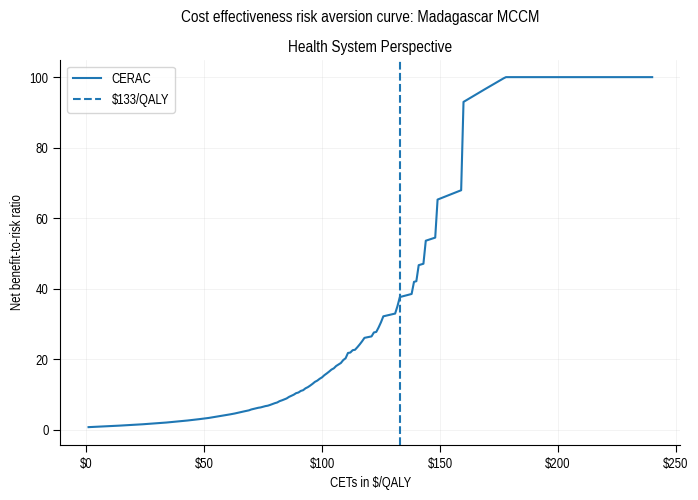

In [ ]:
# Plot CERAC
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(thresholds[:240], ceracs[:240], label="CERAC")
plt.ylabel("Net benefit-to-risk ratio")
plt.xlabel("CETs in $/QALY")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.grid(alpha=.2)
plt.axvline(133, ls="--", label="$133/QALY")
plt.legend(loc="best")
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
plt.suptitle("Cost effectiveness risk aversion curve: Madagascar MCCM")
plt.title("Health System Perspective")
plt.savefig("cerac_hs.png", bbox_inches="tight");

In [ ]:
files.download("cerac_hs.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Generate net health benefit -- to be used for EVPPI calculations
df["nhb_hs"] = df["total_qaly"] - df["inc_prog"]/133
voi = np.sum([t for t in df["nhb_hs"] if t > 0])/10000
print(f"The net health benefit is {abs(voi):,.2f} DALYs averted")

The net health benefit is 3,767.47 DALYs averted


In [ ]:
##Plot Net Monetary Benefit Curve
# Define parameters
delta_E_mean = df["total_qaly"].mean()  # Mean incremental effectiveness
delta_C_mean = df["inc_prog"].mean()  # Mean incremental cost
var_delta_E = np.var(df["total_qaly"])  # Variance of incremental effectiveness
var_delta_C = np.var(df["inc_prog"])  # Variance of incremental cost
cov_delta_E_C = np.cov(df["inc_prog"].values, df["total_qaly"].values)[0,1]  # Covariance between incremental effectiveness and cost (assumed 0 for independence)
inc_budget = df["inc_rx"].mean()
#cov_delta_E_C = 0
# Create an array of lambda values from $1000 to $100000 in increments of $1000
lambda_values = np.arange(0, 751, 1)

# Lists to store results
nmb_means = []
ci_lowers = []
ci_uppers = []
rois = []

# Calculate NMB, SE(NMB), 95% CI, and ROI for each lambda
for lambda_ in lambda_values:
    #NMB = lambda_ * delta_E_mean - delta_C_mean
    nmbs = df["total_qaly"] * lambda_ - df["inc_prog"]
    NMB = np.sum([t for t in nmbs if t > 0])/10000
    SE_NMB = np.sqrt((lambda_**2 * var_delta_E) + var_delta_C - 2 * lambda_ * cov_delta_E_C)
    CI_lower = NMB - 1.96 * SE_NMB
    CI_upper = NMB + 1.96 * SE_NMB
    # ROI = NMB / delta_C_mean

    nmb_means.append(NMB)
    ci_lowers.append(CI_lower)
    ci_uppers.append(CI_upper)
    # rois.append(ROI)

# Create a DataFrame
cov_df = pd.DataFrame({
    'Lambda': lambda_values,
    'NMB Mean': nmb_means,
    'Lower 95% CI': ci_lowers,
    'Upper 95% CI': ci_uppers,
})
cov_df["ROI"] = cov_df["NMB Mean"]/inc_budget
# Display the DataFrame
cov_df[:5]

# Optionally, save the DataFrame to a CSV file
#df.to_csv('nmb_confidence_intervals_and_roi.csv', index=False)


Lambda       NMB Mean   Lower 95% CI   Upper 95% CI       ROI
0       0  110040.084752 -351534.148398  571614.317902  0.147819
1       1  111898.289662 -349768.471118  573565.050441  0.150315
2       2  113790.489496 -347973.041895  575554.020886  0.152857
3       3  115720.833847 -346143.708469  577585.376163  0.155450
4       4  117683.565901 -344286.224875  579653.356676  0.158087

In [ ]:
df["inc_rx"].quantile(.975)

960863.1336701238

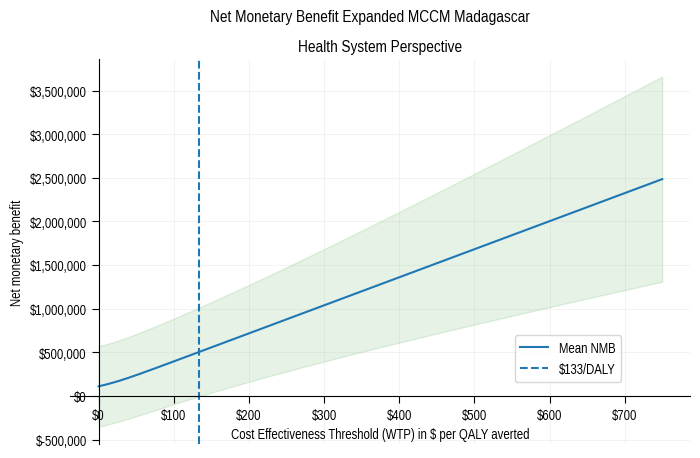

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(cov_df["Lambda"], cov_df['NMB Mean'], label="Mean NMB")
# plt.plot(cov_df["Lambda"], cov_df['Lower 95% CI'], label="Lower 95% CI")
# plt.plot(cov_df["Lambda"], cov_df['Upper 95% CI'], label="Upper 95% CI")
plt.fill_between(cov_df["Lambda"], cov_df['Lower 95% CI'], cov_df['Upper 95% CI'],
                 color="g", alpha=.1, zorder=-2)
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
plt.axvline(133, ls="--", label="$133/DALY")
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.legend(bbox_to_anchor=(.9, .3))
plt.xlabel("Cost Effectiveness Threshold (WTP) in $ per QALY averted")
plt.ylabel("Net monetary benefit")
plt.suptitle("Net Monetary Benefit Expanded MCCM Madagascar")
plt.title("Health System Perspective")
plt.savefig("nmb_hs.png", bbox_inches="tight")

In [ ]:
files.download("nmb_hs.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Generate cost-effectiveness risk aversion curves (CERAC)
- This is also known as Sortino ratios

- use mean NMB

$$ \mu NMB = \mu E.\lambda - \mu C $$
- Generate downward deviation

$$ DD_{NMB} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(NMB_{i} - \mu NMB)^{2}f(t)} $$

- Generate net benefit to risk ratio

$$S_{NMB} = \frac{\mu NMB}{DD_{NMB}} $$

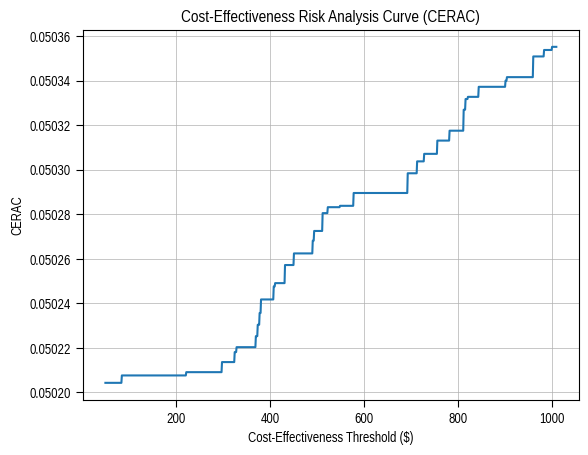

In [ ]:
def cerac(df, cost_col, effect_col, thresholds):
  """
  This function calculates the CERAC for a given dataset and thresholds.

  Args:
      df (pandas.DataFrame): The pandas dataframe containing cost and effect data.
      cost_col (str): The column name for incremental costs.
      effect_col (str): The column name for incremental effects.
      thresholds (list): A list of cost-effectiveness thresholds.

  Returns:
      pandas.DataFrame: A dataframe containing thresholds and corresponding CERAC values.
  """
  cerac_data = []
  for threshold in thresholds:
    filtered_df = df[df[cost_col] <= threshold]
    if len(filtered_df) == 0:
      cerac_value = float('nan')  # Handle cases with no data below threshold
    else:
      downside_risk = df[df[cost_col] > threshold][cost_col].std()
      cerac_value = filtered_df[effect_col].mean() / downside_risk
    cerac_data.append([threshold, cerac_value])

  return pd.DataFrame(cerac_data, columns=["Threshold", "CERAC"])

# Assuming your data is loaded into a pandas dataframe called 'data'
cost_eff_thresholds = range(50, 1010, 1)  # Cost-effectiveness thresholds in increments of 10

cerac_df = cerac(df, "inc_prog", "total_qaly", cost_eff_thresholds)

# Plotting the CERAC curve
plt.plot(cerac_df["Threshold"], cerac_df["CERAC"])
plt.xlabel("Cost-Effectiveness Threshold ($)")
plt.ylabel("CERAC")
plt.title("Cost-Effectiveness Risk Analysis Curve (CERAC)")
plt.grid(True)
plt.show()


In [ ]:
#Inspect distribution of simulated dataset
df.describe().round(2)

hospital_stay  admission_cost  ip_per_diem  ipd_cons_lab  \
count       10000.00        10000.00     10000.00      10000.00   
mean           10.47          105.78         6.50         37.73   
std             2.08           17.34         0.97          3.79   
min             5.21           60.75         3.37         25.38   
25%             9.01           93.50         5.82         35.18   
50%            10.27          104.06         6.45         37.65   
75%            11.71          116.28         7.12         40.19   
max            23.43          214.33        10.81         52.98   

       deaths_averted  admissions_averted  duration_um  duration_sm_overall  \
count        10000.00            10000.00     10000.00             10000.00   
mean           100.21             1727.62         5.09                19.75   
std             24.56             2021.87         0.96                 3.78   
min             39.69               31.10         2.60                 8.73   
25%             82.79              584.63         4.42                17.04   
50%             97.24             1103.29         5.01                19.41   
75%            114.37             2106.95         5.68                22.02   
max            235.44            32015.69        10.09                42.68   

          dw_sm     dw_um  ...  death_costs_1.8  death_costs_1.9  \
count  10000.00  10000.00  ...         10000.00         10000.00   
mean       0.47      0.10  ...        192064.11        178682.23   
std        0.08      0.02  ...         47073.12         43793.35   
min        0.19      0.04  ...         76069.51         70769.44   
25%        0.42      0.09  ...        158667.70        147612.68   
50%        0.47      0.10  ...        186371.53        173386.28   
75%        0.52      0.11  ...        219208.81        203935.65   
max        0.73      0.19  ...        451253.85        419813.18   

       death_costs_2.0  death_costs_2.1  death_costs_2.2  death_costs_2.3  \
count         10000.00         10000.00         10000.00         10000.00   
mean         169589.66        163411.53        159213.69        156361.38   
std           41564.84         40050.64         39021.79         38322.71   
min           67168.21         64721.28         63058.67         61928.98   
25%          140101.14        134997.27        131529.36        129173.01   
50%          164563.20        158568.19        154494.76        151726.99   
75%          193558.01        186506.72        181715.58        178460.16   
max          398450.21        383934.73        374071.91        367370.42   

       death_costs_2.4  death_costs_2.5      nmb_hs    nhb_hs  
count         10000.00         10000.00    10000.00  10000.00  
mean         154423.32        153106.47   501047.99   3767.28  
std           37847.71         37524.97   259645.23   1952.22  
min           61161.38         60639.83  -111600.65   -839.10  
25%          127571.95        126484.08   346350.81   2604.14  
50%          149846.38        148568.56   456063.60   3429.05  
75%          176248.19        174745.23   597139.79   4489.77  
max          362816.97        359723.04  3902475.07  29341.92  

[8 rows x 41 columns]

In [ ]:
df["ip_per_diem"].quantile(.025)

4.745523763666366

In [ ]:
df['death_costs_1.4'].quantile(.975)

543584.153204095

#Health System Perspective Analyses

In [ ]:
icer_avg = df["inc_prog"].mean()/df["total_qaly"].mean()
icer_min = df["inc_prog"].quantile(.975)/df["total_qaly"].quantile(.025)
icer_max = df["inc_prog"].quantile(.025)/df["total_qaly"].quantile(.975)
print("=========================================================================")
print("Health System Perspective")
print(f"The incremental cost effectiveness ratio is ${icer_avg:,.2f} per DALY averted")
print(f"The 95% credibility interval for the ICER is: $[{icer_max:,.2f}, {icer_min:,.2f}] per DALY averted")
print("This ICER value should be assessed against different thresholds")
print("The intervention can be considered cost effective using conventional thresholds")
print("=========================================================================")


Health System Perspective
The incremental cost effectiveness ratio is $-22.84 per DALY averted
The 95% credibility interval for the ICER is: $[-136.05, 97.36] per DALY averted
This ICER value should be assessed against different thresholds
The intervention can be considered cost effective using conventional thresholds


In [ ]:
df["inc_prog"].min()/df["total_qaly"].max()

-441.6502934820876

# Univariate sensitivity analyses
- Loop through every column and return min, mean, max as a dictionary
- Then rerun CEA calculations varying one estimate ceteris paribus

In [ ]:
univ_dict = {}
for column in df.columns:
  col_mean = df[column].mean()
  col_min = df[column].quantile(.025)
  col_max = df[column].quantile(.975)
  univ_dict[column] = {
      "mean" : col_mean,
      "min" : col_min,
      "max" : col_max
  }

univ_df = pd.DataFrame(univ_dict)
univ_df[:]

hospital_stay  admission_cost  ip_per_diem  ipd_cons_lab  \
mean      10.474644      105.775844     6.498251     37.727389   
min        7.035106       77.211651     4.745524     30.494394   
max       15.145173      144.340411     8.540745     45.336170   

      deaths_averted  admissions_averted  duration_um  duration_sm_overall  \
mean      100.209988         1727.619017     5.092037            19.746089   
min        60.827205          163.598109     3.466830            13.387406   
max       157.351000         6860.279243     7.213690            28.060069   

         dw_sm     dw_um  ...  death_costs_1.8  death_costs_1.9  \
mean  0.470177  0.100136  ...    192064.111211    178682.233949   
min   0.326759  0.066338  ...    116582.422734    108459.657569   
max   0.617087  0.140496  ...    301581.514973    280569.120766   

      death_costs_2.0  death_costs_2.1  death_costs_2.2  death_costs_2.3  \
mean    169589.659030    163411.533417    159213.686666    156361.378627   
min     102940.487922     99190.381526     96642.299318     94910.955656   
max     266291.843758    256590.872190    249999.359726    245520.629295   

      death_costs_2.4  death_costs_2.5        nmb_hs       nhb_hs  
mean    154423.322850    153106.473427  5.010480e+05  3767.278152  
min      93734.560772     92935.236551  1.645161e+05  1236.963457  
max     242477.469417    240409.735672  1.126079e+06  8466.762087  

[3 rows x 41 columns]

In [ ]:
# Create an empty dictionary that we will add minimum and maximum values to
univ_sens_dict = {}

In [ ]:
def univariate_sensitivity(df, univ_df, col1, col2, col3):
    """
    Calculate the maximum and minimum incremental cost-effectiveness ratios (ICERs)
    for two different columns in the DataFrame.

    Args:
        df (pandas.DataFrame): The main DataFrame containing the orginal data.
        univ_df (pandas.DataFrame): The DataFrame containing the column values for minimum and maximum.
        column_name1 (str): The name of the first column to use for the minimum and maximum values.
        column_name2 (str): The name of the second column to use for the minimum and maximum values.

    Returns:
        tuple: A tuple containing four values:
            - icer_max1 (float): The maximum ICER for the first column.
            - icer_min1 (float): The minimum ICER for the first column.
            - icer_max2 (float): The maximum ICER for the second column.
            - icer_min2 (float): The minimum ICER for the second column.
    """
    min_val = univ_df[col1].iloc[1]
    max_val = univ_df[col1].iloc[2]

    max_x = df[col2] * max_val
    min_x = df[col2] * min_val

    max_y = df['inc_prog'] + df[col3] - max_x
    min_y = df['inc_prog'] + df[col3] - min_x

    icer_max = np.mean(max_y) / df['total_qaly'].mean()
    icer_min = np.mean(min_y) / df['total_qaly'].mean()

    return icer_max, icer_min

In [ ]:
#Admission costs
result = univariate_sensitivity(df, univ_df, "admission_cost", "admissions_averted", "admissions_costs_averted")
univ_adm_cost_max = result[1]
univ_adm_cost_min = result[0]
univ_sens_dict["Admission Costs"] = {"min": result[0], "max":result[1]}
print(f"One-way sensitivity analysis - admission costs: $[{result[0]:,.2f}, {result[1]:,.2f}]")

One-way sensitivity analysis - admission costs: $[-43.46, -7.38]


In [ ]:
#Admissions averted
result = univariate_sensitivity(df, univ_df,  "admissions_averted", "admission_cost","admissions_costs_averted")
univ_adm_cost_max = result[1]
univ_adm_cost_min = result[0]
univ_sens_dict["Admission Averted"] = {"min": result[0], "max":result[1]}
print(f"One-way sensitivity analysis - admissions averted: $[{result[0]:,.2f}, {result[1]:,.2f}]")

One-way sensitivity analysis - admissions averted: $[-191.60, 28.72]


In [ ]:
#QALYs
univ_qaly_min = df['inc_prog'].mean()/df['total_qaly'].quantile(.975)
univ_qaly_max = df['inc_prog'].mean()/df['total_qaly'].quantile(.025)
univ_sens_dict["Utility"] = {"min": univ_qaly_max, "max":univ_qaly_min}
print(f"One way sensitivity analyses varying QALY: $[{univ_qaly_max:,.2f}, {univ_qaly_min:,.2f}]")

One way sensitivity analyses varying QALY: $[-35.60, -15.11]


In [ ]:
min_val = univ_df["change_opd"].iloc[1]
max_val = univ_df["change_opd"].iloc[2]
min_x = min_val * (opd_costs_2022 + total_rdt + pcm + art_lume +  0.3 *(hemogram + microscopy)) * 1.05
max_x = max_val * (opd_costs_2022 + total_rdt + pcm + art_lume +  0.3 *(hemogram + microscopy)) * 1.05
max_y = df['inc_prog'] + df['opd_costs_averted'] - min_x
min_y = df['inc_prog'] + df['opd_costs_averted'] - max_x
univ_opd_averted_max = np.mean(max_y)/df['total_qaly'].mean()
univ_opd_averted_min = np.mean(min_y)/df['total_qaly'].mean()
print(univ_opd_averted_max)
print(univ_opd_averted_min)
univ_sens_dict["OPD Costs Averted"] = {"min": univ_opd_averted_min, "max":univ_opd_averted_max}

40.32136931808643
-133.2115395062548


In [ ]:
# Inpatient consumables
mean_val = df['admission_cost'] - df['ipd_cons_lab']
min_val = mean_val + univ_df['ipd_cons_lab'][1]
max_val = mean_val + univ_df['ipd_cons_lab'][2]
min_y = df["inc_prog"] + df["admissions_costs_averted"] - (df['admissions_averted'] * max_val)
max_y = df["inc_prog"] + df["admissions_costs_averted"] - (df['admissions_averted'] * min_val)
univ_consum_max = np.mean(max_y)/df['total_qaly'].mean()
univ_consum_min = np.mean(min_y)/df['total_qaly'].mean()
print(univ_consum_min, univ_consum_max)
univ_sens_dict["IP Consumables"] = {"min": univ_consum_min, "max":univ_consum_max}

-26.96148171036271 -18.98618034215965


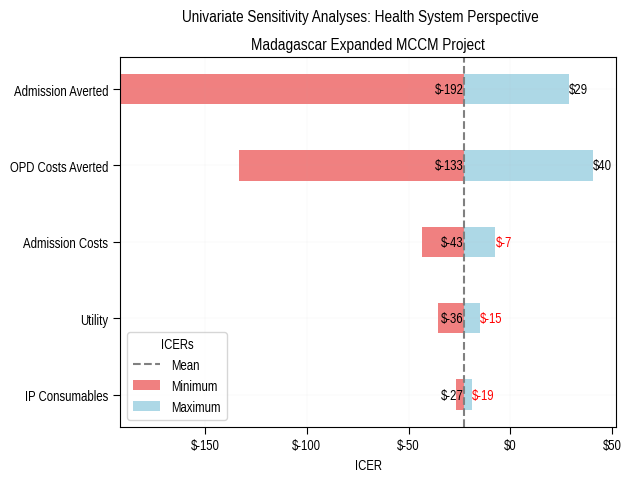

In [ ]:

# Calculate mean value
mean_value = icer_avg
# Calculate the range for each bar and sort the dictionary based on the range
univ_sens_dict = dict(sorted(univ_sens_dict.items(), key=lambda item: item[1]['max'] - item[1]['min'], reverse=False))

# Extract labels, minimum, and maximum values from the dictionary
labels = list(univ_sens_dict.keys())
min_values = [data['min'] for data in univ_sens_dict.values()]
max_values = [data['max'] for data in univ_sens_dict.values()]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot horizontal bars
bar1 = ax.barh(labels, [mean_value - min_val for min_val in min_values], left=min_values,
        color='lightcoral', label='Minimum', height=0.4)
bar2 = ax.barh(labels, [max_val - mean_value for max_val in max_values], left=mean_value,
        color='lightblue', label='Maximum', height=0.4)

# Add mean line
ax.axvline(x=mean_value, color='gray', linestyle='--', label='Mean')

# Add labels, legend, and title
ax.set_xlabel('ICER')
ax.set_ylabel('')
fig.suptitle('Univariate Sensitivity Analyses: Health System Perspective')
ax.set_title("Madagascar Expanded MCCM Project")
ax.legend(title="ICERs")
for rect, min_val, max_val in zip(bar1.patches, min_values, max_values):
    width = rect.get_width()
    ax.text(rect.get_x() + width, rect.get_y() + rect.get_height() / 2,
            f'${min_val:,.0f}', ha='right', va='center', color='black')

for rect, min_val, max_val in zip(bar2.patches, min_values, max_values):
    width = rect.get_width()
    if max_val < 0:
      color = "red"
    else:
      color = "black"
    ax.text(rect.get_x() + width, rect.get_y() + rect.get_height() / 2,
            f'${max_val:,.0f}', ha='left', va='center', color=color)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.grid(lw=.2, alpha=.2)
# Show plot
plt.savefig("tornado_hs_no_comp.png", bbox_inches="tight")
plt.show()

In [ ]:
files.download("tornado_hs_no_comp.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Simulate a range of potential CHV compensations per year
# Average nurse salary per year is $2770.00
# CHV salaries pegged at a maximum of 50% of this value

for i in range(1, 151):
  df[f"IC_{i}"] = (number_of_chws * i * 12) + df['inc_prog']
df[:5]

hospital_stay  admission_cost  ip_per_diem  ipd_cons_lab  deaths_averted  \
0      13.142460      132.255318     6.796196     42.936577      106.166200   
1       8.817061       83.663635     5.507104     35.107160       76.598627   
2       8.282067       81.714584     4.933800     40.852525       74.210107   
3      11.536368      108.463854     6.158990     37.411482      123.811453   
4      11.254350      138.435800     8.538693     42.338363       69.125520   

   admissions_averted  duration_um  duration_sm_overall     dw_sm     dw_um  \
0         1292.095371     6.436599            14.621049  0.464187  0.095752   
1          337.777094     6.486283            23.591065  0.380239  0.090541   
2         1340.971573     5.507120            22.246433  0.431016  0.116262   
3          203.292477     4.349772            18.679459  0.434847  0.084550   
4          634.149056     4.671859            19.889661  0.409372  0.101087   

   ...        IC_141        IC_142        IC_143        IC_144        IC_145  \
0  ...  9.330151e+05  9.405031e+05  9.479911e+05  9.554791e+05  9.629671e+05   
1  ...  1.175352e+06  1.182840e+06  1.190328e+06  1.197816e+06  1.205304e+06   
2  ...  1.007268e+06  1.014756e+06  1.022244e+06  1.029732e+06  1.037220e+06   
3  ...  1.218346e+06  1.225834e+06  1.233322e+06  1.240810e+06  1.248298e+06   
4  ...  1.007402e+06  1.014890e+06  1.022378e+06  1.029866e+06  1.037354e+06   

         IC_146        IC_147        IC_148        IC_149        IC_150  
0  9.704551e+05  9.779431e+05  9.854311e+05  9.929191e+05  1.000407e+06  
1  1.212792e+06  1.220280e+06  1.227768e+06  1.235256e+06  1.242744e+06  
2  1.044708e+06  1.052196e+06  1.059684e+06  1.067172e+06  1.074660e+06  
3  1.255786e+06  1.263274e+06  1.270762e+06  1.278250e+06  1.285738e+06  
4  1.044842e+06  1.052330e+06  1.059818e+06  1.067306e+06  1.074794e+06  

[5 rows x 191 columns]

In [ ]:
df["IC_100"].quantile(.025)/df["total_qaly"].mean()

27.163456449173676

In [ ]:
df["IC_100"].mean()/df["total_qaly"].mean()

210.06025792774017

In [ ]:
df["IC_100"].quantile(.975)/df["total_qaly"].mean()

295.3870047580376

In [ ]:
threshold = 133 # CET estimated
proportions = []

for i in range(1, 101):
    column_name = f"IC_{i}"
    proportion = ((df[column_name]/df["total_qaly"])  < threshold).mean()
    proportions.append(proportion)

print(proportions)

[0.9992, 0.9992, 0.9989, 0.9988, 0.9987, 0.9984, 0.9982, 0.9981, 0.9976, 0.9967, 0.9958, 0.9947, 0.9941, 0.9933, 0.991, 0.9899, 0.9878, 0.9858, 0.9832, 0.9804, 0.9776, 0.9749, 0.9711, 0.9666, 0.9616, 0.9567, 0.9531, 0.9471, 0.9412, 0.9342, 0.9256, 0.9175, 0.9092, 0.9011, 0.8907, 0.8808, 0.8696, 0.8598, 0.8468, 0.8339, 0.8199, 0.8094, 0.7961, 0.7834, 0.7688, 0.7527, 0.7366, 0.7194, 0.705, 0.6881, 0.6716, 0.6519, 0.6357, 0.6176, 0.6023, 0.5858, 0.5666, 0.548, 0.5325, 0.5159, 0.498, 0.483, 0.4652, 0.4492, 0.4335, 0.4198, 0.405, 0.3918, 0.3771, 0.364, 0.3508, 0.3373, 0.3235, 0.3128, 0.2999, 0.2876, 0.2764, 0.267, 0.257, 0.2467, 0.2372, 0.2275, 0.2181, 0.209, 0.2006, 0.1927, 0.1846, 0.1779, 0.1727, 0.1655, 0.1603, 0.1534, 0.1468, 0.1406, 0.1349, 0.1292, 0.1252, 0.1205, 0.1162, 0.1128]


In [ ]:
y = [abs(x - 1) for x in proportions]
len(y)

100

## Checking uncertainty (probability cost effetive) by different CEA thresholds
- Check if this varies by potential CHV compensation in increments of \$1 from \$0 to \$100
- This will be used to check
- Then plot cost effectiveness acceptability curves
- Do this for the health system as well as the societal perspectives



In [ ]:
# Select thresholds between 1 and 1000
thresholds = list(range(1,1001))
# Generate empty lists suffixed by potential compensation
probs_1 = []
probs_30 = []
probs_50 = []
probs_75 = []
probs_100 = []
probs_125 = []
probs_150 = []
# Generate a list of x values that will be used as the x-axis
x = np.arange(1,1001)
for threshold in thresholds:
  proportions = ((df["IC_1"] / df["total_qaly"]) < threshold).mean()
  probs_1.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_30"] / df["total_qaly"]) < threshold).mean()
  probs_30.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_50"] / df["total_qaly"]) < threshold).mean()
  probs_50.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_75"] / df["total_qaly"]) < threshold).mean()
  probs_75.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_100"] / df["total_qaly"]) < threshold).mean()
  probs_100.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_125"] / df["total_qaly"]) < threshold).mean()
  probs_125.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_150"] / df["total_qaly"]) < threshold).mean()
  probs_150.append(proportions)

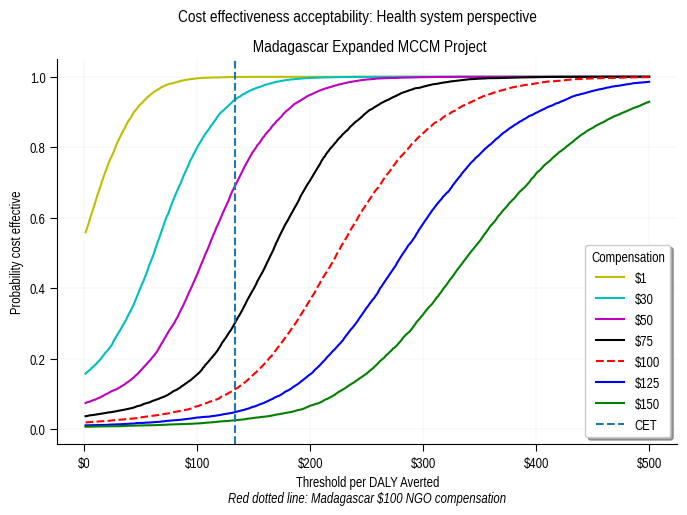

In [ ]:
# Plot the graphs
fig, ax = plt.subplots(figsize=(8,5), dpi=100)
plt.plot(x[:500], probs_1[:500], color="y", label="$1")
plt.plot(x[:500], probs_30[:500], color="c", label="$30")
plt.plot(x[:500], probs_50[:500], color="m", label="$50")
plt.plot(x[:500], probs_75[:500], color="k",  label="$75")
plt.plot(x[:500], probs_100[:500], color="r", ls="--", label="$100")
plt.plot(x[:500], probs_125[:500], color="b", label="$125")
plt.plot(x[:500], probs_150[:500], color="g", label="$150")
plt.grid(axis="both", lw=.3, alpha=.3)
plt.suptitle("Cost effectiveness acceptability: Health system perspective")
plt.axvline(133, ls="--", label="CET")

plt.title(" Madagascar Expanded MCCM Project")
plt.ylabel("Probability cost effective")
plt.xlabel("Threshold per DALY Averted")
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.legend(loc="lower right", title="Compensation", fancybox=True, shadow=True)
ax.text(.5, -.15, "Red dotted line: Madagascar $100 NGO compensation",
        ha="center", transform=ax.transAxes,
        fontdict={'style':'italic'});
plt.savefig("ceac_hs.png", bbox_inches="tight");

In [ ]:
files.download("ceac_hs.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The $63 rate is currently being used in [Malawi](https://chwcentral.org/malawis-community-health-worker-program/)

A project in Madagascar used $100 but stopped - personal communication Andres

##Cost effectiveness affordability curve (CEAFC)
- Farafangana population 436,226
- Assume increased capitation in increments of \$.50 to \$2.50
- Check probability against this threshold
- Check for \$1, \$50 & \$100 compensation

In [ ]:
#$1 compensation
budget = list(range(0, 300_000, 25_000))
thresholds = list(range(0,750,1))
data =[]
for i in budget:
  proportions = []
  for threshold in thresholds:
    proportion_below_budget = (df["IC_1"] < i).mean()
    proportion_below_threshold = ((df["IC_1"]/df["total_qaly"]) < threshold).mean()
    proportion = proportion_below_threshold * proportion_below_budget
    proportions.append(proportion)
  data.append(proportions)
cols = [f"CEAFC_{i}" for i in thresholds]
df3 = pd.DataFrame(data, index=budget, columns=cols)
df3 = df3.T
df3 = df3.add_prefix("CEAFC_")
df3.reset_index(drop=True, inplace=True)
df3[:5]

CEAFC_0  CEAFC_25000  CEAFC_50000  CEAFC_75000  CEAFC_100000  \
0  0.302170     0.344002     0.385779     0.425358      0.458890   
1  0.307062     0.349572     0.392025     0.432245      0.466319   
2  0.311570     0.354703     0.397780     0.438590      0.473165   
3  0.316902     0.360774     0.404588     0.446096      0.481262   
4  0.322564     0.367219     0.411816     0.454066      0.489861   

   CEAFC_125000  CEAFC_150000  CEAFC_175000  CEAFC_200000  CEAFC_225000  \
0      0.485165      0.506604      0.521775      0.533594      0.540630   
1      0.493020      0.514806      0.530223      0.542233      0.549383   
2      0.500258      0.522363      0.538007      0.550193      0.557448   
3      0.508819      0.531302      0.547214      0.559609      0.566988   
4      0.517910      0.540795      0.556991      0.569607      0.577118   

   CEAFC_250000  CEAFC_275000  
0      0.544698      0.546732  
1      0.553517      0.555584  
2      0.561642      0.563739  
3      0.571254      0.573387  
4      0.581460      0.583631

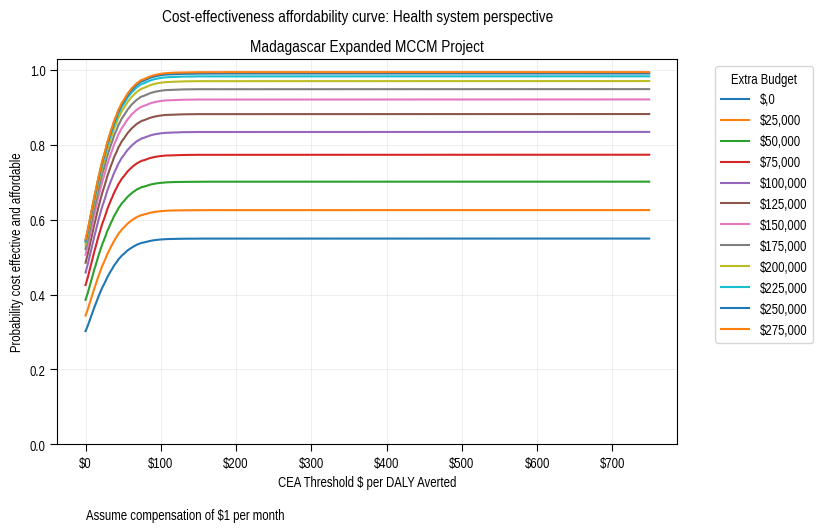

In [ ]:
colnames = df3.columns.tolist()
colnames = ["${},{}".format(re.sub(r'(\d+)(\d{3})', r'\1,\2', name.split("_")[1][:-3]), name.split("_")[1][-3:]) for name in colnames]
df3.plot(figsize=(8,5))
plt.ylim(ymin=0)
plt.ylabel("Probability cost effective and affordable")
plt.xlabel("CEA Threshold $ per DALY Averted")
plt.grid(alpha=.3)
plt.suptitle("Cost-effectiveness affordability curve: Health system perspective")
plt.title("Madagascar Expanded MCCM Project")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.legend(title="Extra Budget", labels=colnames, bbox_to_anchor=(1.05,1))

plt.text(0, -0.2, "Assume compensation of $1 per month")
plt.savefig("ceafc_hs_1.png", bbox_inches="tight")

In [ ]:
files.download("ceafc_hs_1.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# $50 compensation
budget = list(range(0, 1_250_000, 100_000))
thresholds = list(range(0,750,1))
data =[]
for i in budget:
  proportions = []
  for threshold in thresholds:
    proportion_below_budget = (df["IC_50"] < i).mean()
    proportion_below_threshold = ((df["IC_50"]/df["total_qaly"]) < threshold).mean()
    proportion = proportion_below_threshold * proportion_below_budget
    proportions.append(proportion)
  data.append(proportions)
cols = [f"CEAFC_{i}" for i in thresholds]
df3 = pd.DataFrame(data, index=budget, columns=cols)
df3 = df3.T
df3 = df3.add_prefix("CEAFC_")
df3.reset_index(drop=True, inplace=True)
df3[:5]

CEAFC_0  CEAFC_100000  CEAFC_200000  CEAFC_300000  CEAFC_400000  \
0  0.005402      0.008636      0.015023      0.027342      0.047907   
1  0.005446      0.008707      0.015146      0.027565      0.048298   
2  0.005579      0.008918      0.015514      0.028235      0.049472   
3  0.005645      0.009024      0.015698      0.028570      0.050058   
4  0.005704      0.009118      0.015861      0.028867      0.050580   

   CEAFC_500000  CEAFC_600000  CEAFC_700000  CEAFC_800000  CEAFC_900000  \
0      0.065981      0.072486      0.073426      0.073493        0.0735   
1      0.066520      0.073077      0.074026      0.074093        0.0741   
2      0.068135      0.074853      0.075824      0.075892        0.0759   
3      0.068943      0.075740      0.076723      0.076792        0.0768   
4      0.069662      0.076529      0.077522      0.077592        0.0776   

   CEAFC_1000000  CEAFC_1100000  CEAFC_1200000  
0         0.0735         0.0735         0.0735  
1         0.0741         0.0741         0.0741  
2         0.0759         0.0759         0.0759  
3         0.0768         0.0768         0.0768  
4         0.0776         0.0776         0.0776

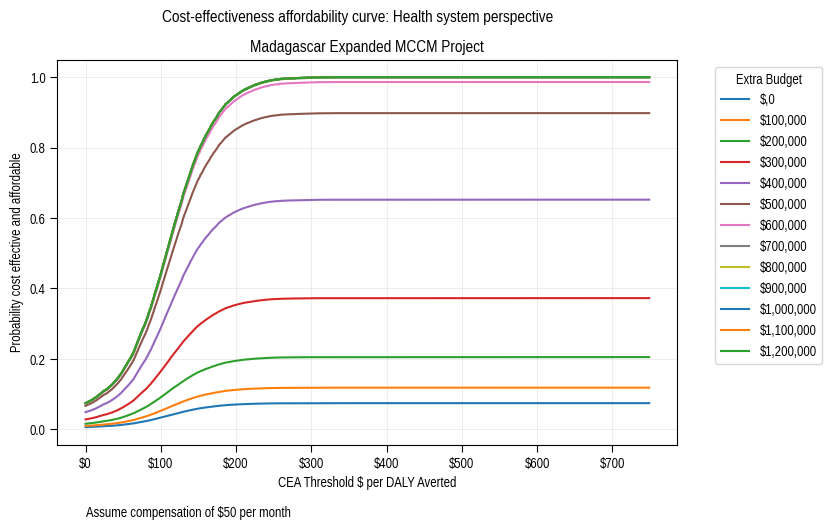

In [ ]:
colnames = df3.columns.tolist()
colnames = ["${},{}".format(re.sub(r'(\d+)(\d{3})', r'\1,\2', name.split("_")[1][:-3]), name.split("_")[1][-3:]) for name in colnames]
df3.plot(figsize=(8,5))
plt.ylabel("Probability cost effective and affordable")
plt.xlabel("CEA Threshold $ per DALY Averted")
plt.grid(alpha=.3)
plt.suptitle("Cost-effectiveness affordability curve: Health system perspective")
plt.title("Madagascar Expanded MCCM Project")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
# plt.legend(title="Extra Budget",
#            labels=["$0","$250K", "$500K", "$750K",  "$1 million", ])
plt.legend(title="Extra Budget", labels=colnames, bbox_to_anchor=(1.05,1))
plt.text(0, -0.25, "Assume compensation of $50 per month")
plt.savefig("ceafc_hs_50.png", bbox_inches="tight")

In [ ]:
files.download("ceafc_hs_50.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# $100 compensation
budget = list(range(0, 1_250_000, 100_000))
thresholds = list(range(0,750,1))
data =[]
for i in budget:
  proportions = []
  for threshold in thresholds:
    proportion_below_budget = (df["IC_100"] < i).mean()
    proportion_below_threshold = ((df["IC_100"]/df["total_qaly"]) < threshold).mean()
    proportion = proportion_below_threshold * proportion_below_budget
    proportions.append(proportion)
  data.append(proportions)
cols = [f"CEAFC_{i}" for i in thresholds]
df3 = pd.DataFrame(data, index=budget, columns=cols)
df3 = df3.T
df3 = df3.add_prefix("CEAFC_")
df3.reset_index(drop=True, inplace=True)
df3[:]


CEAFC_0  CEAFC_100000  CEAFC_200000  CEAFC_300000  CEAFC_400000  \
0    0.000353      0.000487      0.000728      0.001028      0.001543   
1    0.000359      0.000495      0.000739      0.001045      0.001568   
2    0.000365      0.000502      0.000751      0.001061      0.001593   
3    0.000374      0.000515      0.000770      0.001089      0.001634   
4    0.000376      0.000518      0.000774      0.001094      0.001642   
..        ...           ...           ...           ...           ...   
745  0.018800      0.025900      0.038700      0.054700      0.082100   
746  0.018800      0.025900      0.038700      0.054700      0.082100   
747  0.018800      0.025900      0.038700      0.054700      0.082100   
748  0.018800      0.025900      0.038700      0.054700      0.082100   
749  0.018800      0.025900      0.038700      0.054700      0.082100   

     CEAFC_500000  CEAFC_600000  CEAFC_700000  CEAFC_800000  CEAFC_900000  \
0        0.002538      0.004444      0.008202      0.013713      0.017518   
1        0.002579      0.004515      0.008333      0.013932      0.017797   
2        0.002619      0.004586      0.008464      0.014150      0.018077   
3        0.002687      0.004704      0.008682      0.014515      0.018543   
4        0.002700      0.004728      0.008726      0.014588      0.018636   
..            ...           ...           ...           ...           ...   
745      0.135000      0.236400      0.436300      0.729400      0.931800   
746      0.135000      0.236400      0.436300      0.729400      0.931800   
747      0.135000      0.236400      0.436300      0.729400      0.931800   
748      0.135000      0.236400      0.436300      0.729400      0.931800   
749      0.135000      0.236400      0.436300      0.729400      0.931800   

     CEAFC_1000000  CEAFC_1100000  CEAFC_1200000  
0         0.018650       0.018791         0.0188  
1         0.018947       0.019090         0.0191  
2         0.019245       0.019390         0.0194  
3         0.019741       0.019890         0.0199  
4         0.019840       0.019990         0.0200  
..             ...            ...            ...  
745       0.992000       0.999500         1.0000  
746       0.992000       0.999500         1.0000  
747       0.992000       0.999500         1.0000  
748       0.992000       0.999500         1.0000  
749       0.992000       0.999500         1.0000  

[750 rows x 13 columns]

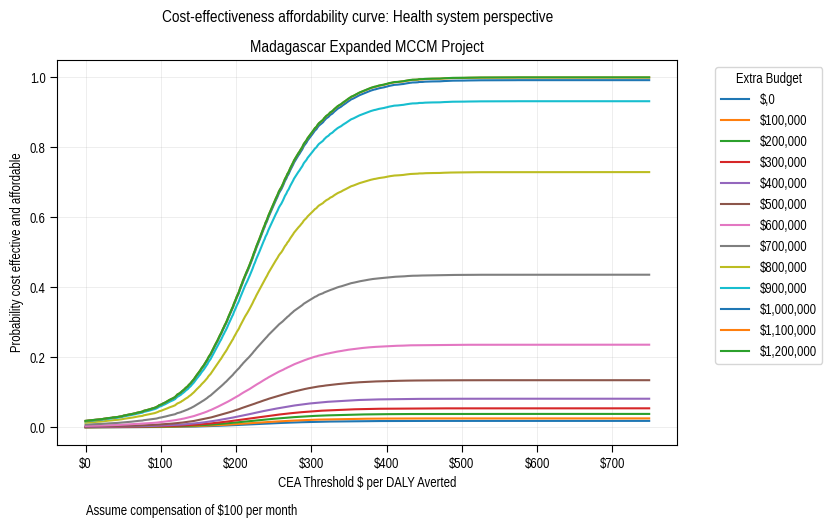

In [ ]:
colnames = df3.columns.tolist()
colnames = ["${},{}".format(re.sub(r'(\d+)(\d{3})', r'\1,\2', name.split("_")[1][:-3]), name.split("_")[1][-3:]) for name in colnames]
df3.plot(figsize=(8,5))
plt.ylabel("Probability cost effective and affordable")
plt.xlabel("CEA Threshold $ per DALY Averted")
plt.grid(alpha=.3)
plt.suptitle("Cost-effectiveness affordability curve: Health system perspective")
plt.title("Madagascar Expanded MCCM Project")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
# plt.legend(title="Extra Budget",
#            labels=["$0","$250K", "$500K", "$750K",  "$1 million", ])
plt.legend(title="Extra Budget", labels=colnames, bbox_to_anchor=(1.05,1))
plt.text(0, -0.25, "Assume compensation of $100 per month")
plt.savefig("ceafc_hs_100.png", bbox_inches="tight")

In [ ]:
files.download("ceafc_hs_100.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Rerun to see appropriate compensation by CE threshold**
- Breakeven analysis for different salaries

In [ ]:
thresholds = [50, 100, 133, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650]
data = []

for threshold in thresholds:
    proportions = []
    for i in range(1, 151):
        column_name = f"IC_{i}"
        proportion = ((df[column_name] / df["total_qaly"]) < threshold).mean()
        proportions.append(proportion)
    data.append(proportions)

columns = [f"IC_{i}" for i in range(1, 151)]
result_df = pd.DataFrame(data, index=thresholds, columns=columns)
df2 = result_df.T
df2 = df2.add_prefix("CET_")
compensation = df2.index
df2 = df2.reset_index(drop=True)
#df2 = df2.reset_index(drop=False).rename(columns={"index":"Compensation"})
df2[:5]

CET_50  CET_100  CET_133  CET_150  CET_200  CET_250  CET_300  CET_350  \
0  0.9231   0.9955   0.9992   0.9997      1.0      1.0      1.0      1.0   
1  0.9136   0.9945   0.9992   0.9997      1.0      1.0      1.0      1.0   
2  0.9039   0.9933   0.9989   0.9996      1.0      1.0      1.0      1.0   
3  0.8908   0.9920   0.9988   0.9994      1.0      1.0      1.0      1.0   
4  0.8794   0.9900   0.9987   0.9994      1.0      1.0      1.0      1.0   

   CET_400  CET_450  CET_500  CET_550  CET_600  CET_650  
0      1.0      1.0      1.0      1.0      1.0      1.0  
1      1.0      1.0      1.0      1.0      1.0      1.0  
2      1.0      1.0      1.0      1.0      1.0      1.0  
3      1.0      1.0      1.0      1.0      1.0      1.0  
4      1.0      1.0      1.0      1.0      1.0      1.0

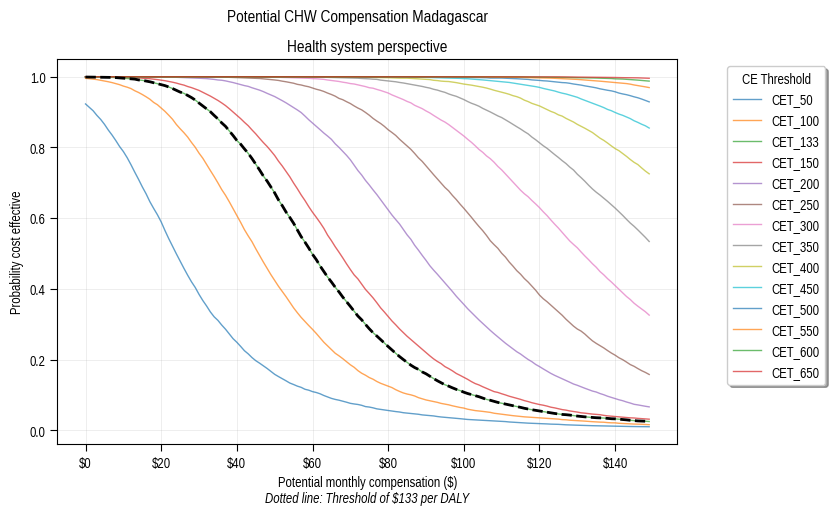

In [ ]:
fig, ax = plt.subplots(figsize=(8,5), dpi=100)
idx1 = (df2['CET_133'] - .8).abs().idxmin()
idx2 = (df2['CET_133'] - .5).abs().idxmin()
for col in df2.columns:
  df2[col].plot(kind="line", x=df2.index, label=col, lw=1, alpha=.7)

plt.plot(df2.index, df2['CET_133'], linestyle="--", lw=2, color="k")
plt.ylabel("Probability cost effective")
plt.xlabel("Potential monthly compensation ($)")
plt.suptitle("Potential CHW Compensation Madagascar")
plt.title("Health system perspective")
plt.legend(loc="upper right", bbox_to_anchor=(1.25,1),
           title="CE Threshold", shadow=True)
# Apply the formatter to the x-axis
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.grid(alpha=.3, lw=.5)
ax.text(0.5,-.15, "Dotted line: Threshold of $133 per DALY",
         ha="center", fontdict={'style':'italic'},
        transform=ax.transAxes)
# Show the plot
plt.savefig("breakeven_hs.png", bbox_inches="tight")
plt.show();


In [ ]:
files.download("breakeven_hs.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Draw cost-effectiveness analysis planes

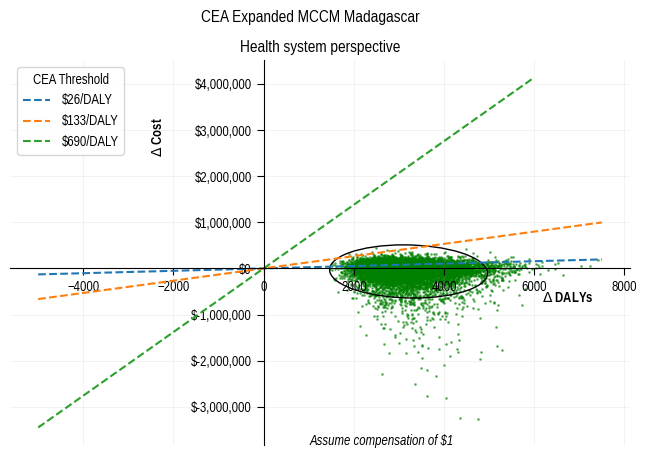

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(df["total_qaly"], df["IC_1"],s=1, color="g", alpha=.5)
l1, = ax.plot([-5_000, 7_500], [-130_000, 195_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 7_500], [-665_000, 997_500], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.xlabel("")

# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values
y = df['IC_1'].values

ci_ellipse(x, y)

plt.ylabel(r'$\Delta$ Cost', fontweight="bold")  # Using the raw string literal r'' and LaTeX syntax for delta
ax.yaxis.set_label_coords(0.25, .8)
plt.xlabel(r'$\Delta$ DALYs', fontweight="bold")
ax.xaxis.set_label_coords(0.9, 0.40)
plt.suptitle("CEA Expanded MCCM Madagascar")
plt.title("Health system perspective")
ax.text(0.6, 0, "Assume compensation of $1", ha="center",
        fontdict={'style':'italic'}, transform=ax.transAxes)
plt.legend(title="CEA Threshold", loc="best")
plt.savefig("ceplane_1_hs.png", bbox_inches="tight")
plt.show();

In [ ]:
files.download("ceplane_1_hs.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
above_t = np.sum([df["IC_1"]/df['total_qaly']<26])/100
print("=========================================================================")
print(f"Using a CEA threshold of $133/DALY, there is a {above_t}% probability \nthe intervention is cost effective.")
print("=========================================================================")

Using a CEA threshold of $133/DALY, there is a 78.77% probability 
the intervention is cost effective.


##Create a Pandas Dataframe for probability of cost effectiveness
Health sector perspective

In [ ]:
comp_ranges = list(range(5,155,5))
comp_ranges.insert(0, 1)
comp_str = ["$"+str(i) for i in comp_ranges]
cets = list(range(50, 700, 50))
cets.insert(0, 26)
cets.insert(3, 133)
comp_hs_df = pd.DataFrame({"Compensation": comp_str})
for j in cets:
  below_t = []
  for i in comp_ranges:
    val = str(np.round(np.sum([df[f"IC_{i}"]/df["total_qaly"]<j])/100,1))+"%"
    below_t.append(val)
  comp_hs_df[f"CET_${j}"] = below_t
comp_hs_df[:5]

Compensation CET_$26 CET_$50 CET_$100 CET_$133 CET_$150 CET_$200 CET_$250  \
0           $1   78.8%   92.3%    99.6%    99.9%   100.0%   100.0%   100.0%   
1           $5   71.1%   87.9%    99.0%    99.9%    99.9%   100.0%   100.0%   
2          $10   60.2%   80.3%    97.8%    99.7%    99.9%   100.0%   100.0%   
3          $15   48.9%   71.0%    95.6%    99.1%    99.7%   100.0%   100.0%   
4          $20   39.3%   61.0%    92.1%    98.0%    99.2%    99.9%   100.0%   

  CET_$300 CET_$350 CET_$400 CET_$450 CET_$500 CET_$550 CET_$600 CET_$650  
0   100.0%   100.0%   100.0%   100.0%   100.0%   100.0%   100.0%   100.0%  
1   100.0%   100.0%   100.0%   100.0%   100.0%   100.0%   100.0%   100.0%  
2   100.0%   100.0%   100.0%   100.0%   100.0%   100.0%   100.0%   100.0%  
3   100.0%   100.0%   100.0%   100.0%   100.0%   100.0%   100.0%   100.0%  
4   100.0%   100.0%   100.0%   100.0%   100.0%   100.0%   100.0%   100.0%

In [ ]:
comp_hs_df.to_csv("comp_hs_df.csv")
files.download("comp_hs_df.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Repeat with a compensation value of $50 **

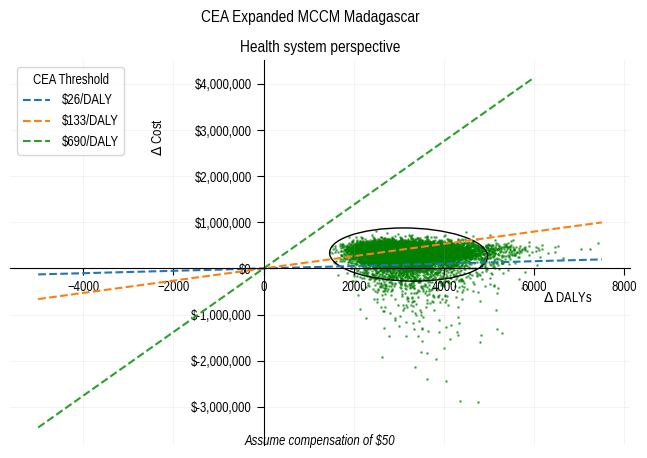

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(df["total_qaly"], df["IC_50"],s=1, color="g", alpha=.5)
l1, = ax.plot([-5_000, 7_500], [-130_000, 195_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 7_500], [-665_000, 997_500], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.xlabel("")

# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values
y = df['IC_50'].values

ci_ellipse(x, y)
plt.ylabel(r'$\Delta$ Cost')  # Using the raw string literal r'' and LaTeX syntax for delta
ax.yaxis.set_label_coords(0.25, 0.80)
plt.xlabel(r'$\Delta$ DALYs')
ax.xaxis.set_label_coords(0.9, 0.40)
plt.suptitle("CEA Expanded MCCM Madagascar")
plt.title("Health system perspective")
ax.text(0.5, 0, "Assume compensation of $50", ha="center",
        fontdict={'style':'italic'}, transform=ax.transAxes)
plt.legend(title="CEA Threshold", loc="best")

plt.show();

In [ ]:
above_t = np.sum([df["IC_50"]/df['total_qaly']<133])/100
print("=========================================================================")
print(f"Using a CEA threshold of $300/DALY, there is a {above_t}% probability \nthe intervention is cost effective.")
print("=========================================================================")

Using a CEA threshold of $300/DALY, there is a 68.81% probability 
the intervention is cost effective.


**Repeat with compensation of $63 similar to Malawi pilot**

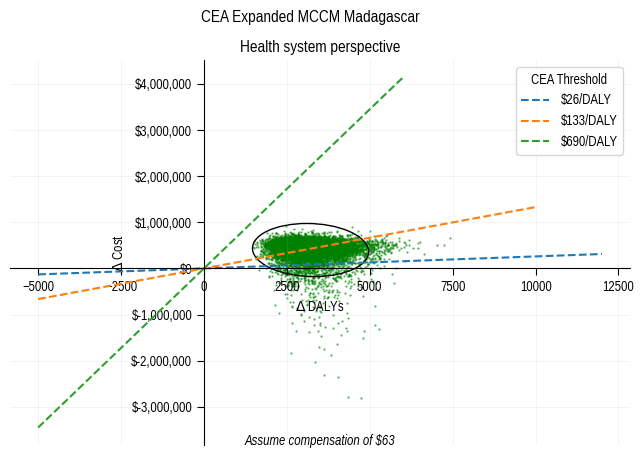

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(df["total_qaly"], df["IC_63"],s=.5, color="g", alpha=.5)

l1, = ax.plot([-5_000, 12_000], [-130_000, 312_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 10_000], [-665_000, 1_330_000], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.xlabel("")

# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values
y = df['IC_63'].values

ci_ellipse(x, y)
plt.ylabel(r'$\Delta$ Cost')  # Using the raw string literal r'' and LaTeX syntax for delta
plt.xlabel(r'$\Delta$ DALYs')
plt.suptitle("CEA Expanded MCCM Madagascar")
plt.title("Health system perspective")
ax.text(0.5, 0, "Assume compensation of $63", ha="center",
        fontdict={'style':'italic'}, transform=ax.transAxes)
plt.legend(title="CEA Threshold", loc="best")

plt.show();

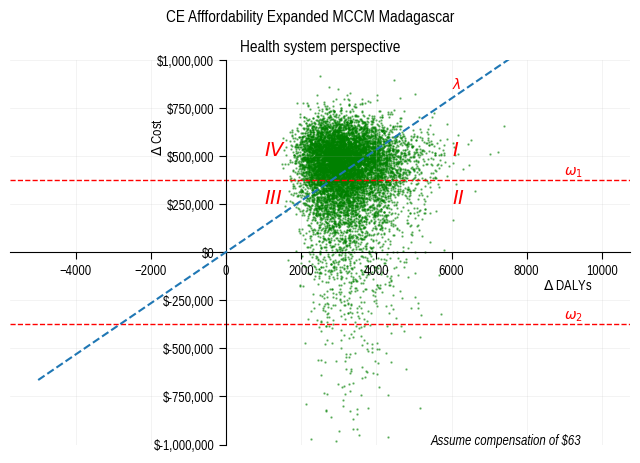

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(df["total_qaly"], df["IC_63"],s=.5, color="g", alpha=.5)

# l1, = ax.plot([-5_000, 12_000], [-130_000, 312_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 10_000], [-665_000, 1_330_000], label="$133/DALY", ls="--", zorder=3)
# l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))

plt.text(9_000, 400_000, r'$\omega_1$', color="r", fontweight="bold")
plt.axhline(375_000, color="r", ls="--", lw=1, label="Budget")
plt.text(9_000, -350_000, r'$\omega_2$', color="r", fontweight="bold")
plt.axhline(-375_000, color="r", ls="--", lw=1, )

plt.ylim(-1_000_000, 1_000_000)

plt.text(6_000, 850_000, r'$\lambda$', color="r", fontweight="bold")
plt.text(6_000, 500_000, r'$\mathit{I}$', color="r", fontweight="bold", fontsize=14)
plt.text(6_000, 250_000, r'$\mathit{II}$', color="r", fontweight="bold", fontsize=14)
plt.text(1_000, 250_000, r'$\mathit{III}$', color="r", fontweight="bold", fontsize=14)
plt.text(1_000, 500_000, r'$\mathit{IV}$', color="r", fontweight="bold", fontsize=14)

plt.ylabel(r'$\Delta$ Cost')
ax.yaxis.set_label_coords(0.25, 0.80)
plt.xlabel(r'$\Delta$ DALYs')
ax.xaxis.set_label_coords(0.9, 0.43)
plt.suptitle("CE Afffordability Expanded MCCM Madagascar")
plt.title("Health system perspective")
ax.text(0.8, 0, "Assume compensation of $63", ha="center",
        fontdict={'style':'italic'}, transform=ax.transAxes)
# plt.legend(title="CEA Threshold", loc="best")
plt.savefig("ceafc_demo.png", bbox_inches="tight")
plt.show();

In [ ]:
files.download("ceafc_demo.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
result = sum([1 for _, row in df.iterrows() if (row["IC_63"] / row["total_qaly"] < 133) and (row["IC_63"] < 10000)]) / 100
result

5.22

In [ ]:
above_t = np.sum([df["IC_63"]/df['total_qaly']<133])/100
print("=========================================================================")
print(f"Using a CEA threshold of $133/DALY, there is a {above_t}% probability \nthe intervention is cost effective.")
print("=========================================================================")

Using a CEA threshold of $133/DALY, there is a 46.52% probability 
the intervention is cost effective.


**Repeat with compensation of $100**

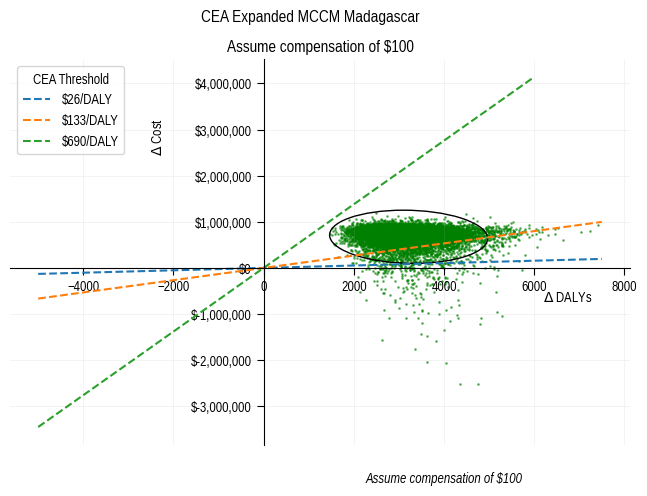

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(df["total_qaly"], df["IC_100"],s=1, color="g", alpha=.5)

l1, = ax.plot([-5_000, 7_500], [-130_000, 195_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 7_500], [-665_000, 997_500], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.xlabel("")

# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values
y = df['IC_100'].values

ci_ellipse(x, y)
plt.ylabel(r'$\Delta$ Cost')  # Using the raw string literal r'' and LaTeX syntax for delta
ax.yaxis.set_label_coords(0.25, 0.80)
plt.xlabel(r'$\Delta$ DALYs')
ax.xaxis.set_label_coords(0.9, 0.40)
plt.suptitle("CEA Expanded MCCM Madagascar")
plt.title("Assume compensation of $100")
plt.legend(title="CEA Threshold", loc="upper left")
ax.text(0.7, -0.1, "Assume compensation of $100", ha="center",
        fontdict={'style':'italic'}, transform=ax.transAxes)
plt.savefig("hs_ceplane.png", bbox_inches="tight")
plt.show();

In [ ]:
files.download("hs_ceplane.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
above_t = np.sum([df["IC_100"]/df['total_qaly']<133])/100
print("=========================================================================")
print(f"Using a CEA threshold of $133/DALY, there is a {above_t}% probability \nthe intervention is cost effective.")
print("=========================================================================")

Using a CEA threshold of $133/DALY, there is a 11.28% probability 
the intervention is cost effective.


**Combined CEA Plane**

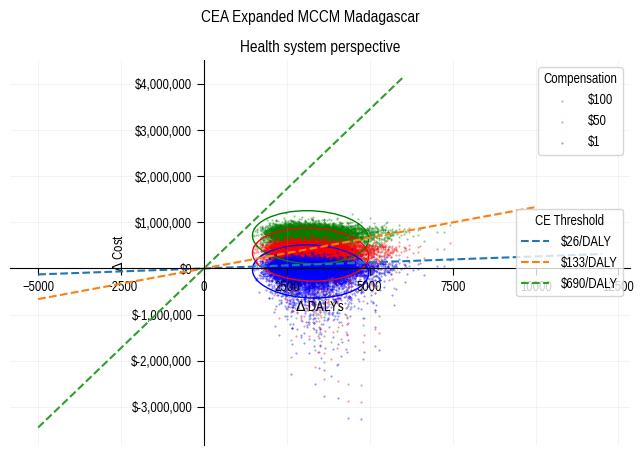

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sc1 = ax.scatter(df["total_qaly"], df["IC_100"],s=.2, color="g", alpha=.5, label="$100")
sc2 = ax.scatter(df["total_qaly"], df["IC_50"] ,s=.2, color="r", alpha=.5,label="$50")
sc3 = ax.scatter(df["total_qaly"], df["IC_1"]  ,s=.2, color="b", alpha=.5,label="$1")

l1, = ax.plot([-5_000, 12_000], [-130_000, 312_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 10_000], [-665_000, 1_330_000], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")

for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.xlabel("")

# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values
y1 = df['IC_100'].values
y2 = df['IC_50'].values
y3 = df['IC_1'].values

ci_ellipse(x, y1, edgecolor="g")
ci_ellipse(x, y2, edgecolor="r")
ci_ellipse(x, y3, edgecolor="b")

plt.ylabel(r'$\Delta$ Cost')  # Using the raw string literal r'' and LaTeX syntax for delta
plt.xlabel(r'$\Delta$ DALYs')
plt.suptitle("CEA Expanded MCCM Madagascar")
plt.title("Health system perspective")

#plt.legend(title="CEA Threshold", loc="upper right")
leg1 = ax.legend(handles=[sc1, sc2, sc3], loc="upper right", title="Compensation")
ax.add_artist(leg1)
leg2 = ax.legend(handles=[l1, l2, l3], loc ="center right", title="CE Threshold")
plt.show();

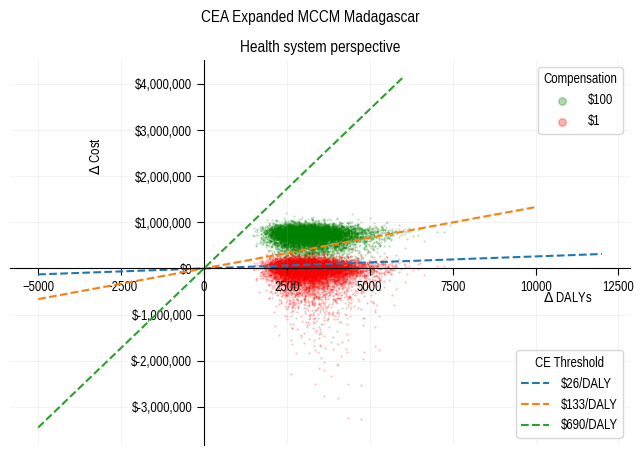

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sc1 = ax.scatter(df["total_qaly"], df["IC_100"],s=.2, color="g", alpha=.3, label="$100")
#sc2 = ax.scatter(df["total_qaly"], df["IC_50"] ,s=.2, color="r", alpha=.5,label="$50")
sc3 = ax.scatter(df["total_qaly"], df["IC_1"]  ,s=.2, color="r", alpha=.3,label="$1")

l1, = ax.plot([-5_000, 12_000], [-130_000, 312_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 10_000], [-665_000, 1_330_000], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")

for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.xlabel("")

# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values
y1 = df['IC_100'].values
#y2 = df['IC_50'].values
y3 = df['IC_1'].values

# ci_ellipse(x, y1, edgecolor="g")
#ci_ellipse(x, y2, edgecolor="r")
# ci_ellipse(x, y3, edgecolor="b")

plt.ylabel(r'$\Delta$ Cost')  # Using the raw string literal r'' and LaTeX syntax for delta
ax.yaxis.set_label_coords(0.15, 0.75)
plt.xlabel(r'$\Delta$ DALYs')
ax.xaxis.set_label_coords(0.9, 0.4)
plt.suptitle("CEA Expanded MCCM Madagascar")
plt.title("Health system perspective")

#plt.legend(title="CEA Threshold", loc="upper right")
leg1 = ax.legend(handles=[sc1, sc3], loc="upper right",
                 title="Compensation",
                 markerscale=12)
ax.add_artist(leg1)
leg2 = ax.legend(handles=[l1, l2, l3], loc ="lower right",
                 title="CE Threshold")
plt.savefig("cea_hs_comb.png", bbox_inches="tight")
plt.show();

In [ ]:
files.download("cea_hs_comb.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Societal Perspective

- Add savings from any potential productivity gains both complicated and uncomplicated malaria
- Deduct losses from travel to village clinic and caretakers
- Add potential savings from deaths averted
- Discuss funeral costs avoided as limitation (lack of data)
- Deduct any other OOP costs

In [ ]:
df["sm_days_averted"] = df["admissions_averted"] * df['duration_sm_overall'] * df["dw_sm"]
df["um_days_averted"] = (df["change_opd"] + df["never_opd"]) * df["duration_um"] * df["dw_um"]
df["tot_um_days_averted"] = df["sm_days_averted"] + df["um_days_averted"]
df["prod_savings"] = df["tot_um_days_averted"] * hourly_wage_nominal * 8
# Assume 100% caretaker time for severe and 1 day for uncomplicated inclusive of childcare
df["caretaker_days"] = df["sm_days_averted"] + (df["change_opd"] + df["never_opd"])
df["caretaker_savings"] = df["caretaker_days"] * hourly_wage_nominal * 8
# Assume patients lose 4 hours traveling to-fro village clinic and receiving care
df["vc_loss"] = (df["change_opd"] + df["never_opd"]) * hourly_wage_nominal * 4
# Assume transport only applies to severe malaria cases. Peg at $5
df["transport"] = df["admissions_averted"] * 5
# Deduct CHW time costs -- assume 45 minutes per patient
df["chv_costs"] = hourly_wage_nominal * .75 * (df["change_opd"] + df["never_opd"])
other_chv_costs = hourly_wage_nominal * number_of_chws * 14 # 14 hours for reports and facility travel
# Estimate economic benefits without deaths
df["non_death_savings"] = (df["prod_savings"] + df["caretaker_savings"] +
                           df["transport"] - df["vc_loss"] -
                           df["chv_costs"] - other_chv_costs)

In [ ]:
df["prod_savings"].mean()

179810.36416548418

In [ ]:
# Simulate incremental costs from a societal perspective (no deaths)
for i in range(1, 151):
  df[f"IC_ND_{i}"] = df[f"IC_{i}"] - df["non_death_savings"]
df[:5]

hospital_stay  admission_cost  ip_per_diem  ipd_cons_lab  deaths_averted  \
0      13.142460      132.255318     6.796196     42.936577      106.166200   
1       8.817061       83.663635     5.507104     35.107160       76.598627   
2       8.282067       81.714584     4.933800     40.852525       74.210107   
3      11.536368      108.463854     6.158990     37.411482      123.811453   
4      11.254350      138.435800     8.538693     42.338363       69.125520   

   admissions_averted  duration_um  duration_sm_overall     dw_sm     dw_um  \
0         1292.095371     6.436599            14.621049  0.464187  0.095752   
1          337.777094     6.486283            23.591065  0.380239  0.090541   
2         1340.971573     5.507120            22.246433  0.431016  0.116262   
3          203.292477     4.349772            18.679459  0.434847  0.084550   
4          634.149056     4.671859            19.889661  0.409372  0.101087   

   ...     IC_ND_141     IC_ND_142     IC_ND_143     IC_ND_144     IC_ND_145  \
0  ...  5.589626e+05  5.664506e+05  5.739386e+05  5.814266e+05  5.889146e+05   
1  ...  9.017216e+05  9.092096e+05  9.166976e+05  9.241856e+05  9.316736e+05   
2  ...  6.704607e+05  6.779487e+05  6.854367e+05  6.929247e+05  7.004127e+05   
3  ...  1.018693e+06  1.026181e+06  1.033669e+06  1.041157e+06  1.048645e+06   
4  ...  7.622171e+05  7.697051e+05  7.771931e+05  7.846811e+05  7.921691e+05   

      IC_ND_146     IC_ND_147     IC_ND_148     IC_ND_149     IC_ND_150  
0  5.964026e+05  6.038906e+05  6.113786e+05  6.188666e+05  6.263546e+05  
1  9.391616e+05  9.466496e+05  9.541376e+05  9.616256e+05  9.691136e+05  
2  7.079007e+05  7.153887e+05  7.228767e+05  7.303647e+05  7.378527e+05  
3  1.056133e+06  1.063621e+06  1.071109e+06  1.078597e+06  1.086085e+06  
4  7.996571e+05  8.071451e+05  8.146331e+05  8.221211e+05  8.296091e+05  

[5 rows x 351 columns]

In [ ]:
# Select thresholds between 1 and 1000
thresholds = list(range(1,151))
# Generate empty lists suffixed by potential compensation
probs_1 = []
probs_30 = []
probs_50 = []
probs_75 = []
probs_100 = []
probs_125 = []
probs_150 = []
# Generate a list of x values that will be used as the x-axis
x = np.arange(1,1001)
for threshold in thresholds:
  proportions = ((df["IC_ND_1"] / df["total_qaly"]) < threshold).mean()
  probs_1.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_ND_30"] / df["total_qaly"]) < threshold).mean()
  probs_30.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_ND_50"] / df["total_qaly"]) < threshold).mean()
  probs_50.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_ND_75"] / df["total_qaly"]) < threshold).mean()
  probs_75.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_ND_100"] / df["total_qaly"]) < threshold).mean()
  probs_100.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_ND_125"] / df["total_qaly"]) < threshold).mean()
  probs_125.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_ND_150"] / df["total_qaly"]) < threshold).mean()
  probs_150.append(proportions)

In [ ]:
thresholds = [50, 100, 133, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650]
data = []

for threshold in thresholds:
    proportions = []
    for i in range(1, 151):
        column_name = f"IC_ND_{i}"
        proportion = ((df[column_name] / df["total_qaly"]) < threshold).mean()
        proportions.append(proportion)
    data.append(proportions)

columns = [f"IC_ND_{i}" for i in range(1, 151)]
result_df = pd.DataFrame(data, index=thresholds, columns=columns)
df2 = result_df.T
df2 = df2.add_prefix("CET_")
compensation = df2.index
df2 = df2.reset_index(drop=True)
df2[:5]

CET_50  CET_100  CET_133  CET_150  CET_200  CET_250  CET_300  CET_350  \
0  1.0000      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
1  1.0000      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
2  1.0000      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
3  0.9998      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
4  0.9998      1.0      1.0      1.0      1.0      1.0      1.0      1.0   

   CET_400  CET_450  CET_500  CET_550  CET_600  CET_650  
0      1.0      1.0      1.0      1.0      1.0      1.0  
1      1.0      1.0      1.0      1.0      1.0      1.0  
2      1.0      1.0      1.0      1.0      1.0      1.0  
3      1.0      1.0      1.0      1.0      1.0      1.0  
4      1.0      1.0      1.0      1.0      1.0      1.0

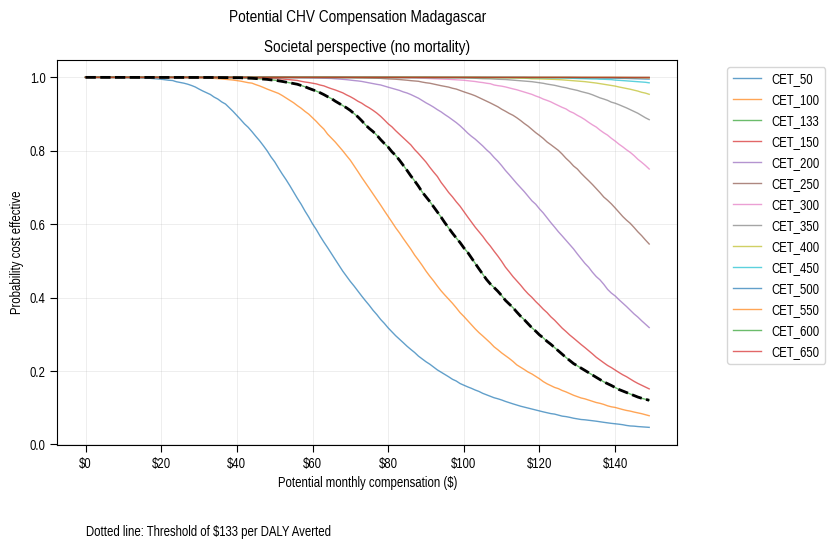

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
idx1 = (df2['CET_133'] - .8).abs().idxmin()
idx2 = (df2['CET_133'] - .5).abs().idxmin()
for col in df2.columns:
  df2[col].plot(kind="line", x=df2.index, label=col, lw=1, alpha=.7)

plt.plot(df2.index, df2['CET_133'], linestyle="--", lw=2, color="k")
plt.ylabel("Probability cost effective")
plt.xlabel("Potential monthly compensation ($)")
plt.suptitle("Potential CHV Compensation Madagascar")
plt.title("Societal perspective (no mortality)")
plt.legend(loc="upper right", bbox_to_anchor=(1.25,1))
# Apply the formatter to the x-axis
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.grid(alpha=.3, lw=.5)
plt.text(0,-.25, "Dotted line: Threshold of $133 per DALY Averted")
# Show the plot
plt.savefig("breakeven_soc_nodeath.png", bbox_inches="tight")
plt.show();

In [ ]:
files.download("breakeven_soc_nodeath.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Generate net health benefit (no mortality)-- to be used for EVPPI calculations
df["nhb_hs"] = df["total_qaly"] - df["IC_ND_1"]/133
voi = np.sum([t for t in df["nhb_hs"] if t > 0])/10000
print(f"The net health benefit is {abs(voi):,.2f} DALYs averted")

The net health benefit is 6,230.01 DALYs averted


In [ ]:
# Generate net health benefit -- to be used for EVPPI calculations
df["nmb_hs"] = df["total_qaly"] * 133 - df["IC_ND_1"]
voi = np.sum([t for t in df["nmb_hs"] if t > 0])/10000
print(f"The net monetary benefit is ${abs(voi):,.2f}")

The net monetary benefit is $828,591.88


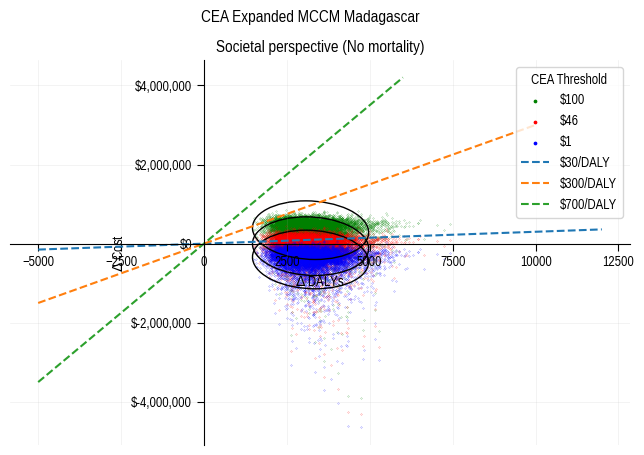

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(df["total_qaly"], df["IC_ND_100"],s=.02, color="g", label="$100")
plt.scatter(df["total_qaly"], df["IC_ND_46"] ,s=.02, color="r", label="$46")
plt.scatter(df["total_qaly"], df["IC_ND_1"]  ,s=.02, color="b", label="$1")

plt.plot([-5_000, 12_000], [-150_000, 360_000], label="$30/DALY", ls="--")
plt.plot([-5_000, 10_000], [-1_500_000, 3_000_000], label="$300/DALY", ls="--")
plt.plot([-5_000, 6_000], [-3_500_000, 4_200_000], label="$700/DALY", ls="--")
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.xlabel("")

# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values
y1 = df['IC_ND_100'].values
y2 = df['IC_ND_46'].values
y3 = df['IC_ND_1'].values

ci_ellipse(x, y1)
ci_ellipse(x, y2)
ci_ellipse(x, y3)

plt.ylabel(r'$\Delta$ Cost')  # Using the raw string literal r'' and LaTeX syntax for delta
plt.xlabel(r'$\Delta$ DALYs')
plt.suptitle("CEA Expanded MCCM Madagascar")
plt.title("Societal perspective (No mortality)")
plt.legend(title="CEA Threshold", loc="upper right", markerscale=12)

plt.show();

In [ ]:
above_t = np.sum([df["IC_ND_100"]/df['total_qaly']<133])/100
print("=========================================================================")
print(f"Using a CEA threshold of $133/DALY, there is a {above_t}% probability \nthe intervention is cost effective.")
print("=========================================================================")

Using a CEA threshold of $133/DALY, there is a 54.98% probability 
the intervention is cost effective.


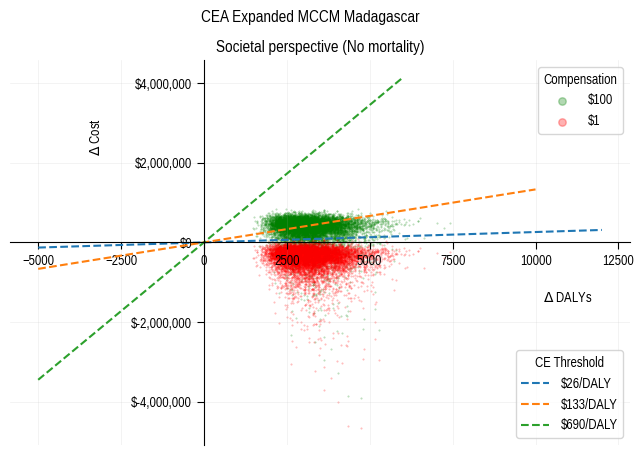

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sc1 = ax.scatter(df["total_qaly"], df["IC_ND_100"],s=.2, color="g", alpha=.3, label="$100")
# plt.scatter(df["total_qaly"], df["IC_ND_46"] ,s=.02, color="r", label="$46")
sc3 = ax.scatter(df["total_qaly"], df["IC_ND_1"]  ,s=.2, color="r", alpha=.3, label="$1")

l1, = ax.plot([-5_000, 12_000], [-130_000, 312_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 10_000], [-665_000, 1_330_000], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")

for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.xlabel("")

# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values
y1 = df['IC_ND_100'].values
# y2 = df['IC_ND_46'].values
y3 = df['IC_ND_1'].values

# ci_ellipse(x, y1)
# ci_ellipse(x, y2)
# ci_ellipse(x, y3)

plt.ylabel(r'$\Delta$ Cost')  # Using the raw string literal r'' and LaTeX syntax for delta
ax.yaxis.set_label_coords(0.15, 0.8)
plt.xlabel(r'$\Delta$ DALYs')
ax.xaxis.set_label_coords(0.9, 0.4)
plt.suptitle("CEA Expanded MCCM Madagascar")
plt.title("Societal perspective (No mortality)")
# plt.legend(title="CEA Threshold", loc="lower right", markerscale=12)
#plt.legend(title="CEA Threshold", loc="upper right")
leg1 = ax.legend(handles=[sc1, sc3], loc="upper right",
                 title="Compensation",
                 markerscale=12)
ax.add_artist(leg1)
leg2 = ax.legend(handles=[l1, l2, l3], loc ="lower right",
                 title="CE Threshold")
plt.savefig("cep_soc_nodeath.png", bbox_inches="tight")
plt.show();

In [ ]:
files.download("cep_soc_nodeath.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##CEAFC Societal Perspective No Death

In [ ]:
# $1 compensation for Societal Perspective (No deaths)
budget = list(range(0, 300_000, 15_000))
thresholds = list(range(0,200,1))
data =[]
for i in budget:
  proportions = []
  for threshold in thresholds:
    proportion_below_budget = (df["IC_ND_1"] < i).mean()
    proportion_below_threshold = ((df["IC_ND_1"]/df["total_qaly"]) < threshold).mean()
    proportion = proportion_below_threshold * proportion_below_budget
    proportions.append(proportion)
  data.append(proportions)
cols = [f"CEAFC_{i}" for i in thresholds]
df3 = pd.DataFrame(data, index=budget, columns=cols)
df3 = df3.T
df3 = df3.add_prefix("CEAFC_")
df3.reset_index(drop=True, inplace=True)
df3[:5]

CEAFC_0  CEAFC_15000  CEAFC_30000  CEAFC_45000  CEAFC_60000  CEAFC_75000  \
0  0.990622     0.992414     0.993210     0.993907     0.994603     0.994902   
1  0.991518     0.993311     0.994108     0.994805     0.995503     0.995802   
2  0.991717     0.993510     0.994308     0.995005     0.995703     0.996001   
3  0.991717     0.993510     0.994308     0.995005     0.995703     0.996001   
4  0.992215     0.994009     0.994807     0.995504     0.996202     0.996501   

   CEAFC_90000  CEAFC_105000  CEAFC_120000  CEAFC_135000  CEAFC_150000  \
0     0.995101        0.9953        0.9953        0.9953        0.9953   
1     0.996001        0.9962        0.9962        0.9962        0.9962   
2     0.996201        0.9964        0.9964        0.9964        0.9964   
3     0.996201        0.9964        0.9964        0.9964        0.9964   
4     0.996701        0.9969        0.9969        0.9969        0.9969   

   CEAFC_165000  CEAFC_180000  CEAFC_195000  CEAFC_210000  CEAFC_225000  \
0        0.9953        0.9953        0.9953        0.9953        0.9953   
1        0.9962        0.9962        0.9962        0.9962        0.9962   
2        0.9964        0.9964        0.9964        0.9964        0.9964   
3        0.9964        0.9964        0.9964        0.9964        0.9964   
4        0.9969        0.9969        0.9969        0.9969        0.9969   

   CEAFC_240000  CEAFC_255000  CEAFC_270000  CEAFC_285000  
0        0.9953        0.9953        0.9953        0.9953  
1        0.9962        0.9962        0.9962        0.9962  
2        0.9964        0.9964        0.9964        0.9964  
3        0.9964        0.9964        0.9964        0.9964  
4        0.9969        0.9969        0.9969        0.9969

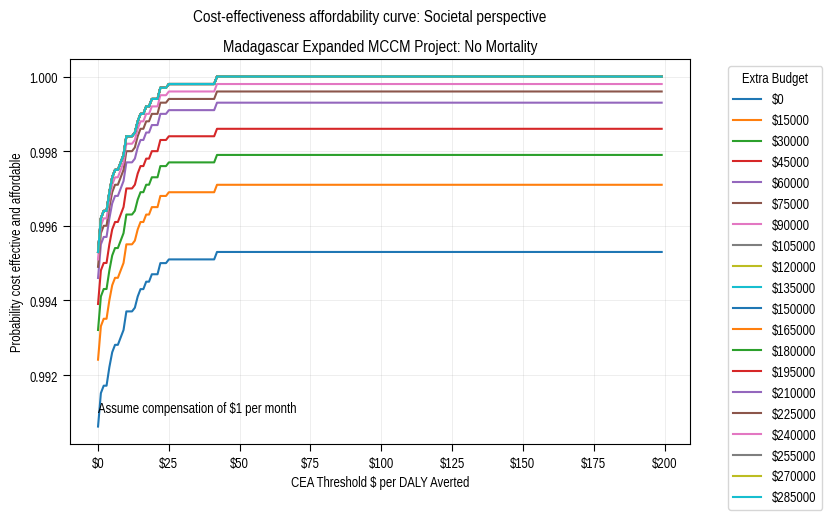

In [ ]:
colnames = df3.columns.tolist()
colnames =["$" + name.split("_")[1] for name in colnames]
df3.plot(figsize=(8,5))
plt.ylabel("Probability cost effective and affordable")
plt.xlabel("CEA Threshold $ per DALY Averted")
plt.grid(alpha=.3)
plt.suptitle("Cost-effectiveness affordability curve: Societal perspective")
plt.title("Madagascar Expanded MCCM Project: No Mortality")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
# plt.legend(title="Extra Budget",
#            labels=["$0","$250K", "$500K", "$750K",  "$1 million", ])
plt.legend(title="Extra Budget", labels=colnames, bbox_to_anchor=(1.05,1))
plt.text(0, 0.991, "Assume compensation of $1 per month")
plt.savefig("ceafc_soc_nd_1.png", bbox_inches="tight")

In [ ]:
files.download("ceafc_soc_nd_1.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# $50 compensation for Societal Perspective (No deaths)
budget = list(range(0, 700_000, 50_000))
thresholds = list(range(0,750,1))
data =[]
for i in budget:
  proportions = []
  for threshold in thresholds:
    proportion_below_budget = (df["IC_ND_50"] < i).mean()
    proportion_below_threshold = ((df["IC_ND_50"]/df["total_qaly"]) < threshold).mean()
    proportion = proportion_below_threshold * proportion_below_budget
    proportions.append(proportion)
  data.append(proportions)
cols = [f"CEAFC_{i}" for i in thresholds]
df3 = pd.DataFrame(data, index=budget, columns=cols)
df3 = df3.T
df3 = df3.add_prefix("CEAFC_")
df3.reset_index(drop=True, inplace=True)
df3[:5]

CEAFC_0  CEAFC_50000  CEAFC_100000  CEAFC_150000  CEAFC_200000  \
0  0.187836     0.232042      0.283227      0.334325      0.376191   
1  0.190739     0.235630      0.287605      0.339493      0.382007   
2  0.193990     0.239645      0.292507      0.345279      0.388517   
3  0.196460     0.242697      0.296232      0.349676      0.393464   
4  0.199191     0.246070      0.300349      0.354535      0.398933   

   CEAFC_250000  CEAFC_300000  CEAFC_350000  CEAFC_400000  CEAFC_450000  \
0      0.405792      0.423172      0.430063      0.432577      0.433270   
1      0.412066      0.429714      0.436711      0.439264      0.439968   
2      0.419088      0.437037      0.444153      0.446750      0.447466   
3      0.424425      0.442602      0.449810      0.452439      0.453164   
4      0.430323      0.448753      0.456061      0.458727      0.459462   

   CEAFC_500000  CEAFC_550000  CEAFC_600000  CEAFC_650000  
0        0.4334        0.4334        0.4334        0.4334  
1        0.4401        0.4401        0.4401        0.4401  
2        0.4476        0.4476        0.4476        0.4476  
3        0.4533        0.4533        0.4533        0.4533  
4        0.4596        0.4596        0.4596        0.4596

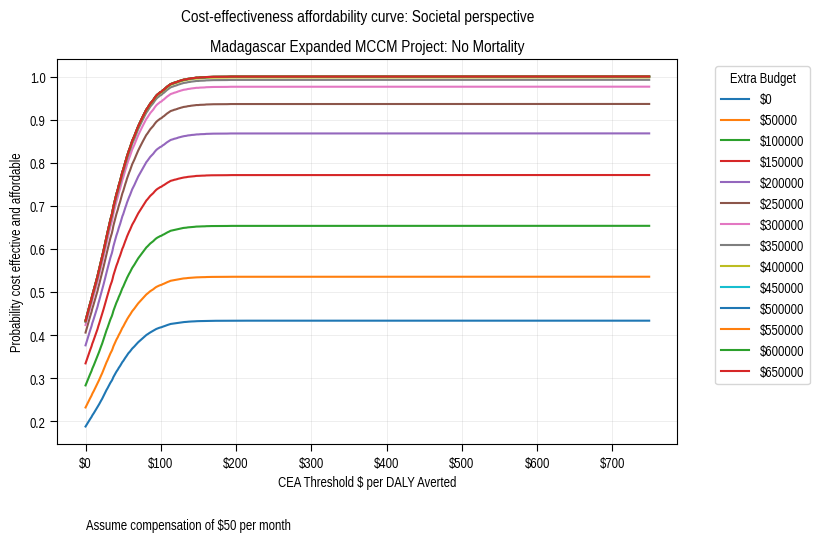

In [ ]:
colnames = df3.columns.tolist()
colnames =["$" + name.split("_")[1] for name in colnames]
df3.plot(figsize=(8,5))
plt.ylabel("Probability cost effective and affordable")
plt.xlabel("CEA Threshold $ per DALY Averted")
plt.grid(alpha=.3)
plt.suptitle("Cost-effectiveness affordability curve: Societal perspective")
plt.title("Madagascar Expanded MCCM Project: No Mortality")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
# plt.legend(title="Extra Budget",
#            labels=["$0","$250K", "$500K", "$750K",  "$1 million", ])
plt.legend(title="Extra Budget", labels=colnames, bbox_to_anchor=(1.05,1))
plt.text(0, -0.05, "Assume compensation of $50 per month")
plt.savefig("ceafc_soc_nd_50.png", bbox_inches="tight")

In [ ]:
files.download("ceafc_soc_nd_50.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# $100 compensation for Societal Perspective (No deaths)
budget = list(range(0, 1_250_000, 100_000))
thresholds = list(range(0,750,1))
data =[]
for i in budget:
  proportions = []
  for threshold in thresholds:
    proportion_below_budget = (df["IC_ND_100"] < i).mean()
    proportion_below_threshold = ((df["IC_ND_100"]/df["total_qaly"]) < threshold).mean()
    proportion = proportion_below_threshold * proportion_below_budget
    proportions.append(proportion)
  data.append(proportions)
cols = [f"CEAFC_{i}" for i in thresholds]
df3 = pd.DataFrame(data, index=budget, columns=cols)
df3 = df3.T
df3 = df3.add_prefix("CEAFC_")
df3.reset_index(drop=True, inplace=True)
df3[:5]

CEAFC_0  CEAFC_100000  CEAFC_200000  CEAFC_300000  CEAFC_400000  \
0  0.007534      0.011050      0.017013      0.026665      0.042107   
1  0.007638      0.011202      0.017248      0.027034      0.042689   
2  0.007743      0.011355      0.017483      0.027402      0.043271   
3  0.007829      0.011482      0.017679      0.027709      0.043756   
4  0.007994      0.011724      0.018052      0.028293      0.044678   

   CEAFC_500000  CEAFC_600000  CEAFC_700000  CEAFC_800000  CEAFC_900000  \
0      0.062236      0.078667      0.085602      0.086739        0.0868   
1      0.063096      0.079754      0.086786      0.087938        0.0880   
2      0.063956      0.080842      0.087969      0.089138        0.0892   
3      0.064673      0.081748      0.088955      0.090137        0.0902   
4      0.066036      0.083470      0.090829      0.092036        0.0921   

   CEAFC_1000000  CEAFC_1100000  CEAFC_1200000  
0         0.0868         0.0868         0.0868  
1         0.0880         0.0880         0.0880  
2         0.0892         0.0892         0.0892  
3         0.0902         0.0902         0.0902  
4         0.0921         0.0921         0.0921

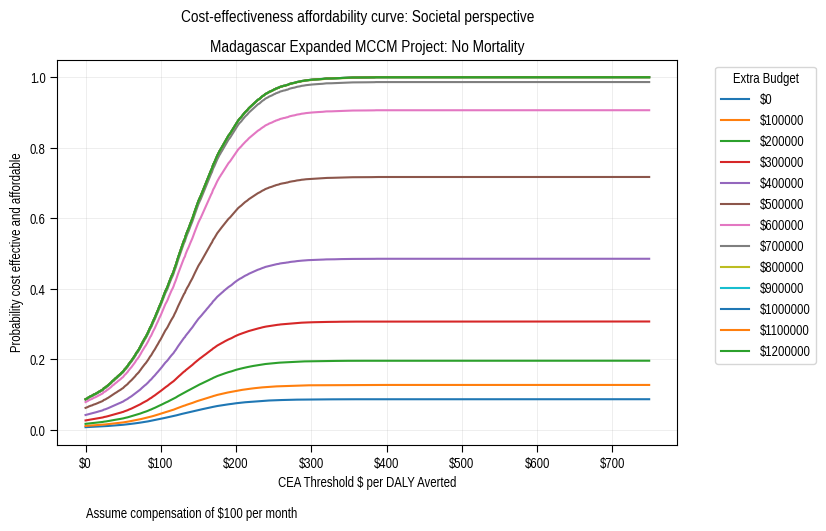

In [ ]:
colnames = df3.columns.tolist()
colnames =["$" + name.split("_")[1] for name in colnames]
df3.plot(figsize=(8,5))
plt.ylabel("Probability cost effective and affordable")
plt.xlabel("CEA Threshold $ per DALY Averted")
plt.grid(alpha=.3)
plt.suptitle("Cost-effectiveness affordability curve: Societal perspective")
plt.title("Madagascar Expanded MCCM Project: No Mortality")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
# plt.legend(title="Extra Budget",
#            labels=["$0","$250K", "$500K", "$750K",  "$1 million", ])
plt.legend(title="Extra Budget", labels=colnames, bbox_to_anchor=(1.05,1))
plt.text(0, -0.25, "Assume compensation of $100 per month")
plt.savefig("ceafc_soc_nd_100.png", bbox_inches="tight")

In [ ]:
files.download("ceafc_soc_nd_100.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Include Mortality Benefits

In [ ]:
# Include mortality benefits
# Simulate incremental costs from a societal perspective (no deaths)
for i in range(1, 151):
  df[f"IC_D_{i}"] = df[f"IC_{i}"] - df["non_death_savings"] - df['death_costs']
df[["IC_ND_100", "IC_100", "IC_D_100"]][:5]

IC_ND_100         IC_100       IC_D_100
0  251954.623437  626007.087709 -114806.717352
1  594713.593113  868343.837678  330096.275259
2  363452.652300  700260.484686  107086.704592
3  711684.509808  911337.947625  283965.944884
4  455209.076956  700393.932377  216408.322550

In [ ]:
# Generate net health benefit -- to be used for EVPPI calculations
df["nmb_hs"] = df["total_qaly"] * 133 - df["IC_D_1"]
voi = np.sum([t for t in df["nmb_hs"] if t > 0])/10000
print(f"The net monetary benefit is ${abs(voi):,.2f}")

The net monetary benefit is $1,174,776.91


In [ ]:
result = sum([1 for _, row in df.iterrows() if (row["IC_1"] / row["total_qaly"] < 133) and (row["IC_1"] < -1000)]) / 100
result

54.7

In [ ]:
thresholds = [50, 100, 133, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650]
data = []

for threshold in thresholds:
    proportions = []
    for i in range(1, 151):
        column_name = f"IC_D_{i}"
        proportion = ((df[column_name] / df["total_qaly"]) < threshold).mean()
        proportions.append(proportion)
    data.append(proportions)

columns = [f"IC_D_{i}" for i in range(1, 151)]
result_df = pd.DataFrame(data, index=thresholds, columns=columns)
df2 = result_df.T
df2 = df2.add_prefix("CET_")
compensation = df2.index
df2 = df2.reset_index(drop=True)
df2[:5]

CET_50  CET_100  CET_133  CET_150  CET_200  CET_250  CET_300  CET_350  \
0     1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
1     1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
2     1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
3     1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
4     1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0   

   CET_400  CET_450  CET_500  CET_550  CET_600  CET_650  
0      1.0      1.0      1.0      1.0      1.0      1.0  
1      1.0      1.0      1.0      1.0      1.0      1.0  
2      1.0      1.0      1.0      1.0      1.0      1.0  
3      1.0      1.0      1.0      1.0      1.0      1.0  
4      1.0      1.0      1.0      1.0      1.0      1.0

In [ ]:
# Select thresholds between 1 and 1000
thresholds = list(range(1,1001))
# Generate empty lists suffixed by potential compensation
probs_1 = []
probs_30 = []
probs_50 = []
probs_75 = []
probs_100 = []
probs_125 = []
probs_150 = []
# Generate a list of x values that will be used as the x-axis
x = np.arange(1,1001)
for threshold in thresholds:
  proportions = ((df["IC_D_1"] / df["total_qaly"]) < threshold).mean()
  probs_1.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_D_30"] / df["total_qaly"]) < threshold).mean()
  probs_30.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_D_50"] / df["total_qaly"]) < threshold).mean()
  probs_50.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_D_75"] / df["total_qaly"]) < threshold).mean()
  probs_75.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_D_100"] / df["total_qaly"]) < threshold).mean()
  probs_100.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_D_125"] / df["total_qaly"]) < threshold).mean()
  probs_125.append(proportions)
for threshold in thresholds:
  proportions = ((df["IC_D_150"] / df["total_qaly"]) < threshold).mean()
  probs_150.append(proportions)

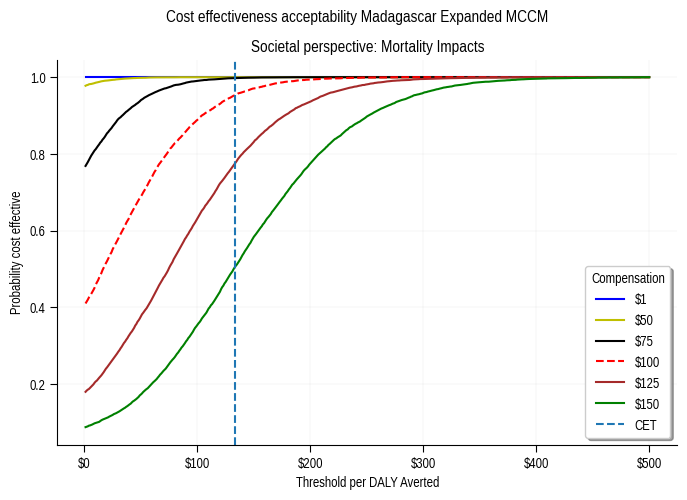

In [ ]:
# Plot the graphs
fig, ax = plt.subplots(figsize=(8,5), dpi=100)
plt.plot(x[:500], probs_1[:500], color="b", label="$1")
plt.plot(x[:500], probs_50[:500], color="y", label="$50")
plt.plot(x[:500], probs_75[:500], color="k", label="$75")
plt.plot(x[:500], probs_100[:500], color="r", ls="--", label="$100")
plt.plot(x[:500], probs_125[:500], color="brown", label="$125")
plt.plot(x[:500], probs_150[:500], color="g", label="$150")
plt.grid(axis="both", lw=.3, alpha=.3)
plt.suptitle("Cost effectiveness acceptability Madagascar Expanded MCCM")
plt.title("Societal perspective: Mortality Impacts")
plt.ylabel("Probability cost effective")
plt.xlabel("Threshold per DALY Averted")
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.axvline(133, label="CET", ls="--")
plt.legend(loc="lower right", title="Compensation", fancybox=True, shadow=True)
# ax.text(.5, -.15, "Red dotted line: Madagascar trial compensation",
#         ha="center", transform=ax.transAxes,
#         fontdict={'style':'italic'})
plt.savefig("ceac_soc_nodeath.png", bbox_inches="tight")

In [ ]:
files.download("ceac_soc_nodeath.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Societal Perspective with Mortality Benefits

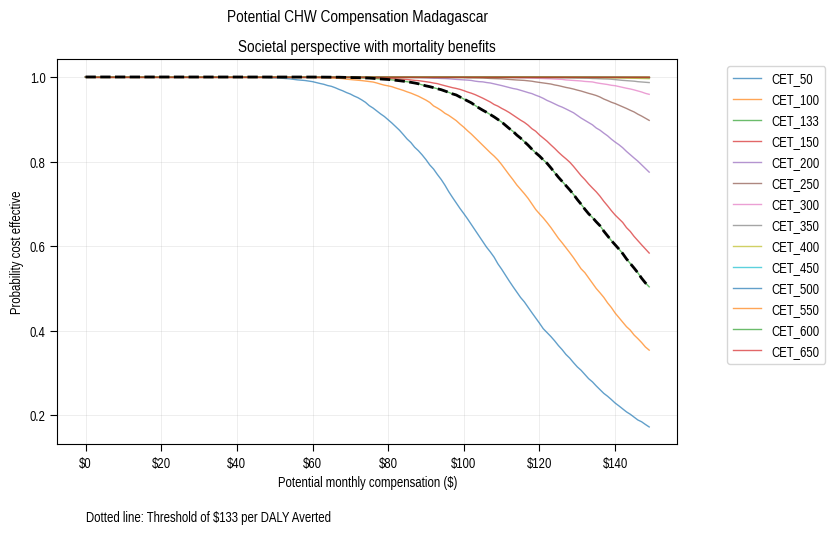

In [ ]:
fig, ax = plt.subplots(figsize=(8,5), dpi=100)
idx1 = (df2['CET_133'] - .8).abs().idxmin()
idx2 = (df2['CET_133'] - .5).abs().idxmin()
for col in df2.columns:
  df2[col].plot(kind="line", x=df2.index, label=col, lw=1, alpha=.7)

plt.plot(df2.index, df2['CET_133'], linestyle="--", lw=2, color="k")
plt.ylabel("Probability cost effective")
plt.xlabel("Potential monthly compensation ($)")
plt.suptitle("Potential CHW Compensation Madagascar")
plt.title("Societal perspective with mortality benefits")
plt.legend(loc="upper right", bbox_to_anchor=(1.25,1))
# Apply the formatter to the x-axis
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.grid(alpha=.3, lw=.5)
plt.text(0,-.05, "Dotted line: Threshold of $133 per DALY Averted")
# Show the plot
plt.savefig("soc_mort_comp.png", bbox_inches="tight")
plt.show();

In [ ]:
files.download("soc_mort_comp.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**$1 compensation with mortality benefits**

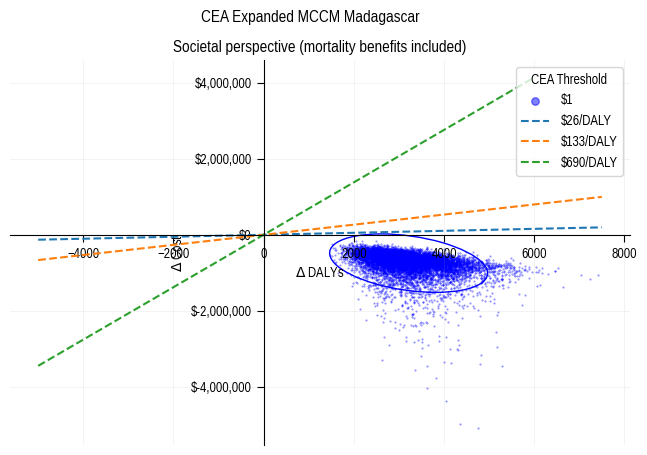

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

plt.scatter(df["total_qaly"], df["IC_D_1"]  ,s=.2, color="b", alpha=.5, label="$1")

l1, = ax.plot([-5_000, 7_500], [-130_000, 195_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 7_500], [-665_000, 997_500], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")

for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))


# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values

y3 = df['IC_D_1'].values


ci_ellipse(x, y3, edgecolor="b")

plt.ylabel(r'$\Delta$ Cost')
plt.xlabel(r'$\Delta$ DALYs')
plt.suptitle("CEA Expanded MCCM Madagascar")
plt.title("Societal perspective (mortality benefits included)")
plt.legend(title="CEA Threshold", loc="upper right", markerscale=12)

plt.show();

In [ ]:
above_300 = np.sum([df["IC_D_1"]/df['total_qaly']<133])/100
above_30 = np.sum([df["IC_D_1"]/df['total_qaly']<30])/100
print("=========================================================================")
print(f"Using a CEA threshold of $300/DALY averted, there is a {above_300}% probability \nthe intervention is cost effective.")
print("")
print(f"Using a CEA threshold of $30/DALY averted, there is a {above_30}% probability \nthe intervention is cost effective.")
print("A CEA threshold of $30/DALY averted is quite conservative")
print("=========================================================================")

Using a CEA threshold of $300/DALY averted, there is a 100.0% probability 
the intervention is cost effective.

Using a CEA threshold of $30/DALY averted, there is a 100.0% probability 
the intervention is cost effective.
A CEA threshold of $30/DALY averted is quite conservative


**$50 compensation with mortality benefits**

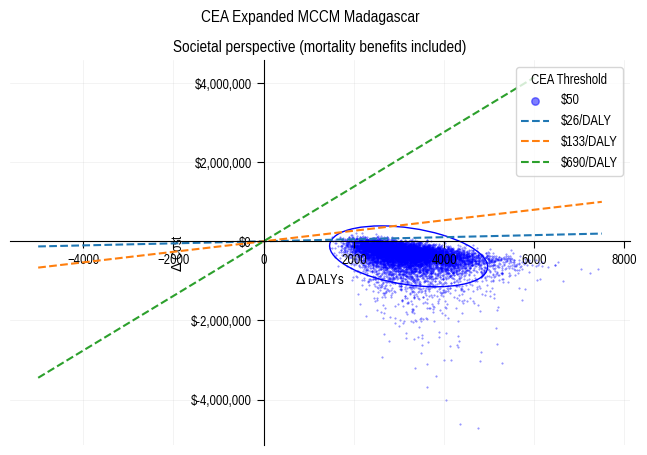

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

plt.scatter(df["total_qaly"], df["IC_D_50"]  ,s=.2, color="b", alpha=.5, label="$50")

l1, = ax.plot([-5_000, 7_500], [-130_000, 195_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 7_500], [-665_000, 997_500], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")

for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))

# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values

y3 = df['IC_D_50'].values

ci_ellipse(x, y3, edgecolor="b")

plt.ylabel(r'$\Delta$ Cost')
plt.xlabel(r'$\Delta$ DALYs')
plt.suptitle("CEA Expanded MCCM Madagascar")
plt.title("Societal perspective (mortality benefits included)")
plt.legend(title="CEA Threshold", loc="upper right", markerscale = 12)

plt.show();

In [ ]:
above_300 = np.sum([df["IC_D_50"]/df['total_qaly']<300])/100
above_30 = np.sum([df["IC_D_50"]/df['total_qaly']<30])/100
print("=========================================================================")
print(f"Using a CEA threshold of $300/DALY averted, there is a {above_300}% probability \nthe intervention is cost effective.")
print("")
print(f"Using a CEA threshold of $30/DALY averted, there is a {above_30}% probability \nthe intervention is cost effective.")
print("A CEA threshold of $30/DALY averted is quite conservative")
print("=========================================================================")

Using a CEA threshold of $300/DALY averted, there is a 100.0% probability 
the intervention is cost effective.

Using a CEA threshold of $30/DALY averted, there is a 99.44% probability 
the intervention is cost effective.
A CEA threshold of $30/DALY averted is quite conservative


**$100 compensation**

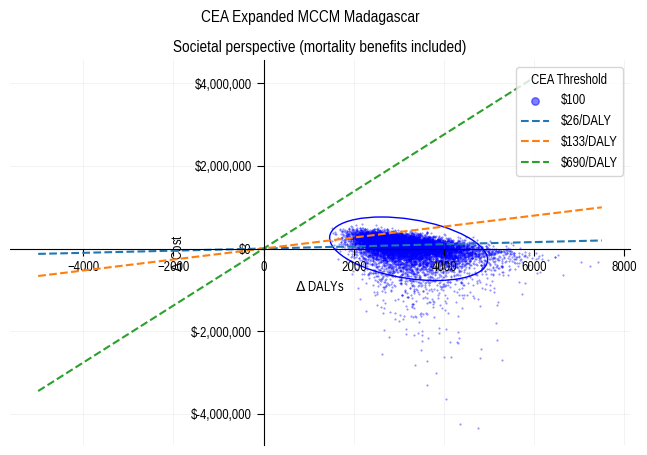

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

plt.scatter(df["total_qaly"], df["IC_D_100"]  ,s=.2, color="b", alpha=.5, label="$100")

l1, = ax.plot([-5_000, 7_500], [-130_000, 195_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 7_500], [-665_000, 997_500], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")

for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))

# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values

y3 = df['IC_D_100'].values

ci_ellipse(x, y3, edgecolor="b")

plt.ylabel(r'$\Delta$ Cost')
plt.xlabel(r'$\Delta$ DALYs')
plt.suptitle("CEA Expanded MCCM Madagascar")
plt.title("Societal perspective (mortality benefits included)")
plt.legend(title="CEA Threshold", loc="upper right", markerscale=12)

plt.show();

In [ ]:
above_300 = np.sum([df["IC_D_100"]/df['total_qaly']<133])/100
above_30 = np.sum([df["IC_D_100"]/df['total_qaly']<30])/100
print("=========================================================================")
print(f"Using a CEA threshold of $300/DALY averted, there is a {above_300}% probability \nthe intervention is cost effective.")
print("")
print(f"Using a CEA threshold of $30/DALY averted, there is a {above_30}% probability \nthe intervention is cost effective.")
print("A CEA threshold of $30/DALY averted is quite conservative")
print("=========================================================================")

Using a CEA threshold of $300/DALY averted, there is a 95.25% probability 
the intervention is cost effective.

Using a CEA threshold of $30/DALY averted, there is a 57.92% probability 
the intervention is cost effective.
A CEA threshold of $30/DALY averted is quite conservative


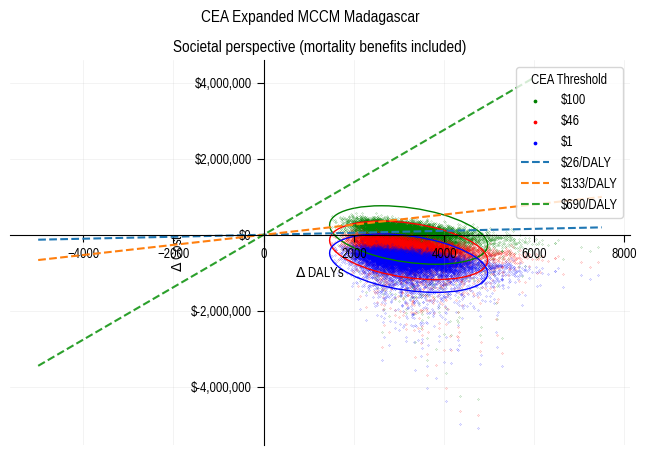

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(df["total_qaly"], df["IC_D_100"],s=.02, color="g", label="$100")
plt.scatter(df["total_qaly"], df["IC_D_46"] ,s=.02, color="r", label="$46")
plt.scatter(df["total_qaly"], df["IC_D_1"]  ,s=.02, color="b", label="$1")

l1, = ax.plot([-5_000, 7_500], [-130_000, 195_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 7_500], [-665_000, 997_500], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")

for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))


# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values
y1 = df['IC_D_100'].values
y2 = df['IC_D_46'].values
y3 = df['IC_D_1'].values

ci_ellipse(x, y1, edgecolor="g")
ci_ellipse(x, y2, edgecolor="r")
ci_ellipse(x, y3, edgecolor="b")

plt.ylabel(r'$\Delta$ Cost')  # Using the raw string literal r'' and LaTeX syntax for delta
plt.xlabel(r'$\Delta$ DALYs')
plt.suptitle("CEA Expanded MCCM Madagascar")
plt.title("Societal perspective (mortality benefits included)")
plt.legend(title="CEA Threshold", loc="upper right", markerscale=12)

plt.show();

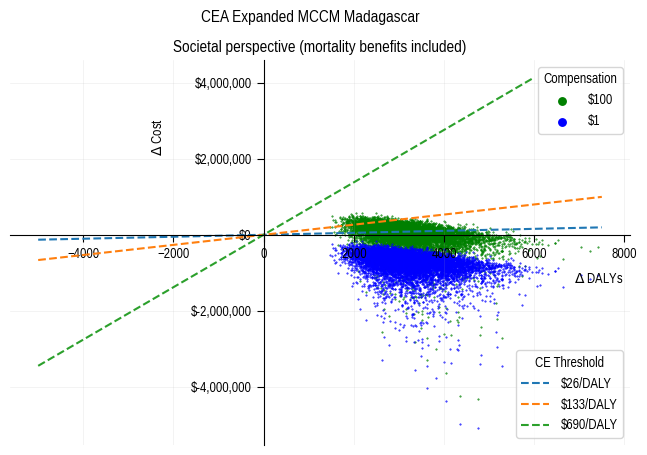

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sc1 = ax.scatter(df["total_qaly"], df["IC_D_100"],s=.2, color="g", label="$100")
# plt.scatter(df["total_qaly"], df["IC_D_46"] ,s=.02, color="r", label="$46")
sc3 = ax.scatter(df["total_qaly"], df["IC_D_1"]  ,s=.2, color="b", label="$1")

l1, = ax.plot([-5_000, 7_500], [-130_000, 195_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 7_500], [-665_000, 997_500], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")

for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))


# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values
y1 = df['IC_D_100'].values
# y2 = df['IC_D_46'].values
y3 = df['IC_D_1'].values

# ci_ellipse(x, y1, edgecolor="g")
# # ci_ellipse(x, y2, edgecolor="r")
# ci_ellipse(x, y3, edgecolor="b")

plt.ylabel(r'$\Delta$ Cost')  # Using the raw string literal r'' and LaTeX syntax for delta
ax.yaxis.set_label_coords(0.25, 0.8)
plt.xlabel(r'$\Delta$ DALYs')
ax.xaxis.set_label_coords(0.95, 0.45)
plt.suptitle("CEA Expanded MCCM Madagascar")
plt.title("Societal perspective (mortality benefits included)")
# plt.legend(title="CEA Threshold", loc="upper right", markerscale=12)
leg1 = ax.legend(handles=[sc1, sc3], loc="upper right",
                 title="Compensation",
                 markerscale=12)
ax.add_artist(leg1)
leg2 = ax.legend(handles=[l1, l2, l3], loc ="lower right",
                 title="CE Threshold")

plt.savefig("ceplane_soc.png", bbox_inches="tight")
plt.show();

In [ ]:
files.download("ceplane_soc.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##CEAFC Societal Perspective with Mortality Benefits

In [ ]:
# $1 compensation for Societal Perspective (No deaths)
budget = list(range(0, 250_000, 25_000))
thresholds = list(range(0,250,1))
data =[]
for i in budget:
  proportions = []
  for threshold in thresholds:
    proportion_below_budget = (df["IC_D_1"] < i).mean()
    proportion_below_threshold = ((df["IC_D_1"]/df["total_qaly"]) < threshold).mean()
    proportion = proportion_below_threshold * proportion_below_budget
    proportions.append(proportion)
  data.append(proportions)
cols = [f"CEAFC_{i}" for i in thresholds]
df3 = pd.DataFrame(data, index=budget, columns=cols)
df3 = df3.T
df3 = df3.add_prefix("CEAFC_")
df3.reset_index(drop=True, inplace=True)
df3[:5]

CEAFC_0  CEAFC_25000  CEAFC_50000  CEAFC_75000  CEAFC_100000  CEAFC_125000  \
0      1.0          1.0          1.0          1.0           1.0           1.0   
1      1.0          1.0          1.0          1.0           1.0           1.0   
2      1.0          1.0          1.0          1.0           1.0           1.0   
3      1.0          1.0          1.0          1.0           1.0           1.0   
4      1.0          1.0          1.0          1.0           1.0           1.0   

   CEAFC_150000  CEAFC_175000  CEAFC_200000  CEAFC_225000  
0           1.0           1.0           1.0           1.0  
1           1.0           1.0           1.0           1.0  
2           1.0           1.0           1.0           1.0  
3           1.0           1.0           1.0           1.0  
4           1.0           1.0           1.0           1.0

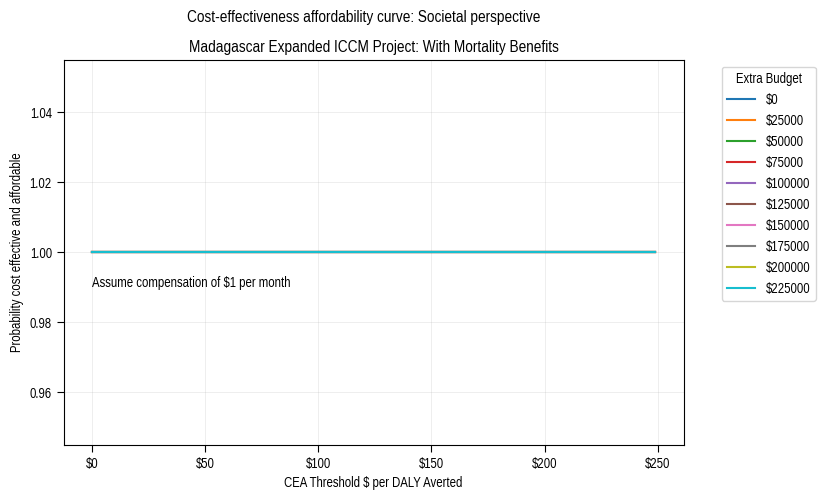

In [ ]:
colnames = df3.columns.tolist()
colnames =["$" + name.split("_")[1] for name in colnames]
df3.plot(figsize=(8,5))
plt.ylabel("Probability cost effective and affordable")
plt.xlabel("CEA Threshold $ per DALY Averted")
plt.grid(alpha=.3)
plt.suptitle("Cost-effectiveness affordability curve: Societal perspective")
plt.title("Madagascar Expanded ICCM Project: With Mortality Benefits")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
# plt.legend(title="Extra Budget",
#            labels=["$0","$250K", "$500K", "$750K",  "$1 million", ])
plt.legend(title="Extra Budget", labels=colnames, bbox_to_anchor=(1.05,1))
plt.text(0, 0.990, "Assume compensation of $1 per month")
plt.savefig("ceafc_soc_d_1.png", bbox_inches="tight")

In [ ]:
files.download("ceafc_soc_d_1.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# $50 compensation for Societal Perspective (No deaths)
budget = list(range(0, 1_250_000, 100_000))
thresholds = list(range(0,750,1))
data =[]
for i in budget:
  proportions = []
  for threshold in thresholds:
    proportion_below_budget = (df["IC_D_50"] < i).mean()
    proportion_below_threshold = ((df["IC_D_50"]/df["total_qaly"]) < threshold).mean()
    proportion = proportion_below_threshold * proportion_below_budget
    proportions.append(proportion)
  data.append(proportions)
cols = [f"CEAFC_{i}" for i in thresholds]
df3 = pd.DataFrame(data, index=budget, columns=cols)
df3 = df3.T
df3 = df3.add_prefix("CEAFC_")
df3.reset_index(drop=True, inplace=True)
df3[:5]

CEAFC_0  CEAFC_100000  CEAFC_200000  CEAFC_300000  CEAFC_400000  \
0  0.953357      0.973959      0.976302        0.9764        0.9764   
1  0.954431      0.975056      0.977402        0.9775        0.9775   
2  0.955896      0.976553      0.978902        0.9790        0.9790   
3  0.956579      0.977251      0.979602        0.9797        0.9797   
4  0.958141      0.978847      0.981202        0.9813        0.9813   

   CEAFC_500000  CEAFC_600000  CEAFC_700000  CEAFC_800000  CEAFC_900000  \
0        0.9764        0.9764        0.9764        0.9764        0.9764   
1        0.9775        0.9775        0.9775        0.9775        0.9775   
2        0.9790        0.9790        0.9790        0.9790        0.9790   
3        0.9797        0.9797        0.9797        0.9797        0.9797   
4        0.9813        0.9813        0.9813        0.9813        0.9813   

   CEAFC_1000000  CEAFC_1100000  CEAFC_1200000  
0         0.9764         0.9764         0.9764  
1         0.9775         0.9775         0.9775  
2         0.9790         0.9790         0.9790  
3         0.9797         0.9797         0.9797  
4         0.9813         0.9813         0.9813

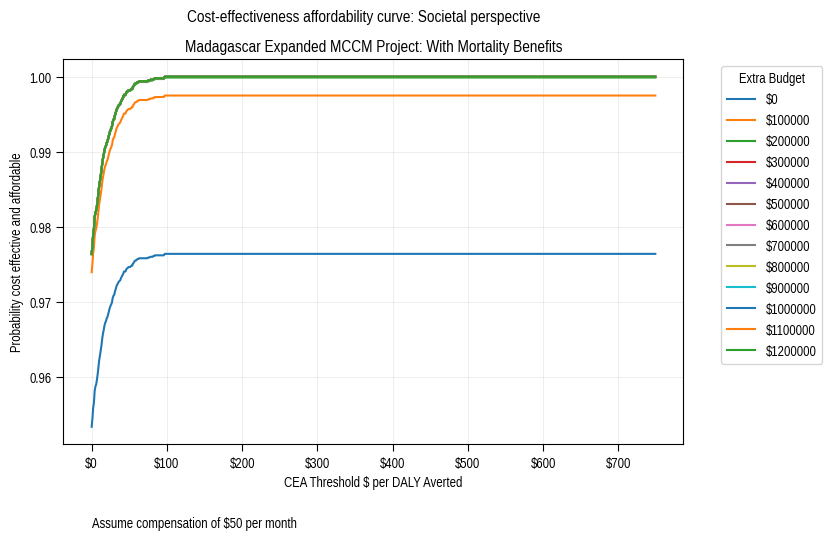

In [ ]:
colnames = df3.columns.tolist()
colnames =["$" + name.split("_")[1] for name in colnames]
df3.plot(figsize=(8,5))
plt.ylabel("Probability cost effective and affordable")
plt.xlabel("CEA Threshold $ per DALY Averted")
plt.grid(alpha=.3)
plt.suptitle("Cost-effectiveness affordability curve: Societal perspective")
plt.title("Madagascar Expanded MCCM Project: With Mortality Benefits")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
# plt.legend(title="Extra Budget",
#            labels=["$0","$250K", "$500K", "$750K",  "$1 million", ])
plt.legend(title="Extra Budget", labels=colnames, bbox_to_anchor=(1.05,1))
plt.text(0, 0.94, "Assume compensation of $50 per month")
plt.savefig("ceafc_soc_d_50.png", bbox_inches="tight")

In [ ]:
files.download("ceafc_soc_d_50.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# $100 compensation for Societal Perspective (No deaths)
budget = list(range(0, 1_250_000, 100_000))
thresholds = list(range(0,750,1))
data =[]
for i in budget:
  proportions = []
  for threshold in thresholds:
    proportion_below_budget = (df["IC_D_100"] < i).mean()
    proportion_below_threshold = ((df["IC_D_100"]/df["total_qaly"]) < threshold).mean()
    proportion = proportion_below_threshold * proportion_below_budget
    proportions.append(proportion)
  data.append(proportions)
cols = [f"CEAFC_{i}" for i in thresholds]
df3 = pd.DataFrame(data, index=budget, columns=cols)
df3 = df3.T
df3 = df3.add_prefix("CEAFC_")
df3.reset_index(drop=True, inplace=True)
df3[:5]

CEAFC_0  CEAFC_100000  CEAFC_200000  CEAFC_300000  CEAFC_400000  \
0  0.163782      0.238166      0.318054      0.373376      0.398994   
1  0.165806      0.241108      0.321983      0.377989      0.403923   
2  0.167829      0.244051      0.325913      0.382602      0.408853   
3  0.169812      0.246935      0.329764      0.387123      0.413684   
4  0.172159      0.250348      0.334322      0.392474      0.419402   

   CEAFC_500000  CEAFC_600000  CEAFC_700000  CEAFC_800000  CEAFC_900000  \
0      0.404376        0.4047        0.4047        0.4047        0.4047   
1      0.409372        0.4097        0.4097        0.4097        0.4097   
2      0.414368        0.4147        0.4147        0.4147        0.4147   
3      0.419264        0.4196        0.4196        0.4196        0.4196   
4      0.425060        0.4254        0.4254        0.4254        0.4254   

   CEAFC_1000000  CEAFC_1100000  CEAFC_1200000  
0         0.4047         0.4047         0.4047  
1         0.4097         0.4097         0.4097  
2         0.4147         0.4147         0.4147  
3         0.4196         0.4196         0.4196  
4         0.4254         0.4254         0.4254

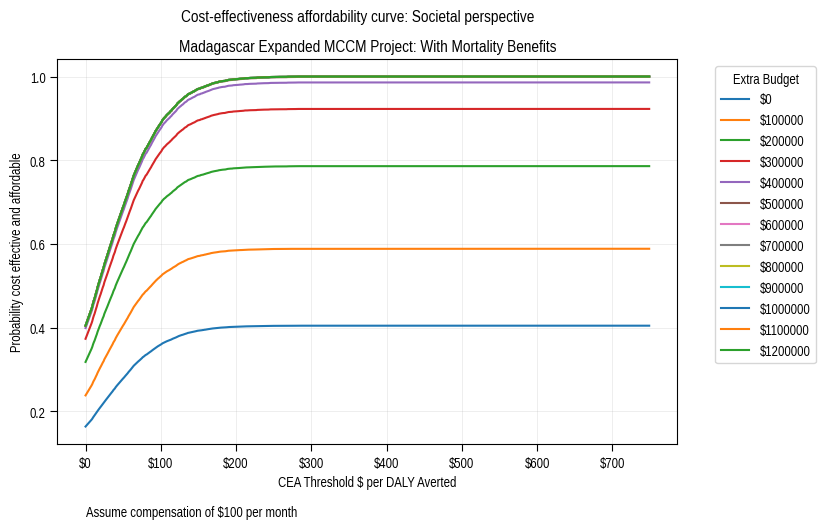

In [ ]:
colnames = df3.columns.tolist()
colnames =["$" + name.split("_")[1] for name in colnames]
df3.plot(figsize=(8,5))
plt.ylabel("Probability cost effective and affordable")
plt.xlabel("CEA Threshold $ per DALY Averted")
plt.grid(alpha=.3)
plt.suptitle("Cost-effectiveness affordability curve: Societal perspective")
plt.title("Madagascar Expanded MCCM Project: With Mortality Benefits")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
# plt.legend(title="Extra Budget",
#            labels=["$0","$250K", "$500K", "$750K",  "$1 million", ])
plt.legend(title="Extra Budget", labels=colnames, bbox_to_anchor=(1.05,1))
plt.text(0, -0.05, "Assume compensation of $100 per month")
plt.savefig("ceafc_soc_d_100.png", bbox_inches="tight");

In [ ]:
# Value of information societal with death
df["nhb_death"] = df["total_qaly"] * 133 - (df["inc_prog"] - df["non_death_savings"] - df["death_costs"])
df["nhb_nondeath"] = df["total_qaly"] * 133 - (df["inc_prog"] - df["non_death_savings"])
voi_d = np.sum([t for t in df["nhb_death"] if t < 0])/10000
voi_nd = np.sum([t for t in df["nhb_nondeath"] if t < 0])/10000
print(f"The value of information from a societal perspective is ${abs(voi_nd):,.2f}")

The value of information from a societal perspective is $0.00


Mortality benefits are highly sensitive to income elasticities chosen

There is no agreement on the appropriate elasticity: ranges 1 - 2.5

In [ ]:
# Include mortality benefits
# Simulate incremental costs from a societal perspective (no deaths)
etas = [i/10 for i in range(10, 26)]
annual_vsls = []
for eta in etas:
  mc_vsl = us_vsl * (gdp_ppp/us_gdp_pc) ** eta
  mc_vsl_year = mc_vsl/np.sum([(1+discount_rate) ** -t for t in range(rem_life)])
  annual_vsls.append(mc_vsl_year)
annual_vsls

[9170.175516912546,
 6230.852837524018,
 4233.673282619175,
 2876.651067093079,
 1954.5961176976625,
 1328.0880767994634,
 902.3950900989792,
 613.1497698534827,
 416.6164514815148,
 283.07809311667086,
 192.34287680578075,
 130.6910819223157,
 88.80057934909759,
 60.33726844057078,
 40.99732219716075,
 27.856422254071624]

In [ ]:
# Include mortality benefits
# Simulate incremental costs from a societal perspective (no deaths)
etas = [i/10 for i in range(10, 26)]

for eta in etas:
  for i in range(1, 151):
    df[f"IC_D_{i}_{eta}"] = df[f"IC_{i}"] - df["non_death_savings"] - df[f'death_costs_{eta}']
df[["IC_ND_100", "IC_100", "IC_D_100_2.5"]][:5]

IC_ND_100         IC_100   IC_D_100_2.5
0  251954.623437  626007.087709   89747.913632
1  594713.593113  868343.837678  477681.889623
2  363452.652300  700260.484686  250070.263648
3  711684.509808  911337.947625  522518.386166
4  455209.076956  700393.932377  349595.206672

In [ ]:
df[["IC_D_100_1.5", "IC_D_100_2.0", "IC_D_100_2.5"]][:5]

IC_D_100_1.5   IC_D_100_2.0   IC_D_100_2.5
0  -48292.739664   72285.011875   89747.913632
1  378085.930706  465082.453121  477681.889623
2  153579.933374  237863.706247  250070.263648
3  361534.815756  502153.079226  522518.386166
4  259716.016912  338224.994903  349595.206672

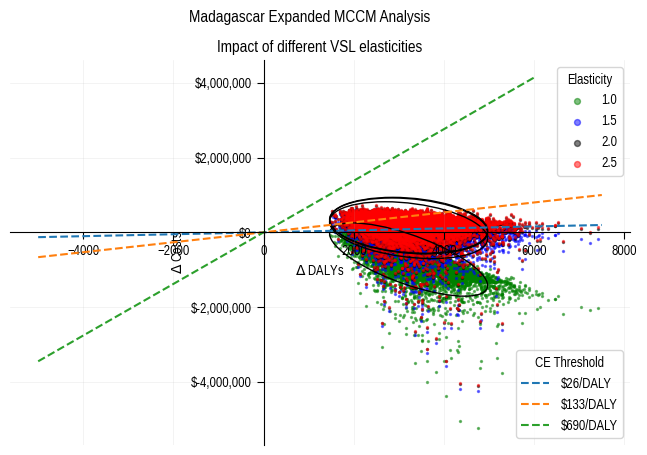

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sc1 = ax.scatter(df["total_qaly"], df["IC_D_100_1.0"],s=2, color="g", alpha=.5, label="1.0")
sc2 = ax.scatter(df["total_qaly"], df["IC_D_100_1.5"],s=2, color="b", alpha=.5, label="1.5")
sc3 = ax.scatter(df["total_qaly"], df["IC_D_100_2.0"],s=2, color="k", alpha=.5, label="2.0")
sc4 = ax.scatter(df["total_qaly"], df["IC_D_100_2.5"],s=2, color="r", alpha=.5, label="2.5")

l1, = ax.plot([-5_000, 7_500], [-130_000, 195_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 7_500], [-665_000, 997_500], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")

ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.xlabel(r'$\Delta$ DALYs')
plt.ylabel(f"$\Delta$ Costs")
plt.suptitle("Madagascar Expanded MCCM Analysis")
plt.title("Impact of different VSL elasticities")

#plt.legend(bbox_to_anchor=(1.2,1.0));
leg1 = ax.legend(handles=[sc1, sc2, sc3, sc4], loc="upper right",
                 title="Elasticity", markerscale=3)
ax.add_artist(leg1)
leg2 = ax.legend(handles=[l1, l2, l3], loc ="lower right", title="CE Threshold")
# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values
y1 = df['IC_D_100_1.0'].values
y2 = df['IC_D_100_1.5'].values
y3 = df['IC_D_100_2.0'].values
y4 = df['IC_D_100_2.5'].values

ci_ellipse(x, y1)
ci_ellipse(x, y2)
ci_ellipse(x, y3)
ci_ellipse(x, y4);

In [ ]:
result = sum([1 for _, row in df.iterrows() if (row["IC_D_100"] / row["total_qaly"] < 133) and (row["IC_D_100"] < 10000)]) / 100

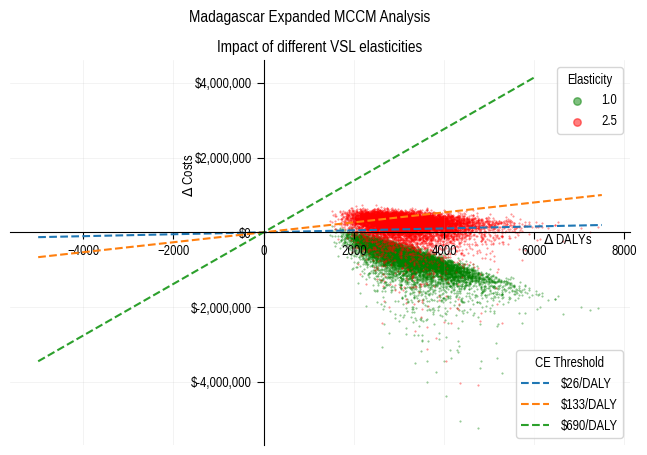

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sc1 = ax.scatter(df["total_qaly"], df["IC_D_100_1.0"],s=.2, color="g", alpha=.5, label="1.0")
# sc2 = ax.scatter(df["total_qaly"], df["IC_D_100_1.5"],s= .2, color="r", alpha=.5, label="1.5")
# sc3 = ax.scatter(df["total_qaly"], df["IC_D_100_2.0"],s=2, color="k", alpha=.5, label="2.0")
sc4 = ax.scatter(df["total_qaly"], df["IC_D_100_2.5"],s= .2, color="r", alpha=.5, label="2.5")

l1, = ax.plot([-5_000, 7_500], [-130_000, 195_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 7_500], [-665_000, 997_500], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")

ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))

plt.xlabel(r'$\Delta$ DALYs')
ax.xaxis.set_label_coords(0.9, 0.55)
plt.ylabel(f"$\Delta$ Costs")
ax.yaxis.set_label_coords(0.3, 0.7)

plt.suptitle("Madagascar Expanded MCCM Analysis")
plt.title("Impact of different VSL elasticities")

#plt.legend(bbox_to_anchor=(1.2,1.0));
leg1 = ax.legend(handles=[sc1, sc4], loc="upper right",
                 title="Elasticity", markerscale=12)
ax.add_artist(leg1)
leg2 = ax.legend(handles=[l1, l2, l3], loc ="lower right", title="CE Threshold")
# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values
y1 = df['IC_D_100_1.0'].values
# y2 = df['IC_D_100_1.5'].values
# y3 = df['IC_D_100_2.0'].values
y4 = df['IC_D_100_2.5'].values

# ci_ellipse(x, y1)
# ci_ellipse(x, y2)
# ci_ellipse(x, y3)
# ci_ellipse(x, y4);
plt.savefig("elasticity_soc.png", bbox_inches="tight")

In [ ]:
files.download("elasticity_soc.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

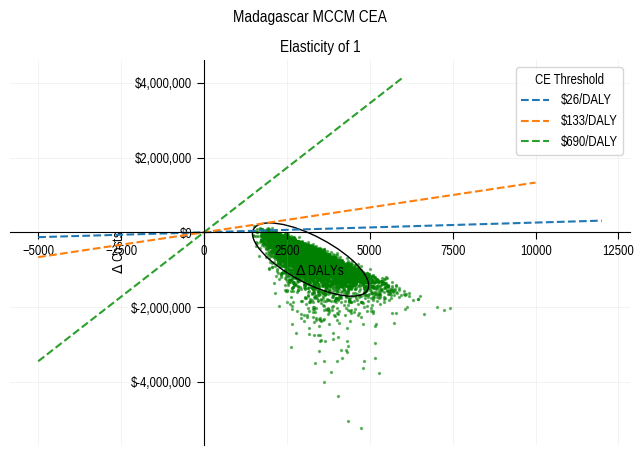

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sc1 = ax.scatter(df["total_qaly"], df["IC_D_100_1.0"],s=2, color="g", alpha=.5)

l1, = ax.plot([-5_000, 12_000], [-130_000, 312_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 10_000], [-665_000, 1_330_000], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")

ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.xlabel(r'$\Delta$ DALYs')
plt.ylabel(f"$\Delta$ Costs")
plt.suptitle("Madagascar MCCM CEA")
plt.title("Elasticity of 1")

plt.legend(bbox_to_anchor=(1.0,1.0), title="CE Threshold");
# leg1 = ax.legend(handles=[sc1, sc2, sc3, sc4], loc="upper right", title="Elasticity")
# ax.add_artist(leg1)
# leg2 = ax.legend(handles=[l1, l2, l3], loc ="lower right", title="CE Threshold")
# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values
y1 = df['IC_D_100_1.0'].values

ci_ellipse(x, y1);

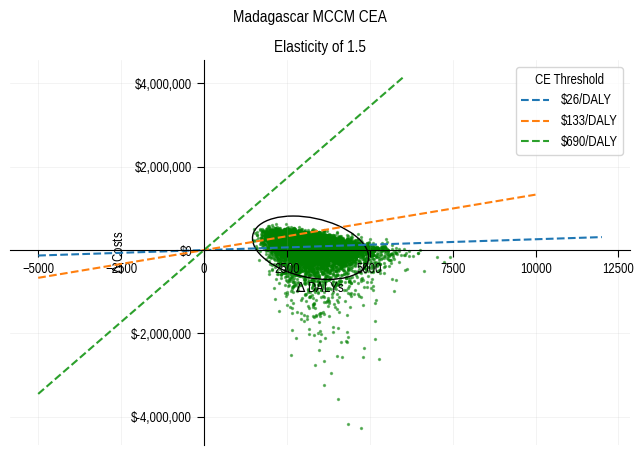

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sc1 = ax.scatter(df["total_qaly"], df["IC_D_100_1.5"],s=2, color="g", alpha=.5)

l1, = ax.plot([-5_000, 12_000], [-130_000, 312_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 10_000], [-665_000, 1_330_000], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")

ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.xlabel(r'$\Delta$ DALYs')
plt.ylabel(f"$\Delta$ Costs")
plt.suptitle("Madagascar MCCM CEA")
plt.title("Elasticity of 1.5")

plt.legend(bbox_to_anchor=(1.0,1.0), title="CE Threshold");
# leg1 = ax.legend(handles=[sc1, sc2, sc3, sc4], loc="upper right", title="Elasticity")
# ax.add_artist(leg1)
# leg2 = ax.legend(handles=[l1, l2, l3], loc ="lower right", title="CE Threshold")
# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values
y1 = df['IC_D_100_1.5'].values

ci_ellipse(x, y1);

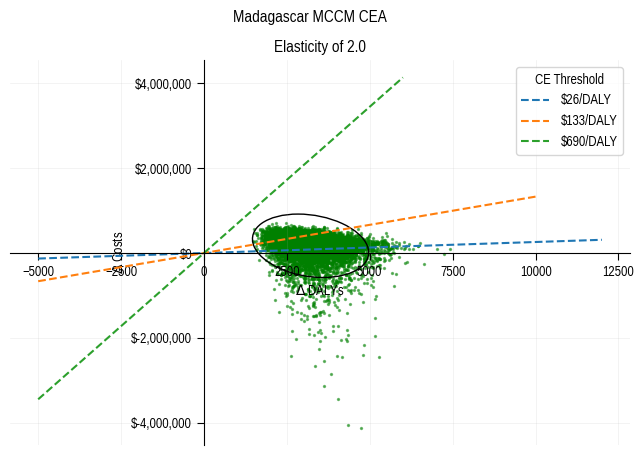

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sc1 = ax.scatter(df["total_qaly"], df["IC_D_100_2.0"],s=2, color="g", alpha=.5)

l1, = ax.plot([-5_000, 12_000], [-130_000, 312_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 10_000], [-665_000, 1_330_000], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")

ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.xlabel(r'$\Delta$ DALYs')
plt.ylabel(f"$\Delta$ Costs")
plt.suptitle("Madagascar MCCM CEA")
plt.title("Elasticity of 2.0")

plt.legend(bbox_to_anchor=(1.0,1.0), title="CE Threshold");
# leg1 = ax.legend(handles=[sc1, sc2, sc3, sc4], loc="upper right", title="Elasticity")
# ax.add_artist(leg1)
# leg2 = ax.legend(handles=[l1, l2, l3], loc ="lower right", title="CE Threshold")
# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values
y1 = df['IC_D_100_2.0'].values

ci_ellipse(x, y1);

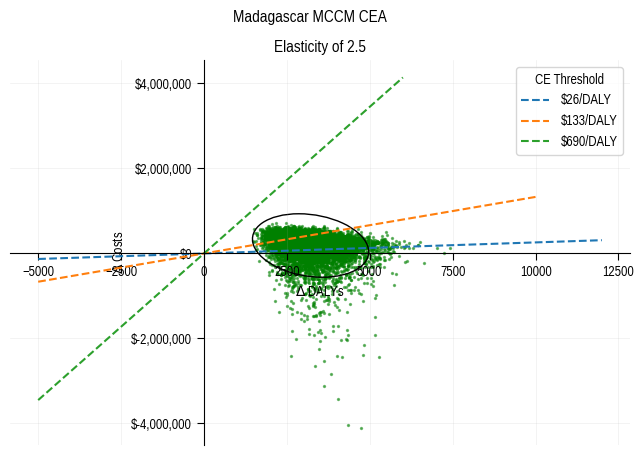

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sc1 = ax.scatter(df["total_qaly"], df["IC_D_100_2.5"],s=2, color="g", alpha=.5)

l1, = ax.plot([-5_000, 12_000], [-130_000, 312_000], label="$26/DALY", ls="--")
l2, = ax.plot([-5_000, 10_000], [-665_000, 1_330_000], label="$133/DALY", ls="--")
l3, = ax.plot([-5_000, 6_000], [-3_450_000, 4_140_000], label="$690/DALY", ls="--")

ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
for sp in ["top", "right"]:
  ax.spines[sp].set_visible(False)
plt.grid(alpha=.2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.xlabel(r'$\Delta$ DALYs')
plt.ylabel(f"$\Delta$ Costs")
plt.suptitle("Madagascar MCCM CEA")
plt.title("Elasticity of 2.5")

plt.legend(bbox_to_anchor=(1.0,1.0), title="CE Threshold");
# leg1 = ax.legend(handles=[sc1, sc2, sc3, sc4], loc="upper right", title="Elasticity")
# ax.add_artist(leg1)
# leg2 = ax.legend(handles=[l1, l2, l3], loc ="lower right", title="CE Threshold")
# Convert DataFrame columns to NumPy arrays
x = df['total_qaly'].values
y1 = df['IC_D_100_2.5'].values

ci_ellipse(x, y1);

In [ ]:
df[["death_costs_1.0", "death_costs_1.5","death_costs_2.0","death_costs_2.5",]][:10]

death_costs_1.0  death_costs_1.5  death_costs_2.0  death_costs_2.5
0     1.132812e+06    300247.363101    179669.611563    162206.709806
1     8.173208e+05    216627.662407    129631.139992    117031.703490
2     7.918349e+05    209872.718926    125588.946053    113382.388652
3     1.321090e+06    350149.694053    209531.430583    189166.123643
4     7.375814e+05    195493.060044    116984.082053    105613.870284
5     8.881292e+05    235395.161271    140861.710666    127170.724231
6     1.352358e+06    358437.240198    214490.742069    193643.417227
7     1.259841e+06    333915.825662    199816.997797    180395.880495
8     1.113497e+06    295127.948200    176606.126584    159440.978781
9     1.347585e+06    357171.996671    213733.613645    192959.877537

##Univariate sensitivity analyses
- vary everything including mortality (eta)

In [ ]:
df["inc_prog_death"] = df["inc_prog"] - df["non_death_savings"] - df["death_costs_1.4"]
df['inc_prog_no_death'] = df["inc_prog"] - df["non_death_savings"]

In [ ]:
df["admissions_averted"].mean()/.65


2657.8754103140027

In [ ]:
# ICERs
mean_icer = df["inc_prog_no_death"].mean()/df["total_qaly"].mean()
min_icer = df["inc_prog_no_death"].min()/df["total_qaly"].mean()
max_icer = df["inc_prog_no_death"].max()/df["total_qaly"].mean()
print(f"Societal perspective no death: {mean_icer:,.2f} [{min_icer:,.2f}, {max_icer:,.2f}]")

Societal perspective no death: -127.05 [-1,448.07, 29.53]


In [ ]:
# ICERs
mean_icer = df["inc_prog_death"].mean()/df["total_qaly"].mean()
min_icer = df["inc_prog_death"].min()/df["total_qaly"].mean()
max_icer = df["inc_prog_death"].max()/df["total_qaly"].mean()
print(f"Societal perspective: {mean_icer:,.2f} [{min_icer:,.2f}, {max_icer:,.2f}]")

Societal perspective: -234.73 [-1,580.38, -50.67]


In [ ]:
def univariate_sensitivity(df, univ_df, col1, col2, col3):
    """
    Calculate the maximum and minimum incremental cost-effectiveness ratios (ICERs)
    for two different columns in the DataFrame.

    Args:
        df (pandas.DataFrame): The main DataFrame containing the orginal data.
        univ_df (pandas.DataFrame): The DataFrame containing the column values for minimum and maximum.
        column_name1 (str): The name of the first column to use for the minimum and maximum values.
        column_name2 (str): The name of the second column to use for the minimum and maximum values.

    Returns:
        tuple: A tuple containing four values:
            - icer_max1 (float): The maximum ICER for the first column.
            - icer_min1 (float): The minimum ICER for the first column.
            - icer_max2 (float): The maximum ICER for the second column.
            - icer_min2 (float): The minimum ICER for the second column.
    """
    min_val = univ_df[col1].iloc[1]
    max_val = univ_df[col1].iloc[2]

    max_x = df[col2] * max_val
    min_x = df[col2] * min_val

    max_y = df['inc_prog_no_death'] + df[col3] - max_x
    min_y = df['inc_prog_no_death'] + df[col3] - min_x

    icer_max = np.mean(max_y) / df['total_qaly'].mean()
    icer_min = np.mean(min_y) / df['total_qaly'].mean()

    return icer_max, icer_min

In [ ]:
# Create an empty dictionary that we will add minimum and maximum values to
univ_sens_dict = {}

#Admission costs
result = univariate_sensitivity(df, univ_df, "admission_cost", "admissions_averted", "admissions_costs_averted")
univ_adm_cost_max = result[1]
univ_adm_cost_min = result[0]
univ_sens_dict["Admission Costs"] = {"min": result[0], "max":result[1]}
print(f"One-way sensitivity analysis - admission costs: $[{result[0]:,.2f}, {result[1]:,.2f}]")

#Admissions averted
result = univariate_sensitivity(df, univ_df,  "admissions_averted", "admission_cost","admissions_costs_averted")
univ_adm_cost_max = result[1]
univ_adm_cost_min = result[0]
univ_sens_dict["Admission Averted"] = {"min": result[0], "max":result[1]}
print(f"One-way sensitivity analysis - admissions averted: $[{result[0]:,.2f}, {result[1]:,.2f}]")

#QALYs
univ_qaly_min = df['inc_prog_no_death'].mean()/df['total_qaly'].quantile(.975)
univ_qaly_max = df['inc_prog_no_death'].mean()/df['total_qaly'].quantile(.025)
univ_sens_dict["Utility"] = {"min": univ_qaly_max, "max":univ_qaly_min}
print(f"One way sensitivity analyses varying QALY: $[{univ_qaly_max:,.2f}, {univ_qaly_min:,.2f}]")

min_val = univ_df["change_opd"].iloc[1]
max_val = univ_df["change_opd"].iloc[2]
min_x = min_val * (opd_costs_2022 + total_rdt + pcm + art_lume +  0.3 *(hemogram + microscopy)) * 1.05
max_x = max_val * (opd_costs_2022 + total_rdt + pcm + art_lume +  0.3 *(hemogram + microscopy)) * 1.05
max_y = df['inc_prog_no_death'] + df['opd_costs_averted'] - min_x
min_y = df['inc_prog_no_death'] + df['opd_costs_averted'] - max_x
univ_opd_averted_max = np.mean(max_y)/df['total_qaly'].mean()
univ_opd_averted_min = np.mean(min_y)/df['total_qaly'].mean()
print(univ_opd_averted_max)
print(univ_opd_averted_min)
univ_sens_dict["OPD Costs Averted"] = {"min": univ_opd_averted_min, "max":univ_opd_averted_max}

# Inpatient consumables
mean_val = df['admission_cost'] - df['ipd_cons_lab']
min_val = mean_val + univ_df['ipd_cons_lab'][1]
max_val = mean_val + univ_df['ipd_cons_lab'][2]
min_y = df["inc_prog_no_death"] + df["admissions_costs_averted"] - (df['admissions_averted'] * max_val)
max_y = df["inc_prog_no_death"] + df["admissions_costs_averted"] - (df['admissions_averted'] * min_val)
univ_consum_max = np.mean(max_y)/df['total_qaly'].mean()
univ_consum_min = np.mean(min_y)/df['total_qaly'].mean()
print(univ_consum_min, univ_consum_max)

univ_sens_dict["IP Consumables"] = {"min": univ_consum_min, "max":univ_consum_max}
max_prod = (df['inc_prog_no_death'].mean() + df["non_death_savings"].mean() - df["non_death_savings"].min())/df["total_qaly"].mean()
min_prod = (df['inc_prog_no_death'].mean() + df["non_death_savings"].mean() - df["non_death_savings"].max())/df["total_qaly"].mean()
print(min_prod, max_prod)
univ_sens_dict["Productivity"] = {"min": min_prod, "max":max_prod}

One-way sensitivity analysis - admission costs: $[-147.66, -111.59]
One-way sensitivity analysis - admissions averted: $[-295.81, -75.48]
One way sensitivity analyses varying QALY: $[-197.97, -84.01]
-63.886236255137135
-237.4191450794784
-131.16908728358626 -123.19378591538319
-464.2383996031797 -66.83048065087516


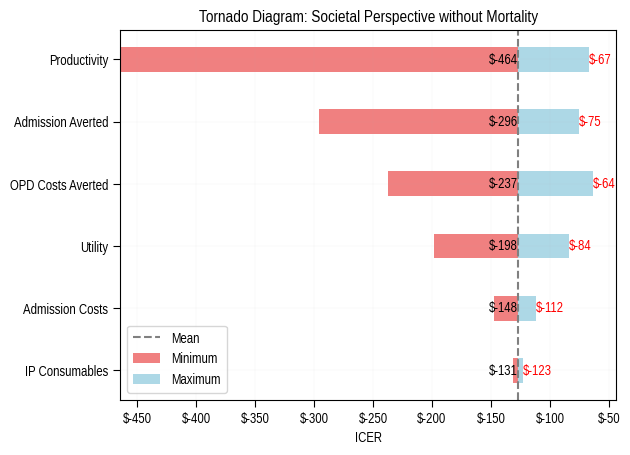

In [ ]:

# Calculate mean value
mean_value = df["inc_prog_no_death"].mean()/df["total_qaly"].mean()
# Calculate the range for each bar and sort the dictionary based on the range
univ_sens_dict = dict(sorted(univ_sens_dict.items(), key=lambda item: item[1]['max'] - item[1]['min'], reverse=False))

# Extract labels, minimum, and maximum values from the dictionary
labels = list(univ_sens_dict.keys())
min_values = [data['min'] for data in univ_sens_dict.values()]
max_values = [data['max'] for data in univ_sens_dict.values()]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot horizontal bars
bar1 = ax.barh(labels, [mean_value - min_val for min_val in min_values], left=min_values,
        color='lightcoral', label='Minimum', height=0.4)
bar2 = ax.barh(labels, [max_val - mean_value for max_val in max_values], left=mean_value,
        color='lightblue', label='Maximum', height=0.4)

# Add mean line
ax.axvline(x=mean_value, color='gray', linestyle='--', label='Mean')

# Add labels, legend, and title
ax.set_xlabel('ICER')
ax.set_ylabel('')
ax.set_title('Tornado Diagram: Societal Perspective without Mortality')
ax.legend()
for rect, min_val, max_val in zip(bar1.patches, min_values, max_values):
    width = rect.get_width()
    ax.text(rect.get_x() + width, rect.get_y() + rect.get_height() / 2,
            f'${min_val:,.0f}', ha='right', va='center', color='black')

for rect, min_val, max_val in zip(bar2.patches, min_values, max_values):
    width = rect.get_width()
    if max_val < 0:
      color = "red"
    else:
      color = "black"
    ax.text(rect.get_x() + width, rect.get_y() + rect.get_height() / 2,
            f'${max_val:,.0f}', ha='left', va='center', color=color)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.grid(lw=.2, alpha=.2)
# Show plot
plt.savefig("tornado_soc_no_death.png", bbox_inches="tight")
plt.show()

In [ ]:
files.download("tornado_soc_no_death.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def univariate_sensitivity(df, univ_df, col1, col2, col3):
    """
    Calculate the maximum and minimum incremental cost-effectiveness ratios (ICERs)
    for two different columns in the DataFrame.

    Args:
        df (pandas.DataFrame): The main DataFrame containing the orginal data.
        univ_df (pandas.DataFrame): The DataFrame containing the column values for minimum and maximum.
        column_name1 (str): The name of the first column to use for the minimum and maximum values.
        column_name2 (str): The name of the second column to use for the minimum and maximum values.

    Returns:
        tuple: A tuple containing four values:
            - icer_max1 (float): The maximum ICER for the first column.
            - icer_min1 (float): The minimum ICER for the first column.
            - icer_max2 (float): The maximum ICER for the second column.
            - icer_min2 (float): The minimum ICER for the second column.
    """
    min_val = univ_df[col1].iloc[1]
    max_val = univ_df[col1].iloc[2]

    max_x = df[col2] * max_val
    min_x = df[col2] * min_val

    max_y = df['inc_prog_death'] + df[col3] - max_x
    min_y = df['inc_prog_death'] + df[col3] - min_x

    icer_max = np.mean(max_y) / df['total_qaly'].mean()
    icer_min = np.mean(min_y) / df['total_qaly'].mean()

    return icer_max, icer_min

In [ ]:
# Create an empty dictionary that we will add minimum and maximum values to
univ_sens_dict = {}

In [ ]:

#Admission costs
result = univariate_sensitivity(df, univ_df, "admission_cost", "admissions_averted", "admissions_costs_averted")
univ_adm_cost_max = result[1]
univ_adm_cost_min = result[0]
univ_sens_dict["Admission Costs"] = {"min": result[0], "max":result[1]}
print(f"One-way sensitivity analysis - admission costs: $[{result[0]:,.2f}, {result[1]:,.2f}]")

#Admissions averted
result = univariate_sensitivity(df, univ_df,  "admissions_averted", "admission_cost","admissions_costs_averted")
univ_adm_cost_max = result[1]
univ_adm_cost_min = result[0]
univ_sens_dict["Admission Averted"] = {"min": result[0], "max":result[1]}
print(f"One-way sensitivity analysis - admissions averted: $[{result[0]:,.2f}, {result[1]:,.2f}]")

#QALYs
univ_qaly_min = df['inc_prog_death'].mean()/df['total_qaly'].quantile(.975)
univ_qaly_max = df['inc_prog_death'].mean()/df['total_qaly'].quantile(.025)
univ_sens_dict["Utility"] = {"min": univ_qaly_max, "max":univ_qaly_min}
print(f"One way sensitivity analyses varying QALY: $[{univ_qaly_max:,.2f}, {univ_qaly_min:,.2f}]")

min_val = univ_df["change_opd"].iloc[1]
max_val = univ_df["change_opd"].iloc[2]
min_x = min_val * (opd_costs_2022 + total_rdt + pcm + art_lume +  0.3 *(hemogram + microscopy)) * 1.05
max_x = max_val * (opd_costs_2022 + total_rdt + pcm + art_lume +  0.3 *(hemogram + microscopy)) * 1.05
max_y = df['inc_prog_death'] + df['opd_costs_averted'] - min_x
min_y = df['inc_prog_death'] + df['opd_costs_averted'] - max_x
univ_opd_averted_max = np.mean(max_y)/df['total_qaly'].mean()
univ_opd_averted_min = np.mean(min_y)/df['total_qaly'].mean()
print(univ_opd_averted_max)
print(univ_opd_averted_min)
univ_sens_dict["OPD Costs Averted"] = {"min": univ_opd_averted_min, "max":univ_opd_averted_max}

# Inpatient consumables
mean_val = df['admission_cost'] - df['ipd_cons_lab']
min_val = mean_val + univ_df['ipd_cons_lab'][1]
max_val = mean_val + univ_df['ipd_cons_lab'][2]
min_y = df["inc_prog_death"] + df["admissions_costs_averted"] - (df['admissions_averted'] * max_val)
max_y = df["inc_prog_death"] + df["admissions_costs_averted"] - (df['admissions_averted'] * min_val)
univ_consum_max = np.mean(max_y)/df['total_qaly'].mean()
univ_consum_min = np.mean(min_y)/df['total_qaly'].mean()
print(univ_consum_min, univ_consum_max)
univ_sens_dict["IP Consumables"] = {"min": univ_consum_min, "max":univ_consum_max}

One-way sensitivity analysis - admission costs: $[-255.34, -219.27]
One-way sensitivity analysis - admissions averted: $[-403.48, -183.16]
One way sensitivity analyses varying QALY: $[-365.74, -155.22]
-171.56289455037762
-345.09580337471886
-238.84574557882672 -230.87044421062365


In [ ]:
max_death = (df['inc_prog_death'].mean() + df["death_costs_1.4"].mean() - df["death_costs_2.5"].mean())/df["total_qaly"].mean()
min_death = (df['inc_prog_death'].mean() + df["death_costs_1.4"].mean() - df["death_costs_1.0"].mean())/df["total_qaly"].mean()
print(max_death, min_death)
univ_sens_dict["Elasticity"] = {"min": min_death, "max":max_death}

-174.6744224561917 -459.63229760069976


In [ ]:
max_prod = (df['inc_prog_death'].mean() + df["non_death_savings"].mean() - df["non_death_savings"].min())/df["total_qaly"].mean()
min_prod = (df['inc_prog_death'].mean() + df["non_death_savings"].mean() - df["non_death_savings"].max())/df["total_qaly"].mean()
print(min_prod, max_prod)
univ_sens_dict["Productivity"] = {"min": min_prod, "max":max_prod}

-571.9150578984202 -174.5071389461156


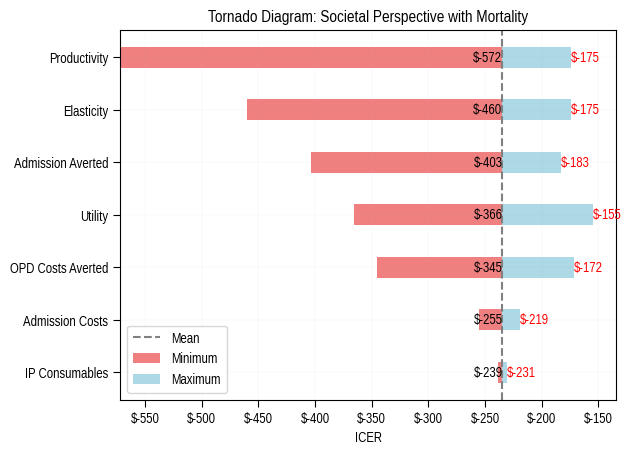

In [ ]:

# Calculate mean value
mean_value = df["inc_prog_death"].mean()/df["total_qaly"].mean()
# Calculate the range for each bar and sort the dictionary based on the range
univ_sens_dict = dict(sorted(univ_sens_dict.items(), key=lambda item: item[1]['max'] - item[1]['min'], reverse=False))

# Extract labels, minimum, and maximum values from the dictionary
labels = list(univ_sens_dict.keys())
min_values = [data['min'] for data in univ_sens_dict.values()]
max_values = [data['max'] for data in univ_sens_dict.values()]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot horizontal bars
bar1 = ax.barh(labels, [mean_value - min_val for min_val in min_values], left=min_values,
        color='lightcoral', label='Minimum', height=0.4)
bar2 = ax.barh(labels, [max_val - mean_value for max_val in max_values], left=mean_value,
        color='lightblue', label='Maximum', height=0.4)

# Add mean line
ax.axvline(x=mean_value, color='gray', linestyle='--', label='Mean')

# Add labels, legend, and title
ax.set_xlabel('ICER')
ax.set_ylabel('')
ax.set_title('Tornado Diagram: Societal Perspective with Mortality')
ax.legend()
for rect, min_val, max_val in zip(bar1.patches, min_values, max_values):
    width = rect.get_width()
    ax.text(rect.get_x() + width, rect.get_y() + rect.get_height() / 2,
            f'${min_val:,.0f}', ha='right', va='center', color='black')

for rect, min_val, max_val in zip(bar2.patches, min_values, max_values):
    width = rect.get_width()
    if max_val < 0:
      color = "red"
    else:
      color = "black"
    ax.text(rect.get_x() + width, rect.get_y() + rect.get_height() / 2,
            f'${max_val:,.0f}', ha='left', va='center', color=color)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(dollar_formatter))
plt.grid(lw=.2, alpha=.2)
# Show plot
plt.savefig("tornado_soc_death.png", bbox_inches="tight")
plt.show()

In [ ]:
files.download("tornado_soc_death.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd "/content/gdrive/MyDrive/Colab Notebooks"

/content/gdrive/MyDrive/Colab Notebooks


In [ ]:
!jupyter nbconvert --to html "Copy of mada_mccm.ipynb"

[NbConvertApp] Converting notebook Copy of mada_mccm.ipynb to html
[NbConvertApp] Writing 5293871 bytes to Copy of mada_mccm.html
